<a href="https://colab.research.google.com/github/valeman/Multi-class-probabilistic-classification/blob/main/multi_class_probabilistic_classification_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi class probabilistic classification - vehicle

In [1]:
#install OpenML
!pip install openml
!pip install dtype_diet

#install XGBoost
!pip install xgboost
!pip install --upgrade xgboost

#install CatBoost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

!git clone https://github.com/wxs/keras-mnist-tutorial.git

     |████████████████████████████████| 119 kB 6.1 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
  Created wheel for openml: filename=openml-0.12.2-py3-none-any.whl size=137326 sha256=ac88a75f05bfeb5bfd009f50cbcf4d130c52630a677d2be97745b42c9fe5f2c9
  Stored in directory: /root/.cache/pip/wheels/6a/20/88/cf4ac86aa18e2cd647ed16ebe274a5dacee9d0075fa02af250
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=2767fc0fe273ee875211b0d8f95e4f59c9c93ede6cc59c50913beefc0b7d3714
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff
     |████████████████████████████████| 193.7 MB 35 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 76.6 MB 103 kB/s 
Enabling notebook extension jupyter-js-widgets/extension...


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import gmean

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, \
roc_auc_score, precision_recall_curve, log_loss, brier_score_loss

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import auc, multilabel_confusion_matrix,roc_curve, roc_auc_score

from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.preprocessing import label_binarize

import plotly.express as px

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import openml

from dtype_diet import report_on_dataframe, optimize_dtypes

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

from sklearn.neural_network import MLPClassifier

from VennABERS import ScoresToMultiProbs


# Load dataset

In [3]:
# List datasets https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

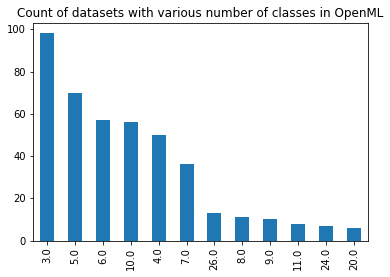

In [4]:
#plot number of datasets for each class size where class size is more than 2
datasets_df[datasets_df['NumberOfClasses'] > 2]['NumberOfClasses'].value_counts()[:20].plot(kind = 'bar')
plt.title('Count of datasets with various number of classes in OpenML')
plt.show()

In [5]:
# output information about selected dataset
datasets_df.loc[54]

name                                  vehicle
version                                     1
uploader                                    1
status                                 active
format                                   ARFF
MajorityClassSize                       218.0
MaxNominalAttDistinctValues               4.0
MinorityClassSize                       199.0
NumberOfClasses                           4.0
NumberOfFeatures                         19.0
NumberOfInstances                       846.0
NumberOfInstancesWithMissingValues        0.0
NumberOfMissingValues                     0.0
NumberOfNumericFeatures                  18.0
NumberOfSymbolicFeatures                  1.0
Name: 54, dtype: object

In [6]:
# vehicle dataset https://www.openml.org/d/54
dataset = openml.datasets.get_dataset(54)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'vehicle', the target feature is 'Class'
URL: https://old.openml.org/data/v1/download/54/vehicle.arff
**Author**: Dr. Pete Mowforth and Dr. Barry Shepherd  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes))
**Please cite**: Siebert,JP. Turing Institute Research Memorandum TIRM-87-018 "Vehicle Recognition Using Rule Based Methods" (March 1987)  

 NAME
         vehicle silhouettes
 
 PURPOSE
         to classify a given silhouette as one of four types of vehicle,
         using  a set of features extracted from the silhouette. The
         vehicle may be vie


In [7]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [8]:
df.head()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
0         95.0         48.0                  83.0         178.0   
1         91.0         41.0                  84.0         141.0   
2        104.0         50.0                 106.0         209.0   
3         93.0         41.0                  82.0         159.0   
4         85.0         44.0                  70.0         205.0   

   PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
0                  72.0                     10.0          162.0   
1                  57.0                      9.0          149.0   
2                  66.0                     10.0          207.0   
3                  63.0                      9.0          144.0   
4                 103.0                     52.0          149.0   

   ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
0           42.0                    20.0                      159.0   
1           45.0                    19.0                      143.0   
2           32.0                    23.0                      158.0   
3           46.0                    19.0                      143.0   
4           45.0                    19.0                      144.0   

   SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
0                  176.0                  379.0                      184.0   
1                  170.0                  330.0                      158.0   
2                  223.0                  635.0                      220.0   
3                  160.0                  309.0                      127.0   
4                  241.0                  325.0                      188.0   

   SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
0                  70.0                   6.0                  16.0   
1                  72.0                   9.0                  14.0   
2                  73.0                  14.0                   9.0   
3                  63.0                   6.0                  10.0   
4                 127.0                   9.0                  11.0   

   KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  class  
0                 187.0          197.0      3  
1                 189.0          199.0      3  
2                 188.0          196.0      1  
3                 199.0          207.0      3  
4                 180.0          183.0      2

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMPACTNESS                846 non-null    float32
 1   CIRCULARITY                846 non-null    float32
 2   DISTANCE_CIRCULARITY       846 non-null    float32
 3   RADIUS_RATIO               846 non-null    float32
 4   PR.AXIS_ASPECT_RATIO       846 non-null    float32
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    float32
 6   SCATTER_RATIO              846 non-null    float32
 7   ELONGATEDNESS              846 non-null    float32
 8   PR.AXIS_RECTANGULARITY     846 non-null    float32
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    float32
 10  SCALED_VARIANCE_MAJOR      846 non-null    float32
 11  SCALED_VARIANCE_MINOR      846 non-null    float32
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    float32
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    float32

In [10]:
df.describe()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
count   846.000000   846.000000            846.000000    846.000000   
mean     93.678490    44.861702             82.088654    168.940903   
std       8.234473     6.169864             15.771533     33.472172   
min      73.000000    33.000000             40.000000    104.000000   
25%      87.000000    40.000000             70.000000    141.000000   
50%      93.000000    44.000000             80.000000    167.000000   
75%     100.000000    49.000000             98.000000    195.000000   
max     119.000000    59.000000            112.000000    333.000000   

       PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
count            846.000000               846.000000     846.000000   
mean              61.693855                 8.567376     168.839249   
std                7.888254                 4.601242      33.244987   
min               47.000000                 2.000000     112.000000   
25%               57.000000                 7.000000     146.250000   
50%               61.000000                 8.000000     157.000000   
75%               65.000000                10.000000     198.000000   
max              138.000000                55.000000     265.000000   

       ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
count     846.000000              846.000000                 846.000000   
mean       40.933807               20.582743                 147.998825   
std         7.811559                2.592137                  14.515652   
min        26.000000               17.000000                 118.000000   
25%        33.000000               19.000000                 137.000000   
50%        43.000000               20.000000                 146.000000   
75%        46.000000               23.000000                 159.000000   
max        61.000000               29.000000                 188.000000   

       SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  \
count             846.000000             846.000000   
mean              188.625290             439.911346   
std                31.394821             176.692642   
min               130.000000             184.000000   
25%               167.000000             318.250000   
50%               178.500000             364.000000   
75%               217.000000             587.000000   
max               320.000000            1018.000000   

       SCALED_RADIUS_OF_GYRATION  SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  \
count                 846.000000            846.000000            846.000000   
mean                  174.703308             72.462173              6.377069   
std                    32.546509              7.486974              4.918353   
min                   109.000000             59.000000              0.000000   
25%                   149.000000             67.000000              2.000000   
50%                   173.000000             71.500000              6.000000   
75%                   198.000000             75.000000              9.000000   
max                   268.000000            135.000000             22.000000   

       KURTOSIS_ABOUT_MAJOR  KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO       class  
count            846.000000            846.000000     846.000000  846.000000  
mean              12.599291            188.932617     195.632385    1.477541  
std                8.931239              6.163929       7.438802    1.105700  
min                0.000000            176.000000     181.000000    0.000000  
25%                5.000000            184.000000     190.250000    0.250000  
50%               11.000000            188.000000     197.000000    1.000000  
75%               19.000000            193.000000     201.000000    2.000000  
max               41.000000            206.000000     211.000000    3.000000

In [11]:
# print number of classes
n_classes = df['class'].nunique()
print('Number of classes: {}'.format(n_classes))

Number of classes: 4


In [12]:
# print number of classes
classes = np.sort(df['class'].unique())

In [13]:
type(classes)

numpy.ndarray

In [14]:
classes

array([0, 1, 2, 3])

In [15]:
# compress memory footprint using dtype_diet whilst retaining information 
proposed_df = report_on_dataframe(df, unit="MB")
print('Original df memory: {} MB'.format(round(df.memory_usage(deep=True).sum()/1024/1024, 2)))

df = optimize_dtypes(df, proposed_df)

print('Optimized df memory: {} MB'.format(round(df.memory_usage(deep=True).sum()/1024/1024, 2)))

Original df memory: 0.06 MB
Optimized df memory: 0.06 MB


In [16]:
df.to_csv('vehicle.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMPACTNESS                846 non-null    float32
 1   CIRCULARITY                846 non-null    float32
 2   DISTANCE_CIRCULARITY       846 non-null    float32
 3   RADIUS_RATIO               846 non-null    float32
 4   PR.AXIS_ASPECT_RATIO       846 non-null    float32
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    float32
 6   SCATTER_RATIO              846 non-null    float32
 7   ELONGATEDNESS              846 non-null    float32
 8   PR.AXIS_RECTANGULARITY     846 non-null    float32
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    float32
 10  SCALED_VARIANCE_MAJOR      846 non-null    float32
 11  SCALED_VARIANCE_MINOR      846 non-null    float32
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    float32
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    float32

In [18]:
# imbalanced class problem
df['class'].value_counts()

2    218
1    217
0    212
3    199
Name: class, dtype: int64

# Experiments

In [19]:
algos = ['Naive Bayes', 'KNN', 'Support Vector Machine', 'logistic regression', 'neural network', 'Random Forest', \
         'LightGBM', 'XGBoost', 'CatBoost', 'Ada Boost']

number_baseline_algos = len(algos)
print('Number of baseline algorithms: {}'.format(number_baseline_algos))

calibration_algos = ['no calibration', 'sigmoid', 'isotonic', 'sigmoid cv', 'isotonic cv', 'ivap', 'cvap']
number_calibration_algos = len(calibration_algos)

Number of baseline algorithms: 10


In [20]:
# function initialize_array creates an 2d array of size m x n and initializes it with NaNs
def initialize_array(size = (number_baseline_algos, number_calibration_algos)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

In [21]:
# setup dataframes to store results for the Brier and the Log loss
brier_loss_df = pd.DataFrame(data = initialize_array(), index = algos, columns = calibration_algos)
log_loss_df = brier_loss_df.copy()

In [22]:
brier_loss_df.head()

no calibration  sigmoid  isotonic  sigmoid cv  \
Naive Bayes                        NaN      NaN       NaN         NaN   
KNN                                NaN      NaN       NaN         NaN   
Support Vector Machine             NaN      NaN       NaN         NaN   
logistic regression                NaN      NaN       NaN         NaN   
neural network                     NaN      NaN       NaN         NaN   

                        isotonic cv  ivap  cvap  
Naive Bayes                     NaN   NaN   NaN  
KNN                             NaN   NaN   NaN  
Support Vector Machine          NaN   NaN   NaN  
logistic regression             NaN   NaN   NaN  
neural network                  NaN   NaN   NaN

In [23]:
log_loss_df.head()

no calibration  sigmoid  isotonic  sigmoid cv  \
Naive Bayes                        NaN      NaN       NaN         NaN   
KNN                                NaN      NaN       NaN         NaN   
Support Vector Machine             NaN      NaN       NaN         NaN   
logistic regression                NaN      NaN       NaN         NaN   
neural network                     NaN      NaN       NaN         NaN   

                        isotonic cv  ivap  cvap  
Naive Bayes                     NaN   NaN   NaN  
KNN                             NaN   NaN   NaN  
Support Vector Machine          NaN   NaN   NaN  
logistic regression             NaN   NaN   NaN  
neural network                  NaN   NaN   NaN

## Create proper training, validation and test set

In [24]:
n_folds = 5

In [25]:
df.head()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
0         95.0         48.0                  83.0         178.0   
1         91.0         41.0                  84.0         141.0   
2        104.0         50.0                 106.0         209.0   
3         93.0         41.0                  82.0         159.0   
4         85.0         44.0                  70.0         205.0   

   PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
0                  72.0                     10.0          162.0   
1                  57.0                      9.0          149.0   
2                  66.0                     10.0          207.0   
3                  63.0                      9.0          144.0   
4                 103.0                     52.0          149.0   

   ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
0           42.0                    20.0                      159.0   
1           45.0                    19.0                      143.0   
2           32.0                    23.0                      158.0   
3           46.0                    19.0                      143.0   
4           45.0                    19.0                      144.0   

   SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
0                  176.0                  379.0                      184.0   
1                  170.0                  330.0                      158.0   
2                  223.0                  635.0                      220.0   
3                  160.0                  309.0                      127.0   
4                  241.0                  325.0                      188.0   

   SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
0                  70.0                   6.0                  16.0   
1                  72.0                   9.0                  14.0   
2                  73.0                  14.0                   9.0   
3                  63.0                   6.0                  10.0   
4                 127.0                   9.0                  11.0   

   KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  class  
0                 187.0          197.0      3  
1                 189.0          199.0      3  
2                 188.0          196.0      1  
3                 199.0          207.0      3  
4                 180.0          183.0      2

In [26]:
len_test_set = int(0.2 * len(df))
print('Test set size: {}'.format(len_test_set))

Test set size: 169


In [27]:
len_train_cal_set = len(df) - len_test_set
print('Train and calibration set size: {}'.format(len_train_cal_set))

Train and calibration set size: 677


In [28]:
df_train_cal, df_test = train_test_split(df, test_size = len_test_set, random_state = 42, shuffle = True)

In [29]:
print('Training and calibration set size: {}'.format(len(df_train_cal)))
print('Test set size: {}'.format(len(df_test)))

Training and calibration set size: 677
Test set size: 169


In [30]:
len_cal_set = len_test_set

In [31]:
df_proper_train, df_cal = train_test_split(df_train_cal, test_size = len_cal_set, random_state = 42, 
                                           shuffle = True)

In [32]:
print('Proper training set size: {}'.format(len(df_proper_train)))
print('Calibration set size: {}'.format(len(df_cal)))

Proper training set size: 508
Calibration set size: 169


In [33]:
df_proper_train.head()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
352         91.0         46.0                  78.0         148.0   
544         88.0         43.0                  70.0         177.0   
775         97.0         38.0                  75.0         188.0   
177         89.0         44.0                  72.0         160.0   
594         83.0         40.0                  59.0         116.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
352                  61.0                      9.0          147.0   
544                  74.0                     19.0          152.0   
775                  68.0                      6.0          171.0   
177                  66.0                      7.0          144.0   
594                  53.0                      7.0          132.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
352           45.0                    19.0                      152.0   
544           44.0                    19.0                      143.0   
775           37.0                    20.0                      129.0   
177           46.0                    19.0                      147.0   
594           52.0                    18.0                      137.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
352                  168.0                  323.0                      199.0   
544                  180.0                  342.0                      168.0   
775                  199.0                  450.0                      137.0   
177                  166.0                  312.0                      169.0   
594                  145.0                  250.0                      157.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
352                  70.0                  13.0                  11.0   
544                  76.0                   1.0                   9.0   
775                  74.0                   2.0                   6.0   
177                  69.0                  11.0                   1.0   
594                  84.0                  12.0                   6.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  class  
352                 189.0          200.0      3  
544                 186.0          189.0      2  
775                 197.0          199.0      2  
177                 191.0          198.0      2  
594                 177.0          183.0      3

In [34]:
X_train = df_train_cal.drop('class', axis=1)
y_train = df_train_cal['class']

In [35]:
X_proper_train = df_proper_train.drop('class', axis=1)
y_proper_train = df_proper_train['class']

X_cal = df_cal.drop('class', axis=1)
y_cal = df_cal['class']

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']

In [36]:
X_proper_train.head()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
352         91.0         46.0                  78.0         148.0   
544         88.0         43.0                  70.0         177.0   
775         97.0         38.0                  75.0         188.0   
177         89.0         44.0                  72.0         160.0   
594         83.0         40.0                  59.0         116.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
352                  61.0                      9.0          147.0   
544                  74.0                     19.0          152.0   
775                  68.0                      6.0          171.0   
177                  66.0                      7.0          144.0   
594                  53.0                      7.0          132.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
352           45.0                    19.0                      152.0   
544           44.0                    19.0                      143.0   
775           37.0                    20.0                      129.0   
177           46.0                    19.0                      147.0   
594           52.0                    18.0                      137.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
352                  168.0                  323.0                      199.0   
544                  180.0                  342.0                      168.0   
775                  199.0                  450.0                      137.0   
177                  166.0                  312.0                      169.0   
594                  145.0                  250.0                      157.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
352                  70.0                  13.0                  11.0   
544                  76.0                   1.0                   9.0   
775                  74.0                   2.0                   6.0   
177                  69.0                  11.0                   1.0   
594                  84.0                  12.0                   6.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  
352                 189.0          200.0  
544                 186.0          189.0  
775                 197.0          199.0  
177                 191.0          198.0  
594                 177.0          183.0

In [37]:
X_proper_train.tail()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
442         91.0         36.0                  60.0         126.0   
445         89.0         46.0                  74.0         135.0   
261         91.0         39.0                  88.0         189.0   
147         91.0         40.0                  76.0         171.0   
554        113.0         48.0                  98.0         208.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
442                  56.0                      6.0          119.0   
445                  59.0                      9.0          157.0   
261                  63.0                      9.0          175.0   
147                  67.0                      7.0          149.0   
554                  62.0                      9.0          203.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
442           56.0                    17.0                      130.0   
445           44.0                    20.0                      158.0   
261           38.0                    21.0                      132.0   
147           44.0                    19.0                      135.0   
554           33.0                    23.0                      151.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
442                  139.0                  211.0                      118.0   
445                  170.0                  356.0                      177.0   
261                  197.0                  457.0                      156.0   
147                  169.0                  332.0                      144.0   
554                  216.0                  613.0                      183.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
442                  67.0                   6.0                  14.0   
445                  79.0                  12.0                   3.0   
261                  69.0                   0.0                  23.0   
147                  68.0                   4.0                  17.0   
554                  64.0                  17.0                  29.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  
442                 192.0          198.0  
445                 184.0          191.0  
261                 191.0          198.0  
147                 192.0          200.0  
554                 193.0          204.0

In [38]:
X_cal.head()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
313         96.0         52.0                 104.0         222.0   
725         91.0         37.0                  76.0         138.0   
798        103.0         56.0                 100.0         185.0   
171        106.0         54.0                 103.0         161.0   
108         80.0         44.0                  68.0         135.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
313                  67.0                      9.0          198.0   
725                  55.0                      8.0          132.0   
798                  59.0                     11.0          216.0   
171                  47.0                      4.0          247.0   
108                  59.0                      8.0          150.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
313           33.0                    23.0                      163.0   
725           51.0                    18.0                      135.0   
798           31.0                    24.0                      173.0   
171           27.0                    27.0                      166.0   
108           45.0                    19.0                      145.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
313                  217.0                  589.0                      226.0   
725                  157.0                  256.0                      124.0   
798                  219.0                  684.0                      219.0   
171                  266.0                  892.0                      242.0   
108                  170.0                  329.0                      173.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
313                  67.0                  12.0                  20.0   
725                  69.0                   0.0                  12.0   
798                  75.0                  15.0                  11.0   
171                  85.0                   4.0                  11.0   
108                  80.0                   7.0                  12.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  
313                 192.0          201.0  
725                 191.0          192.0  
798                 186.0          194.0  
171                 181.0          183.0  
108                 180.0          185.0

In [39]:
X_cal.tail()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
161        107.0         52.0                 101.0         218.0   
330         98.0         44.0                  78.0         160.0   
298         91.0         40.0                  98.0         192.0   
843        106.0         54.0                 101.0         222.0   
194         92.0         37.0                  86.0         167.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
161                  64.0                     11.0          202.0   
330                  63.0                      8.0          142.0   
298                  64.0                      9.0          177.0   
843                  67.0                     12.0          222.0   
194                  60.0                      7.0          158.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
161           33.0                    23.0                      164.0   
330           47.0                    18.0                      148.0   
298           38.0                    21.0                      135.0   
843           30.0                    25.0                      173.0   
194           42.0                    20.0                      131.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
161                  219.0                  610.0                      192.0   
330                  160.0                  300.0                      171.0   
298                  194.0                  465.0                      165.0   
843                  228.0                  721.0                      200.0   
194                  181.0                  373.0                      144.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
161                  65.0                  17.0                   2.0   
330                  63.0                  19.0                   2.0   
298                  66.0                   9.0                  35.0   
843                  70.0                   3.0                   4.0   
194                  68.0                   9.0                  21.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  
161                 197.0          206.0  
330                 201.0          207.0  
298                 195.0          205.0  
843                 187.0          201.0  
194                 190.0          196.0

In [40]:
X_test.head()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
39          81.0         45.0                  68.0         169.0   
250         95.0         38.0                  66.0         126.0   
314         90.0         42.0                  63.0         126.0   
96          89.0         42.0                  80.0         151.0   
198         81.0         46.0                  71.0         130.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
39                   73.0                      6.0          151.0   
250                  52.0                      8.0          133.0   
314                  55.0                      7.0          152.0   
96                   62.0                      6.0          144.0   
198                  56.0                      7.0          153.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
39            44.0                    19.0                      146.0   
250           52.0                    18.0                      140.0   
314           45.0                    19.0                      142.0   
96            46.0                    19.0                      139.0   
198           44.0                    19.0                      149.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
39                   173.0                  336.0                      186.0   
250                  158.0                  253.0                      140.0   
314                  173.0                  336.0                      173.0   
96                   166.0                  308.0                      170.0   
198                  172.0                  342.0                      191.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
39                   75.0                   7.0                   0.0   
250                  78.0                  11.0                   8.0   
314                  81.0                   0.0                  15.0   
96                   74.0                  17.0                  13.0   
198                  81.0                   3.0                  14.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  
39                  183.0          189.0  
250                 184.0          183.0  
314                 180.0          184.0  
96                  185.0          189.0  
198                 180.0          186.0

In [41]:
X_test.tail()

COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
332         99.0         57.0                 109.0         220.0   
792        100.0         51.0                 104.0         163.0   
2          104.0         50.0                 106.0         209.0   
760        107.0         45.0                  92.0         197.0   
778        111.0         50.0                 103.0         199.0   

     PR.AXIS_ASPECT_RATIO  MAX.LENGTH_ASPECT_RATIO  SCATTER_RATIO  \
332                  66.0                     11.0          221.0   
792                  52.0                     10.0          206.0   
2                    66.0                     10.0          207.0   
760                  62.0                     10.0          188.0   
778                  60.0                     11.0          211.0   

     ELONGATEDNESS  PR.AXIS_RECTANGULARITY  MAX.LENGTH_RECTANGULARITY  \
332           30.0                    25.0                      176.0   
792           32.0                    23.0                      164.0   
2             32.0                    23.0                      158.0   
760           35.0                    22.0                      148.0   
778           31.0                    24.0                      156.0   

     SCALED_VARIANCE_MAJOR  SCALED_VARIANCE_MINOR  SCALED_RADIUS_OF_GYRATION  \
332                  234.0                  725.0                      236.0   
792                  217.0                  631.0                      193.0   
2                    223.0                  635.0                      220.0   
760                  202.0                  526.0                      159.0   
778                  223.0                  663.0                      188.0   

     SKEWNESS_ABOUT_MAJOR  SKEWNESS_ABOUT_MINOR  KURTOSIS_ABOUT_MAJOR  \
332                  70.0                  10.0                  25.0   
792                  69.0                   5.0                  21.0   
2                    73.0                  14.0                   9.0   
760                  64.0                  12.0                  20.0   
778                  68.0                   9.0                   9.0   

     KURTOSIS_ABOUT_MINOR  HOLLOWS_RATIO  
332                 188.0          200.0  
792                 188.0          196.0  
2                   188.0          196.0  
760                 195.0          203.0  
778                 190.0          200.0

In [42]:
y_proper_train.tail()

442    3
445    3
261    1
147    2
554    1
Name: class, dtype: int8

In [43]:
y_cal.tail()

161    0
330    3
298    1
843    1
194    1
Name: class, dtype: int8

In [44]:
y_test.tail()

332    0
792    0
2      1
760    0
778    1
Name: class, dtype: int8

In [45]:
assert(len(X_train) == len(X_proper_train) + len(X_cal))

In [46]:
assert(len(df) == len(X_train) + len(X_test))

In [47]:
# function initialize_array creates a 3d array size and initializes it with NaNs

def initialize_3d_array(size = (n_classes, n_classes, len_test_set)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

In [48]:
# function initialize_array creates a 4d array and initializes it with NaNs

def initialize_4d_array(size = (n_classes, n_classes, len_test_set, n_folds)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

## Binary classification

In [49]:
algos

['Naive Bayes',
 'KNN',
 'Support Vector Machine',
 'logistic regression',
 'neural network',
 'Random Forest',
 'LightGBM',
 'XGBoost',
 'CatBoost',
 'Ada Boost']

In [50]:
# given pairwise probabilities compute multiclass probabilities
def multi_probabilities(scores_pairwise, len_test_set):
    prob = np.empty(shape = (n_classes,1))
    probs = np.empty(shape = (n_classes,len_test_set))

    for idx in range(len_test_set):
        prob[0]=1/(1/(scores_pairwise[0,1,idx])+1/(scores_pairwise[0,2,idx])
                   + 1/(scores_pairwise[0,3,idx])-(n_classes-2))
                   
        prob[1]=1/(1/(scores_pairwise[1,0,idx])+1/(scores_pairwise[1,2,idx])
                   + 1/(scores_pairwise[1,3,idx])-(n_classes-2))

        prob[2]=1/(1/(scores_pairwise[2,0,idx])+1/(scores_pairwise[2,1,idx])
                   + 1/(scores_pairwise[2,3,idx])-(n_classes-2))

        prob[3]=1/(1/(scores_pairwise[3,0,idx])+1/(scores_pairwise[3,1,idx])
                   + 1/(scores_pairwise[3,2,idx])-(n_classes-2))

        # prob[4]=1/(1/(scores_pairwise[4,0,idx])+1/(scores_pairwise[4,1,idx])
        #            + 1/(scores_pairwise[4,2,idx])+ 1/(scores_pairwise[4,3,idx])
        #            + 1/(scores_pairwise[4,5,idx])-(n_classes-2))


        # prob[5]=1/(1/(scores_pairwise[5,0,idx])+1/(scores_pairwise[5,1,idx])
        #            + 1/(scores_pairwise[5,2,idx])+ 1/(scores_pairwise[5,3,idx])
        #            + 1/(scores_pairwise[5,4,idx])-(n_classes-2))            
        
        #normalize probabilities 
        probs[0,idx] = prob[0]/(prob[0]+prob[1]+prob[2]+prob[3])
        probs[1,idx] = prob[1]/(prob[0]+prob[1]+prob[2]+prob[3])
        probs[2,idx] = prob[2]/(prob[0]+prob[1]+prob[2]+prob[3])
        probs[3,idx] = prob[3]/(prob[0]+prob[1]+prob[2]+prob[3])
        # probs[4,idx] = prob[4]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
        # probs[5,idx] = prob[5]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
    return probs    

In [51]:
classes

array([0, 1, 2, 3])

In [52]:
# # given pairwise probabilities compute multiclass probabilities
# def multi_probabilities(scores_pairwise, len_test_set):
#   prob = np.empty(shape = (n_classes,1))
#   probs = np.empty(shape = (n_classes,len_test_set))
  
#   for idx in range(len_test_set):
#       for i in range(n_classes):
#           sum_denom  = 0
#           for j in range(n_classes): 
#               # if the same class number continue to next element
#               if i == j:
#                   continue
#               else:
#                   sum_denom = sum_denom + 1/(scores_pairwise[i,j,idx])            
#           prob = 1/(sum_denom - (n_classes-2))
#           #normalize probabilities 
#           probs[i, idx] = prob / np.sum(prob)
    
#   return probs  

In [53]:
# compute uncalibrated probabilities and predicted classes
def uncalibrated_predictions(model,n_classes=n_classes, X_train=X_train, y_train=y_train):
    
    # initialize 3D array of uncalibrated pairwise prediction scores 
    scores_pairwise_nocal = np.empty((n_classes,n_classes, len(X_test)), dtype = 'float')
    scores_pairwise_nocal[:] = np.nan

    # compute pairwise uncalibrated prediction scores 
    print('\nComputing pairwise uncalibrated predictions')
    for i in range(0,n_classes): # iterate over n_classes
        for j in range(0,n_classes):
            if i == j:
              continue
            print('fitting model for i: {}, j:{}'.format(i,j))
            class1_train_idx = y_train[y_train == i].index
            class0_train_idx = y_train[y_train == j].index
        
            # create pairwise datasets 
            y_train_pairwise_0 = y_train.loc[class0_train_idx]
            y_train_pairwise_0 = pd.Series(data = 0, index = y_train_pairwise_0.index)
            y_train_pairwise_1 = y_train.loc[class1_train_idx]
            y_train_pairwise_1 = pd.Series(data = 1, index = y_train_pairwise_1.index)

            X_train_pairwise = pd.concat([X_train.loc[class0_train_idx], X_train.loc[class1_train_idx]])
            y_train_pairwise = pd.concat([y_train_pairwise_0, y_train_pairwise_1])

            model.fit(X_train_pairwise, y_train_pairwise)

            # predict probabilities of class 1
            scores_pairwise_nocal[i,j,:] = model.predict_proba(X_test)[:,1]
 
    # compute multiclass uncalibrated prediction scores
    y_pred_probs = multi_probabilities(scores_pairwise_nocal, len_test_set)
    
    #compute class and probability of predicted class - in turn equals to maximum probability for each test object  
    y_pred_class = np.argmax(y_pred_probs, axis=0)
    
    return [y_pred_class, y_pred_probs]

In [54]:
# plot ROC curve, y_test - actual labels, y_pred_probs - predicted probabilities  
def plot_roc_curve(y_test, y_pred_probs, y_pred_class, n_classes = n_classes):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = y_pred_probs.T

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #plot Plot of a ROC curve for a specific class - index in roc_auc

    plt.figure()
    lw = 2
    plt.plot(
        fpr[2],
        tpr[2],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.4f)" % roc_auc[1],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    print(multilabel_confusion_matrix(y_test, y_pred_class))
    
        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,10), dpi=80)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

In [55]:
#The function that implements the Venn-ABERS Predictor is ScoresToMultiProbs().
# p0,p1 = ScoresToMultiProbs(calibrPts,testScores)
# calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples. The score is a float and the label is an integer meant to take values 0 or 1.
# testScores: a list of floats corresponding to the scores for the test objects.
# The function returns a pair of Numpy arrays with the probabilistic predictions.

In [56]:
# function creates pairwise datasets based on indices for 0 an 1 class
def create_pairwise_datasets(X, y, index_0, index_1):
    
    class0_idx = y[y == index_0].index
    class1_idx = y[y == index_1].index
    
    # create pairwise datasets 
    y_pairwise_0 = pd.Series(data = 0, index = y.loc[class0_idx].index)
    y_pairwise_1 = pd.Series(data = 1, index = y.loc[class1_idx].index)

    X_pairwise = pd.concat([X.loc[class0_idx],X.loc[class1_idx]])
    y_pairwise = pd.concat([y_pairwise_0, y_pairwise_1])
    return [X_pairwise, y_pairwise]

In [57]:
# compute calibrated probabilities and predicted classes
def compute_predictions(model,model_name, n_classes=n_classes, X_proper_train=X_proper_train, \
        y_proper_train=y_proper_train,X_cal=X_cal, y_cal=y_cal, y_test = y_test):
    
    y_test_binarized = label_binarize(y_test, classes=classes)
    
    # stratified KFold required for CVAP
    rskf = StratifiedKFold(n_splits=n_folds,shuffle=True, random_state=42)
    
    # compute uncalibrated probabilities and predicted classes
    [y_pred_class_nocal, y_pred_probs_nocal] = uncalibrated_predictions(model)

    # initialize 3D arrays of calibrated pairwise prediction scores
    # function initialize_array creates an array size m x n and initializes it with NaNs
    probs_pairwise_test_sigm = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_iso = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_sigm_cv = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_iso_cv = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_ivap = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_cvap = initialize_3d_array((n_classes, n_classes, len_test_set)) 
    
    probs_test_ivap = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_test_cvap = initialize_3d_array((n_classes, n_classes, len_test_set))
    
    p0_folds_cvap = initialize_array((len_test_set, n_folds))
    p1_folds_cvap = initialize_array((len_test_set, n_folds))
    
    # compute pairwise uncalibrated prediction scores
    print('\nComputing pairwise calibrated predictions')
    for i in range(n_classes): # iterate over n_classes
        for j in range(n_classes):
            if i == j:
              continue
            print('fitting model for i: {}, j:{}'.format(i,j))
            # create pairwise datasets
            X_proper_train_pairwise, y_proper_train_pairwise = create_pairwise_datasets(X_proper_train,\
                y_proper_train, index_0 = classes[j], index_1 = classes[i])
            
            X_train_pairwise, y_train_pairwise = create_pairwise_datasets(X_train, y_train, index_0 = classes[j], index_1 = classes[i])
            X_cal_pairwise, y_cal_pairwise = create_pairwise_datasets(X_cal, y_cal, index_0 = classes[j], index_1 = classes[i])
            
            # fit pairwise base model on the proper training dataset
            model.fit(X_proper_train_pairwise, y_proper_train_pairwise)
            
            # calibrate model on calibration data set 
            # Already fitted classifiers can be calibrated via the parameter cv="prefit".
            # In this case, no cross-validation is used and all provided data is used for calibration. 

            # Platt's scaler
            cal_sigm = CalibratedClassifierCV(model, method='sigmoid', cv='prefit', n_jobs = -1)
            cal_sigm.fit(X_cal_pairwise, y_cal_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_sigm[i,j,:] = cal_sigm.predict_proba(X_test)[:,1]

            # Isotonic regression 
            cal_iso = CalibratedClassifierCV(model, method='isotonic', cv='prefit', n_jobs = -1)
            cal_iso.fit(X_cal_pairwise, y_cal_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_iso[i,j,:] = cal_iso.predict_proba(X_test)[:,1]
            
            ## Cross-validated calibration 
            # Platt's scaler
            cal_sigm_cv = CalibratedClassifierCV(model, method='sigmoid', cv=5, n_jobs = -1)
            cal_sigm_cv.fit(X_train_pairwise, y_train_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_sigm_cv[i,j,:] = cal_sigm_cv.predict_proba(X_test)[:,1]

            # Isotonic regression
            cal_iso_cv = CalibratedClassifierCV(model, method='isotonic', cv=5,n_jobs = -1)
            cal_iso_cv.fit(X_train_pairwise, y_train_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_iso_cv[i,j,:] = cal_iso_cv.predict_proba(X_test)[:,1]
        
            # Venn-Abers IVAP
            model.fit(X_proper_train_pairwise, y_proper_train_pairwise)

            # predict probabilities of class 1
            probability_pairwise_cal_ivap = model.predict_proba(X_cal_pairwise)[:,1]
            probability_pairwise_test_ivap = model.predict_proba(X_test)[:,1]

            p0_ivap,p1_ivap = ScoresToMultiProbs(list(zip(probability_pairwise_cal_ivap,y_cal_pairwise)),\
                                                 probability_pairwise_test_ivap)
    
            probs_pairwise_test_ivap[i,j,:] = p1_ivap/(1-p0_ivap+p1_ivap)
            
            
            # Venn-Abers CVAP - Support Vector Classifier
            
            idx = 0
            
            for proper_train_index, cal_index in rskf.split(X_train_pairwise, y_train_pairwise):
            #print("TRAIN:", proper_train_index[:20], "TEST:", cal_index[:20])
                X_proper_train_fold, X_cal_fold = X_train_pairwise.iloc[proper_train_index],X_train_pairwise.iloc[cal_index]
                y_proper_train_fold, y_cal_fold = y_train_pairwise.iloc[proper_train_index],y_train_pairwise.iloc[cal_index]

                # fit base model on the proper training dataset
                model.fit(X_proper_train_fold, y_proper_train_fold)

                # predict probabilities of class 1
                probability_folds_cal_cvap = model.predict_proba(X_cal_fold)[:,1]
                probability_folds_test_cvap = model.predict_proba(X_test)[:,1]

                p0_folds_cvap[:, idx],p1_folds_cvap[:,idx] = ScoresToMultiProbs(list(zip(probability_folds_cal_cvap,
                        y_cal_fold)),probability_folds_test_cvap)


                idx = idx + 1

                if idx == n_folds:
                    break

            assert(1 - np.isnan(p0_folds_cvap).any())
            assert(1 - np.isnan(p1_folds_cvap).any())                                                                           

            GM1_p0 = gmean(1- p0_folds_cvap, 1)
            GMp1 = gmean(p1_folds_cvap,1)

            probs_pairwise_test_cvap[i,j,:] = GMp1/(GM1_p0+GMp1) 

            # check if probabilities >= 0 and <= 1    
            assert(1 - np.isnan(probs_pairwise_test_sigm[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_iso[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_sigm_cv[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_iso_cv[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_ivap[i,j,:]).any()) 
            assert(1 - np.isnan(probs_pairwise_test_cvap[i,j,:]).any())   

    # compute multiclass calibrated probabilities
    y_pred_probs_sigm = multi_probabilities(probs_pairwise_test_sigm, len_test_set)                                               
    y_pred_probs_iso = multi_probabilities(probs_pairwise_test_iso, len_test_set) 
    y_pred_probs_sigm_cv = multi_probabilities(probs_pairwise_test_sigm_cv, len_test_set)                                                
    y_pred_probs_iso_cv = multi_probabilities(probs_pairwise_test_iso_cv, len_test_set)
    y_pred_probs_ivap = multi_probabilities(probs_pairwise_test_ivap, len_test_set)
    y_pred_probs_cvap = multi_probabilities(probs_pairwise_test_cvap, len_test_set)
    
    # check if probabilities >= 0 and <= 1    
    assert(1 - np.isnan(y_pred_probs_sigm).any())
    assert(1 - np.isnan(y_pred_probs_iso).any())
    assert(1 - np.isnan(y_pred_probs_sigm_cv).any())
    assert(1 - np.isnan(y_pred_probs_iso_cv).any())
    assert(1 - np.isnan(y_pred_probs_ivap).any())
    assert(1 - np.isnan(y_pred_probs_cvap).any())
     
    #compute predicted class  
    y_pred_class_sigm = np.argmax(y_pred_probs_sigm, axis=0)
    y_pred_class_iso = np.argmax(y_pred_probs_iso, axis=0)
    y_pred_class_sigm_cv = np.argmax(y_pred_probs_sigm_cv, axis=0)
    y_pred_class_iso_cv = np.argmax(y_pred_probs_iso_cv, axis=0)    
    y_pred_class_ivap = np.argmax(y_pred_probs_ivap, axis=0)
    y_pred_class_cvap = np.argmax(y_pred_probs_cvap, axis=0)
    
    # output predicted classes and class probabilities
    y_pred_class_list = [y_pred_class_sigm, y_pred_class_iso, y_pred_class_sigm_cv, y_pred_class_iso_cv, 
                         y_pred_class_ivap, y_pred_class_cvap]
    y_pred_probs_list = [y_pred_probs_sigm, y_pred_probs_iso, y_pred_probs_sigm_cv, y_pred_probs_iso_cv,
                         y_pred_probs_ivap, y_pred_probs_cvap]
    
    # insert uncalibrated scores and predicted class from underlying algorithm
    y_pred_probs_list.insert(0,y_pred_probs_nocal)
    y_pred_class_list.insert(0,y_pred_class_nocal)

    log_loss_score = np.empty(shape = (len_test_set))
    brier_score = np.empty(shape = (len_test_set))

    log_loss_score[:] = np.NaN
    brier_score[:] = np.NaN

    for algo_number, cal_algo_name in enumerate(calibration_algos):
        for idx in range(len_test_set):
            log_loss_score[idx] = log_loss(y_test_binarized[idx], y_pred_probs_list[algo_number][:,idx])
            brier_score[idx] = brier_score_loss(y_test_binarized[idx], y_pred_probs_list[algo_number][:,idx])
        log_loss_df.loc[model_name, cal_algo_name] = np.mean(log_loss_score)
        brier_loss_df.loc[model_name, cal_algo_name] = np.mean(brier_score)
        print('\nModel name: {}, calibration algo: {}'.format(model_name, cal_algo_name))
        plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)
        print(classification_report(y_test, y_pred_class_list[algo_number], labels=classes))
        
    return [y_pred_probs_list, y_pred_class_list]

### Naive Bayes


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: Naive Bayes, calibration algo: no calibration


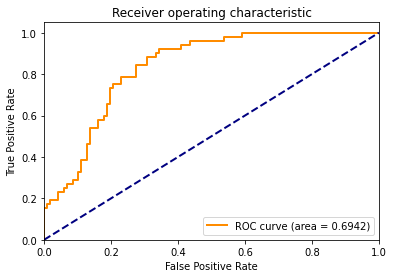

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


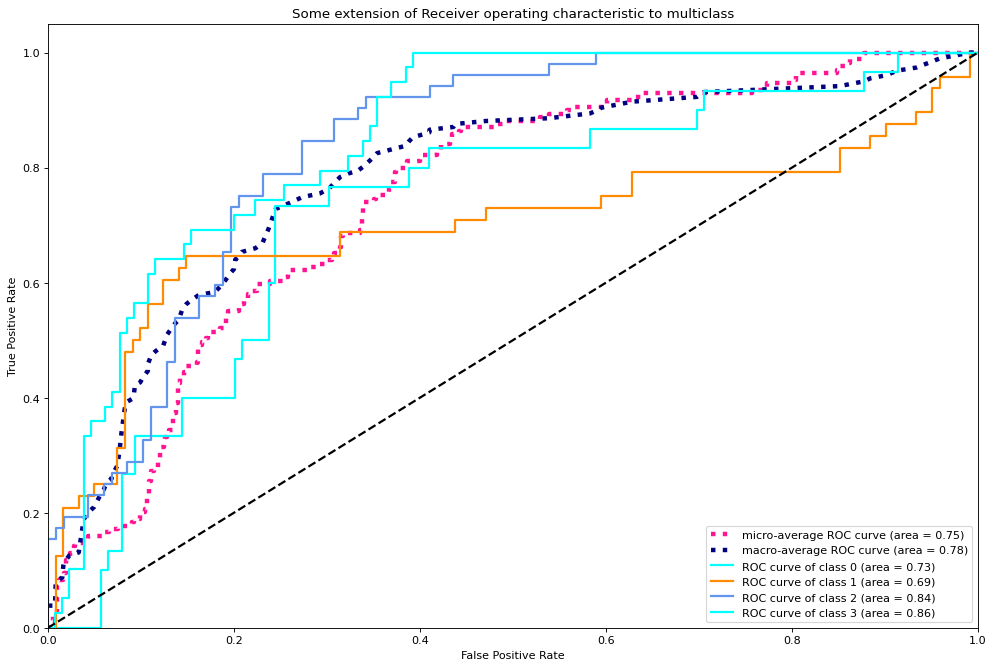

              precision    recall  f1-score   support

           0       0.36      0.40      0.38        30
           1       0.66      0.52      0.58        48
           2       0.89      0.15      0.26        52
           3       0.44      1.00      0.61        39

    accuracy                           0.50       169
   macro avg       0.59      0.52      0.46       169
weighted avg       0.63      0.50      0.45       169


Model name: Naive Bayes, calibration algo: sigmoid


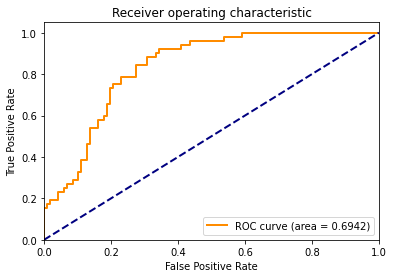

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


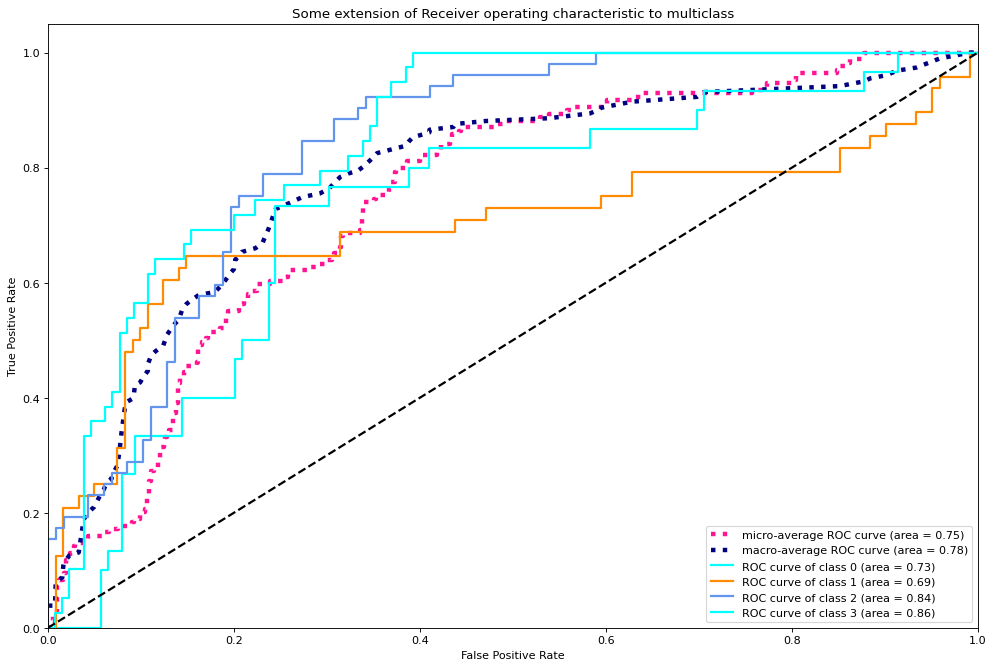

              precision    recall  f1-score   support

           0       0.30      0.47      0.36        30
           1       0.62      0.31      0.42        48
           2       0.73      0.37      0.49        52
           3       0.47      0.87      0.61        39

    accuracy                           0.49       169
   macro avg       0.53      0.50      0.47       169
weighted avg       0.56      0.49      0.47       169


Model name: Naive Bayes, calibration algo: isotonic


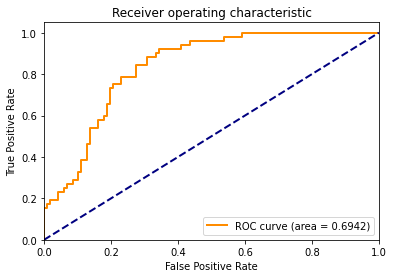

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


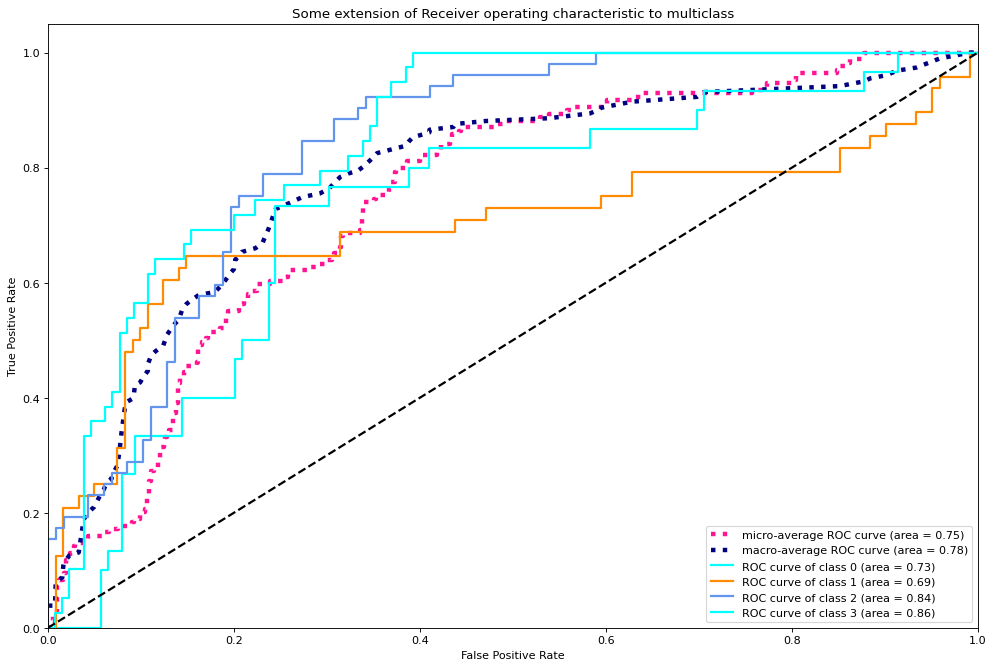

              precision    recall  f1-score   support

           0       0.37      0.37      0.37        30
           1       0.71      0.60      0.65        48
           2       0.71      0.62      0.66        52
           3       0.58      0.79      0.67        39

    accuracy                           0.61       169
   macro avg       0.59      0.60      0.59       169
weighted avg       0.62      0.61      0.61       169


Model name: Naive Bayes, calibration algo: sigmoid cv


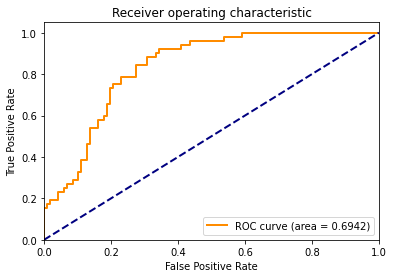

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


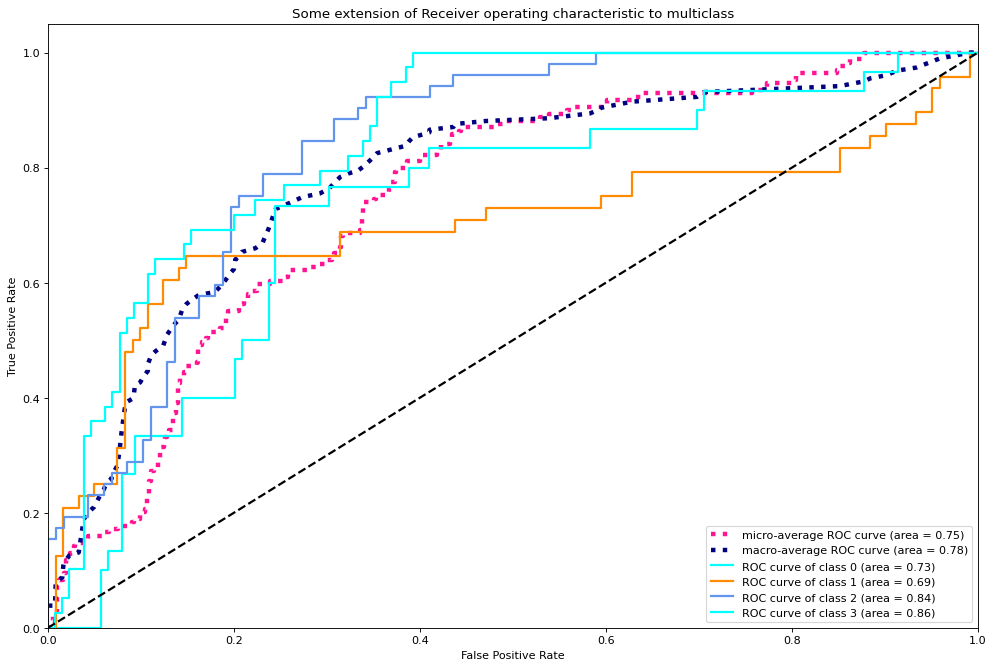

              precision    recall  f1-score   support

           0       0.36      0.60      0.45        30
           1       0.68      0.31      0.43        48
           2       0.67      0.23      0.34        52
           3       0.43      0.87      0.58        39

    accuracy                           0.47       169
   macro avg       0.53      0.50      0.45       169
weighted avg       0.56      0.47      0.44       169


Model name: Naive Bayes, calibration algo: isotonic cv


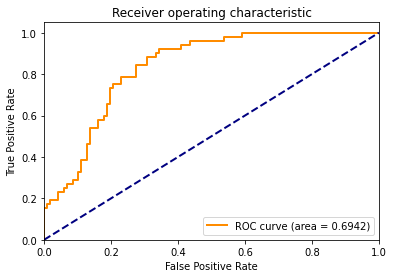

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


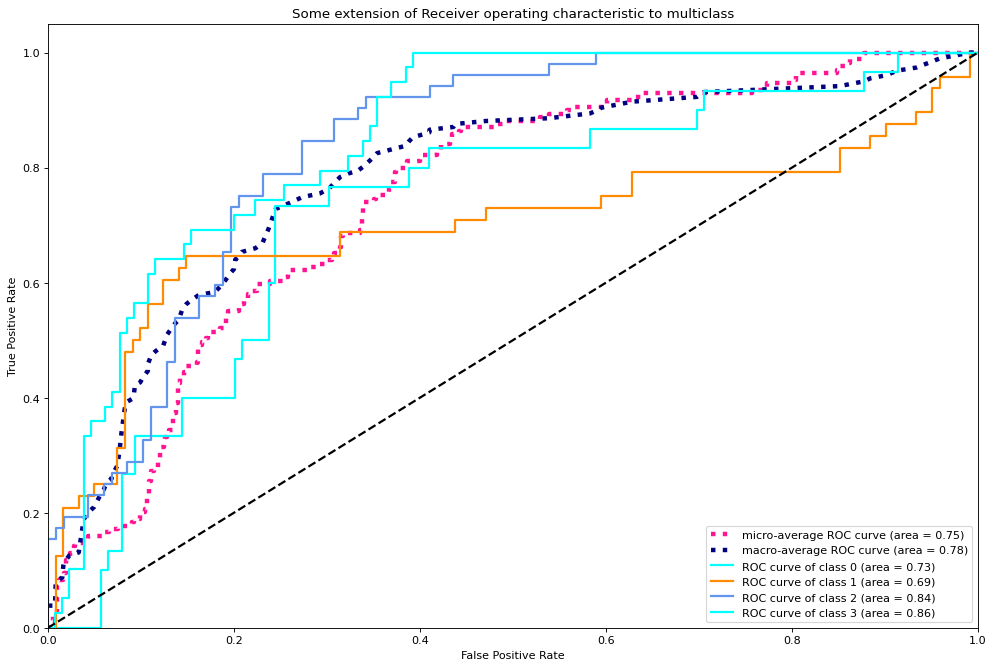

              precision    recall  f1-score   support

           0       0.36      0.50      0.42        30
           1       0.69      0.42      0.52        48
           2       0.63      0.50      0.56        52
           3       0.54      0.79      0.65        39

    accuracy                           0.54       169
   macro avg       0.56      0.55      0.54       169
weighted avg       0.58      0.54      0.54       169


Model name: Naive Bayes, calibration algo: ivap


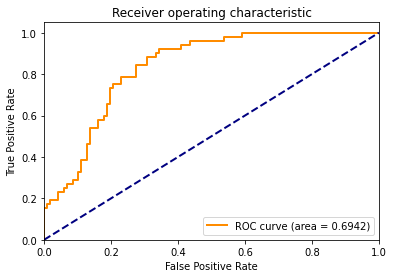

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


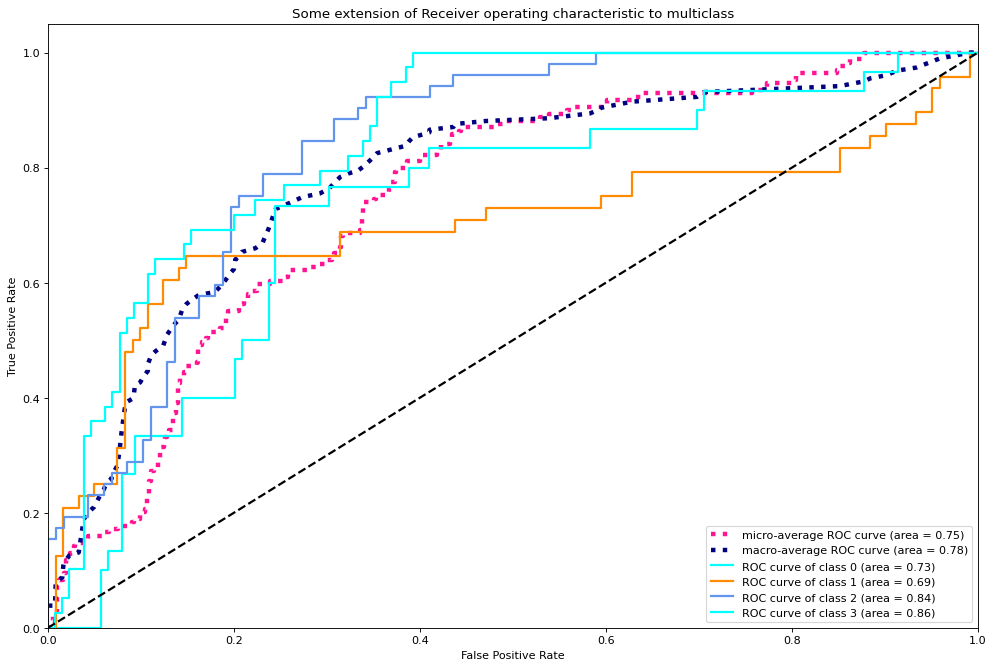

              precision    recall  f1-score   support

           0       0.33      0.30      0.32        30
           1       0.66      0.60      0.63        48
           2       0.73      0.62      0.67        52
           3       0.59      0.82      0.69        39

    accuracy                           0.60       169
   macro avg       0.58      0.59      0.58       169
weighted avg       0.61      0.60      0.60       169


Model name: Naive Bayes, calibration algo: cvap


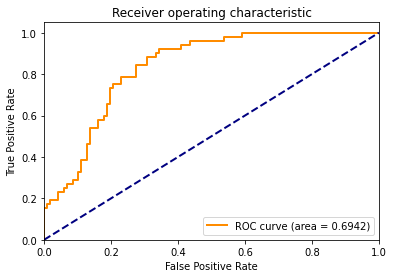

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


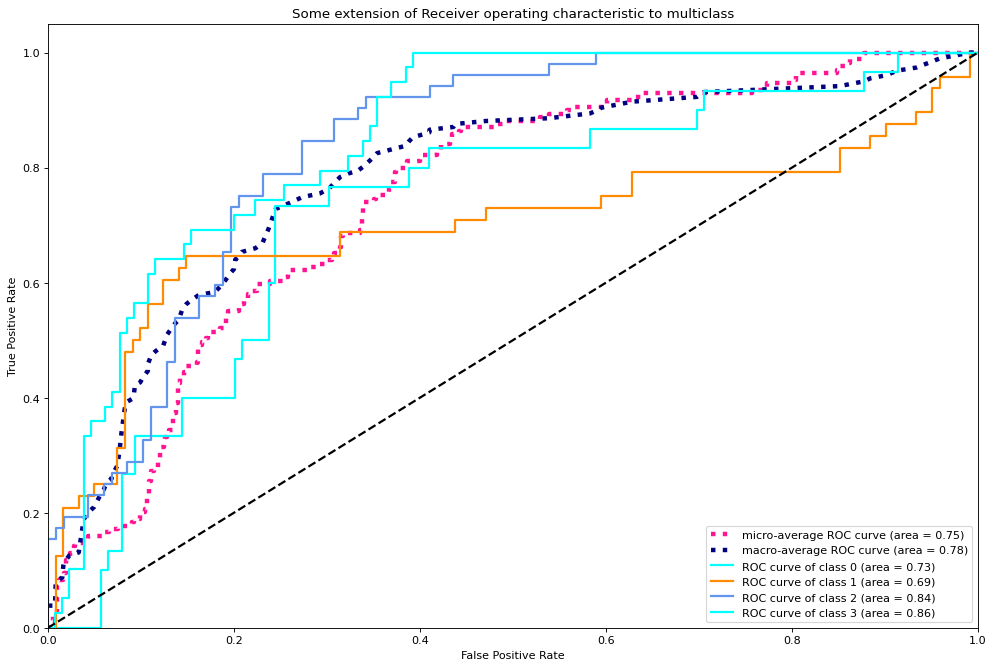

              precision    recall  f1-score   support

           0       0.36      0.47      0.41        30
           1       0.67      0.42      0.51        48
           2       0.69      0.65      0.67        52
           3       0.61      0.79      0.69        39

    accuracy                           0.59       169
   macro avg       0.58      0.58      0.57       169
weighted avg       0.61      0.59      0.58       169



In [58]:
clf_NB = GaussianNB()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_NB, model_name = 'Naive Bayes')

In [59]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                                NaN       NaN       NaN         NaN   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                             NaN       NaN       NaN  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [60]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                                NaN       NaN       NaN         NaN   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                             NaN       NaN       NaN  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

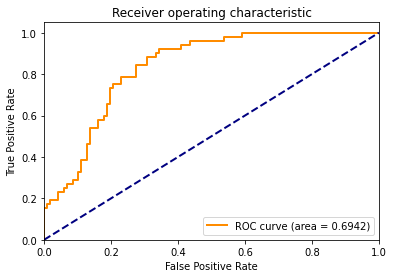

[[[118  21]
  [ 18  12]]

 [[108  13]
  [ 23  25]]

 [[116   1]
  [ 44   8]]

 [[ 80  50]
  [  0  39]]]


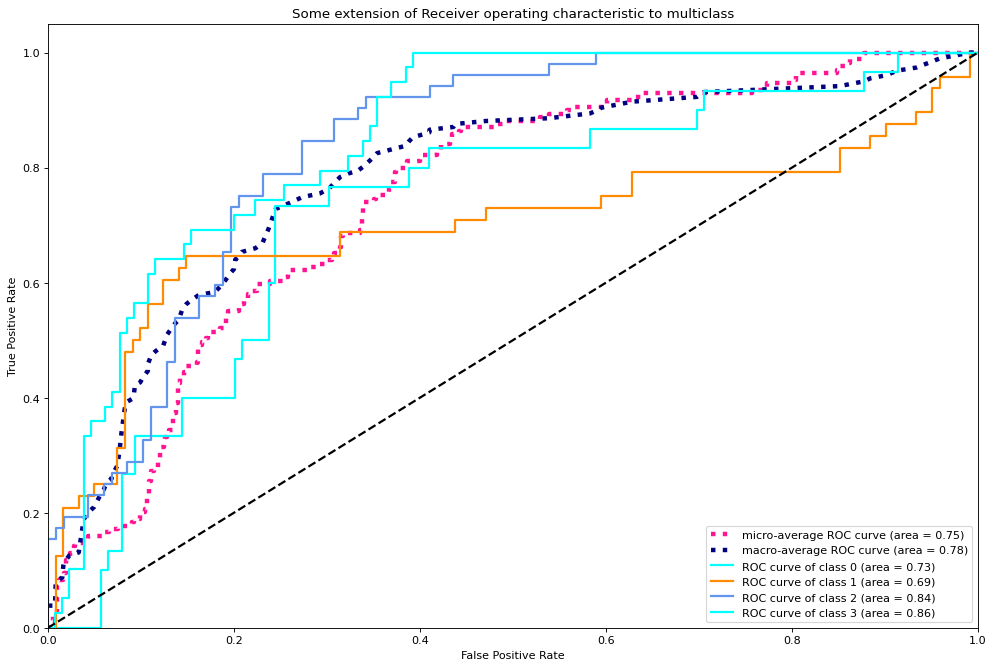

In [61]:

plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

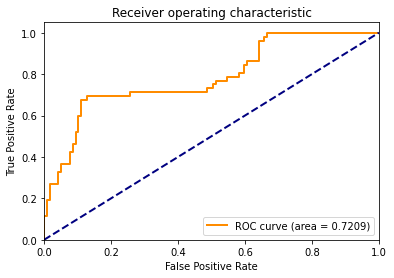

[[[106  33]
  [ 16  14]]

 [[112   9]
  [ 33  15]]

 [[110   7]
  [ 33  19]]

 [[ 92  38]
  [  5  34]]]


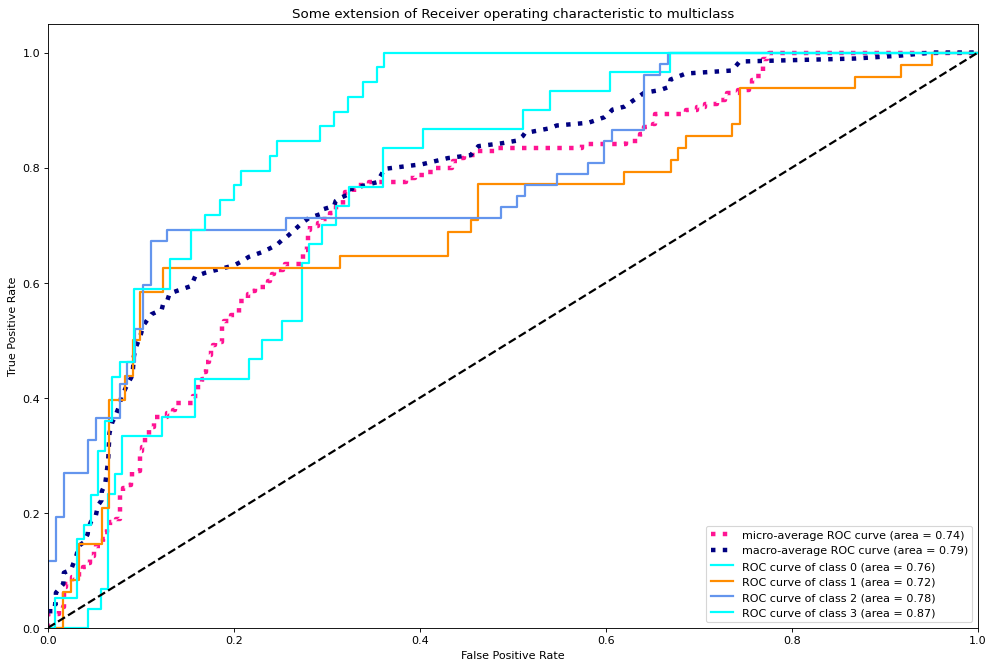

In [62]:

plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### KNN Classifier


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: KNN, calibration algo: no calibration


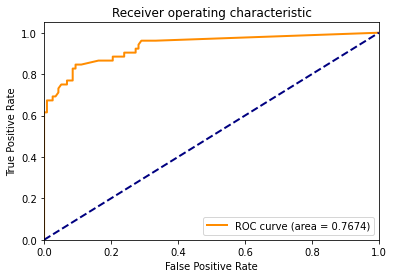

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


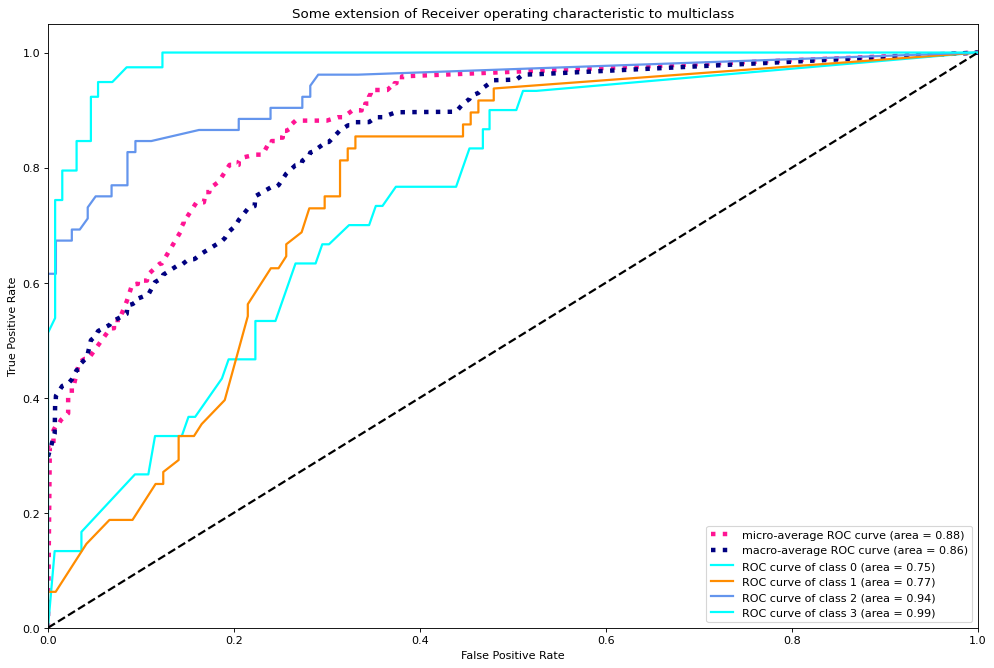

              precision    recall  f1-score   support

           0       0.34      0.37      0.35        30
           1       0.44      0.40      0.42        48
           2       0.83      0.75      0.79        52
           3       0.79      0.95      0.86        39

    accuracy                           0.63       169
   macro avg       0.60      0.62      0.61       169
weighted avg       0.62      0.63      0.62       169


Model name: KNN, calibration algo: sigmoid


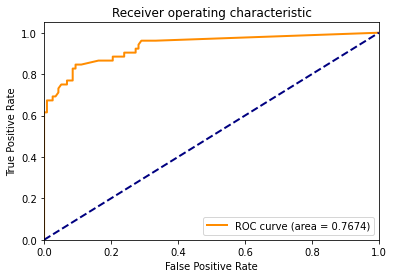

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


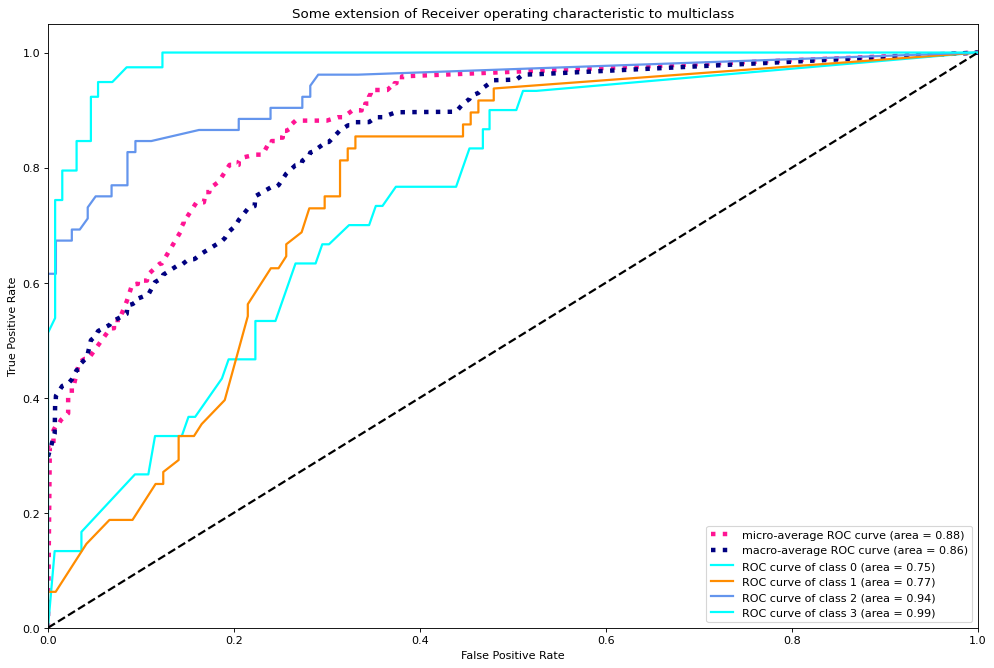

              precision    recall  f1-score   support

           0       0.22      0.27      0.24        30
           1       0.43      0.42      0.42        48
           2       0.86      0.73      0.79        52
           3       0.81      0.87      0.84        39

    accuracy                           0.59       169
   macro avg       0.58      0.57      0.57       169
weighted avg       0.61      0.59      0.60       169


Model name: KNN, calibration algo: isotonic


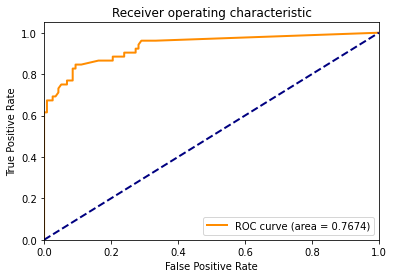

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


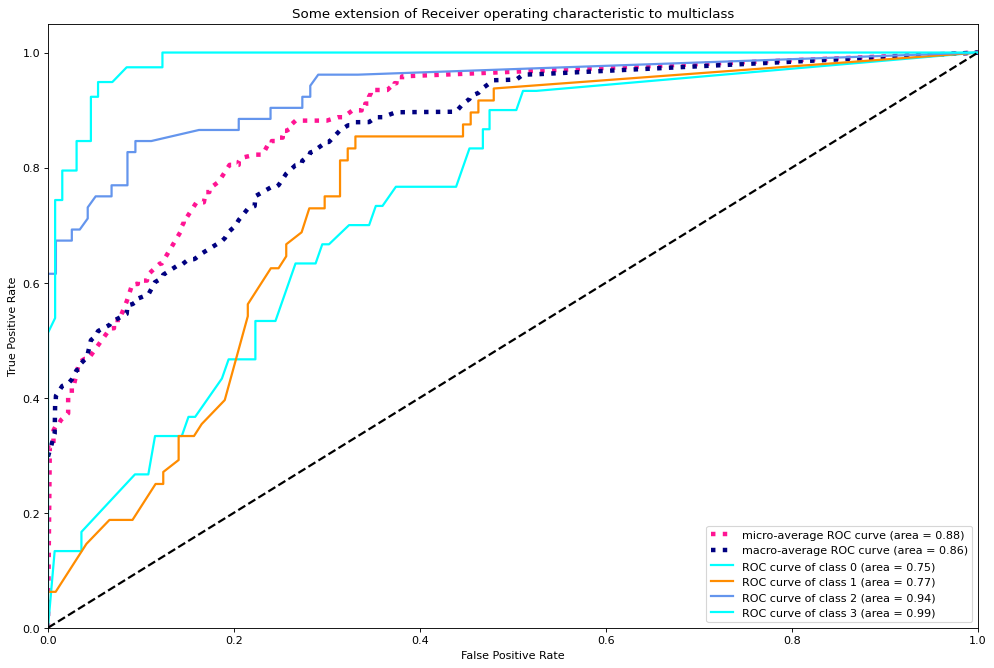

              precision    recall  f1-score   support

           0       0.27      0.27      0.27        30
           1       0.46      0.56      0.50        48
           2       0.85      0.67      0.75        52
           3       0.79      0.79      0.79        39

    accuracy                           0.60       169
   macro avg       0.59      0.57      0.58       169
weighted avg       0.62      0.60      0.61       169


Model name: KNN, calibration algo: sigmoid cv


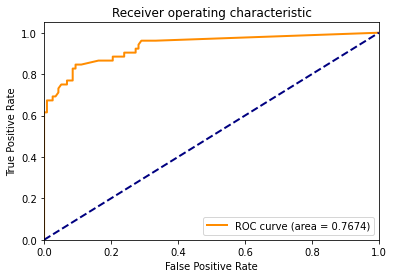

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


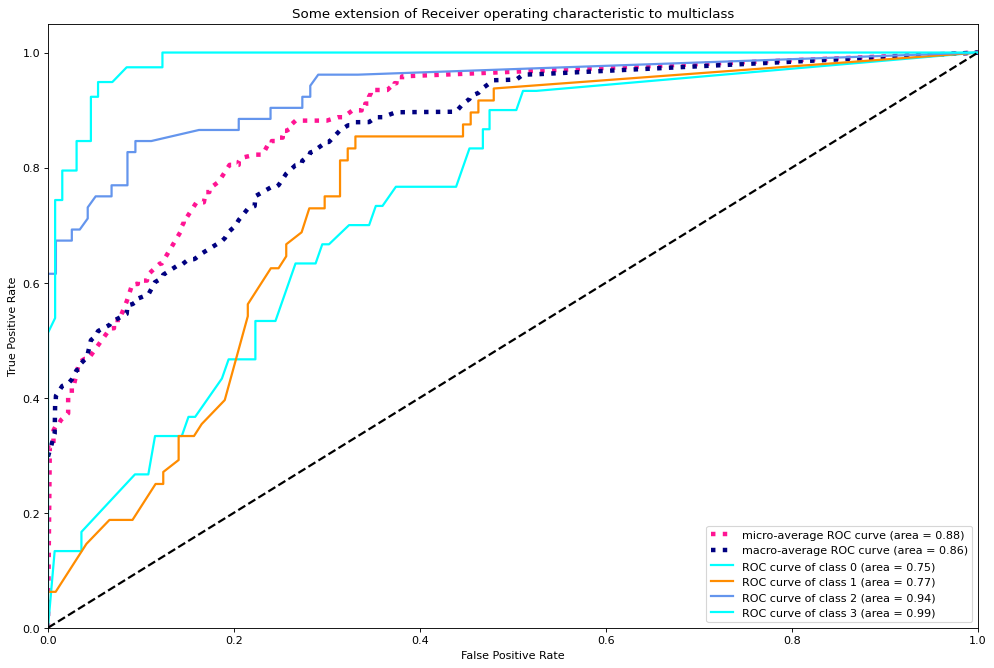

              precision    recall  f1-score   support

           0       0.31      0.37      0.34        30
           1       0.47      0.35      0.40        48
           2       0.82      0.79      0.80        52
           3       0.77      0.95      0.85        39

    accuracy                           0.63       169
   macro avg       0.59      0.61      0.60       169
weighted avg       0.62      0.63      0.62       169


Model name: KNN, calibration algo: isotonic cv


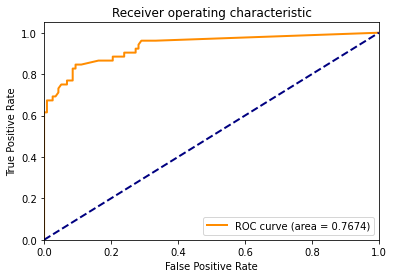

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


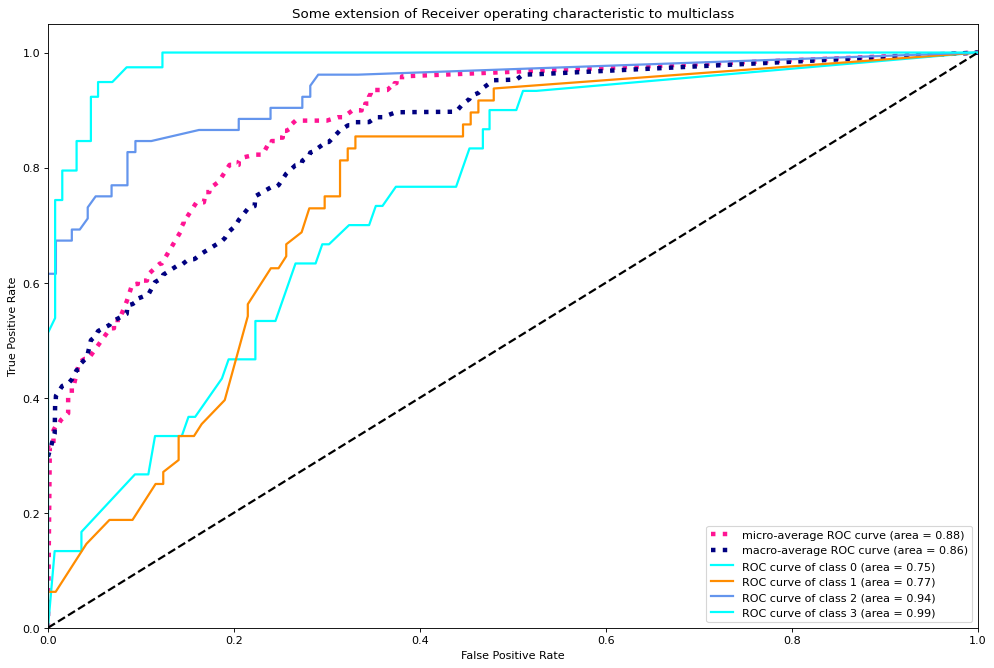

              precision    recall  f1-score   support

           0       0.35      0.43      0.39        30
           1       0.49      0.40      0.44        48
           2       0.85      0.77      0.81        52
           3       0.80      0.95      0.87        39

    accuracy                           0.64       169
   macro avg       0.62      0.64      0.63       169
weighted avg       0.65      0.64      0.64       169


Model name: KNN, calibration algo: ivap


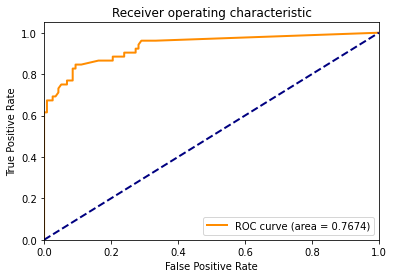

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


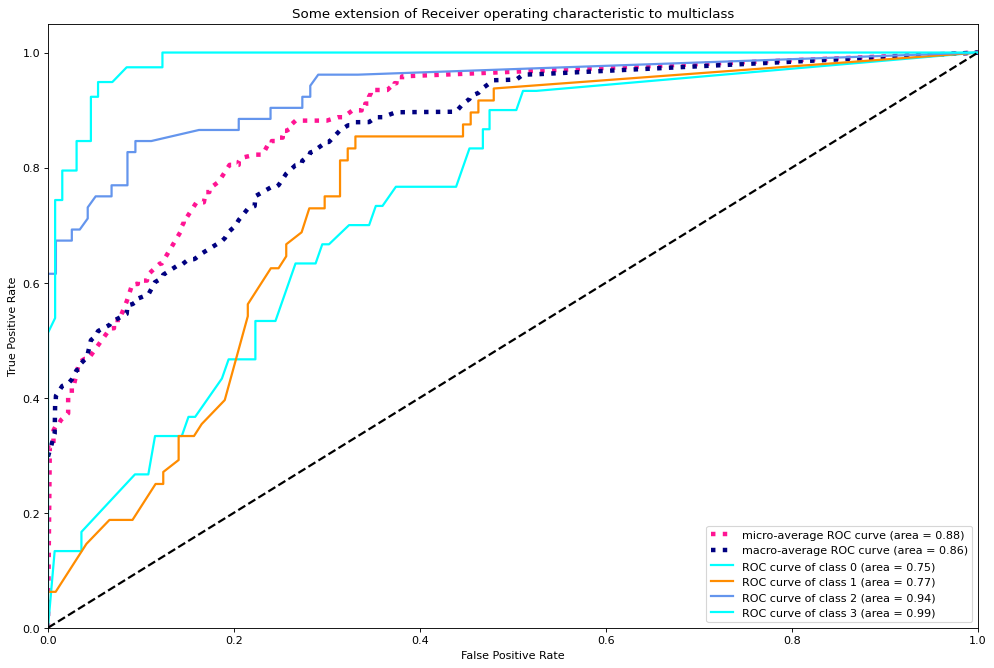

              precision    recall  f1-score   support

           0       0.23      0.30      0.26        30
           1       0.42      0.40      0.41        48
           2       0.90      0.67      0.77        52
           3       0.76      0.90      0.82        39

    accuracy                           0.58       169
   macro avg       0.58      0.57      0.57       169
weighted avg       0.61      0.58      0.59       169


Model name: KNN, calibration algo: cvap


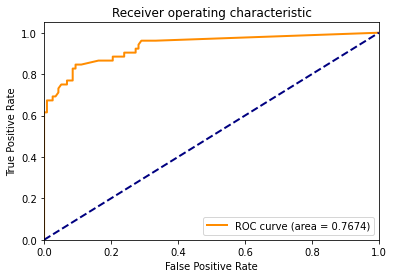

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


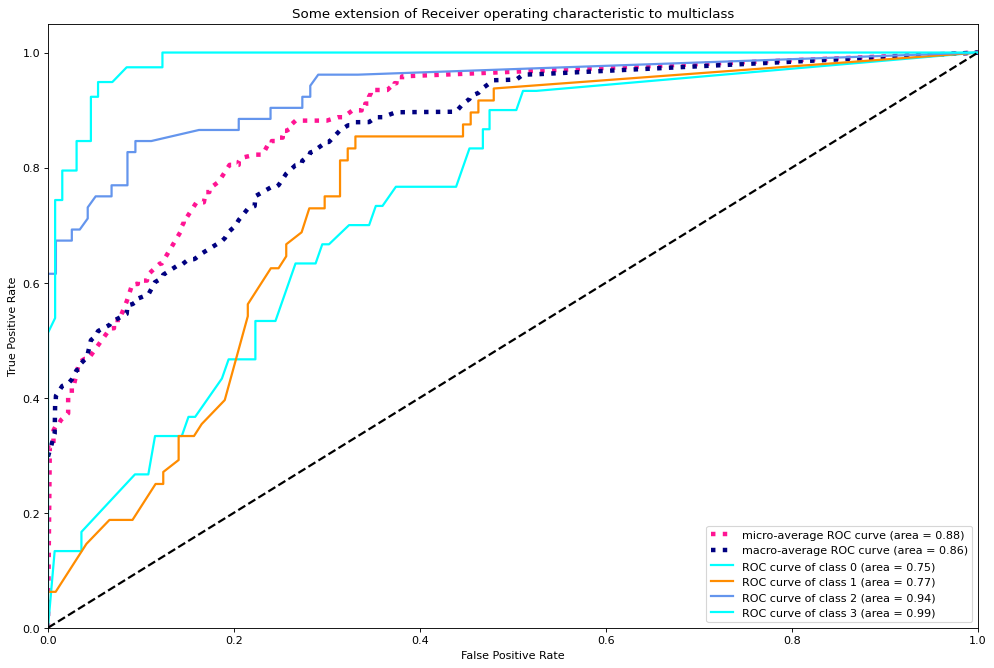

              precision    recall  f1-score   support

           0       0.33      0.43      0.37        30
           1       0.50      0.40      0.44        48
           2       0.87      0.77      0.82        52
           3       0.82      0.95      0.88        39

    accuracy                           0.64       169
   macro avg       0.63      0.64      0.63       169
weighted avg       0.66      0.64      0.65       169



In [63]:
clf_KNN = KNeighborsClassifier()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_KNN, 
                    model_name = 'KNN')

In [64]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [65]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

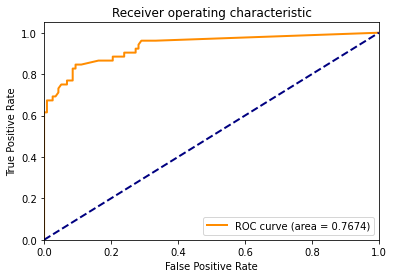

[[[118  21]
  [ 19  11]]

 [[ 97  24]
  [ 29  19]]

 [[109   8]
  [ 13  39]]

 [[120  10]
  [  2  37]]]


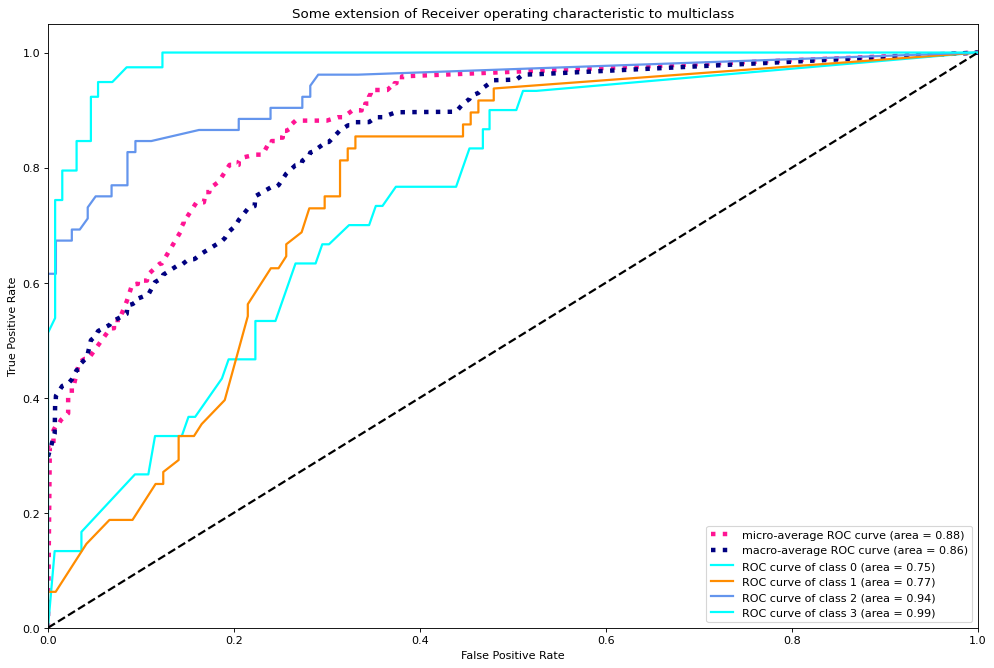

In [66]:

plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

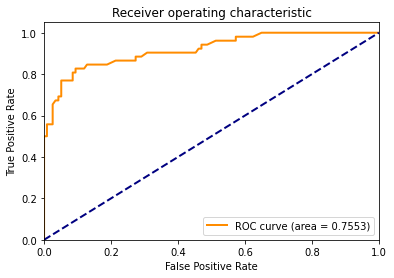

[[[111  28]
  [ 22   8]]

 [[ 94  27]
  [ 28  20]]

 [[111   6]
  [ 14  38]]

 [[122   8]
  [  5  34]]]


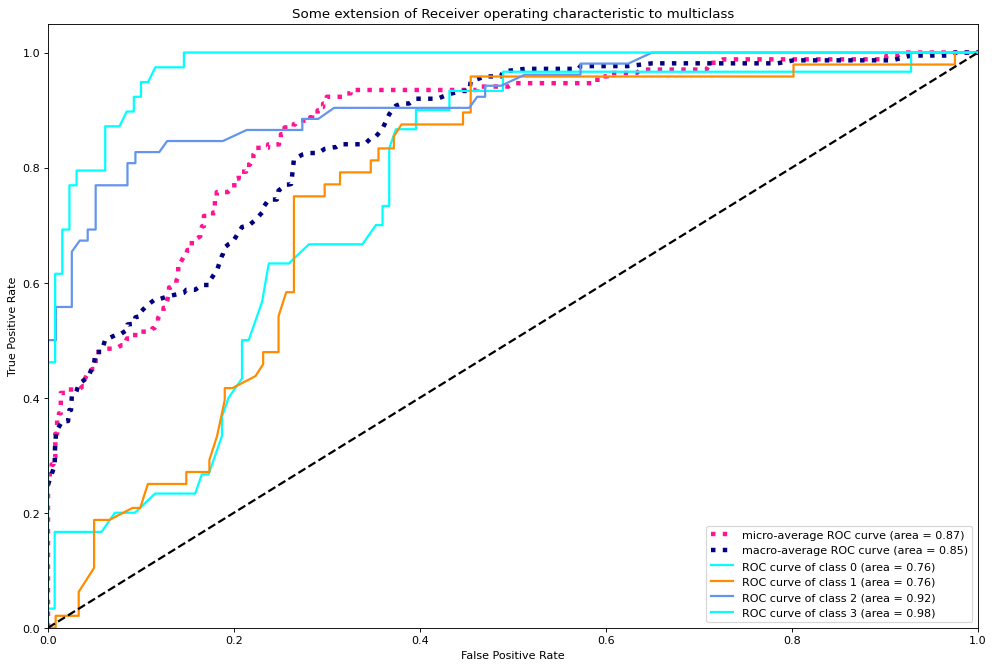

In [67]:

plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### Support Vector Machine


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: Support Vector Machine, calibration algo: no calibration


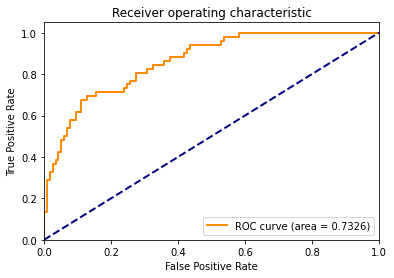

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


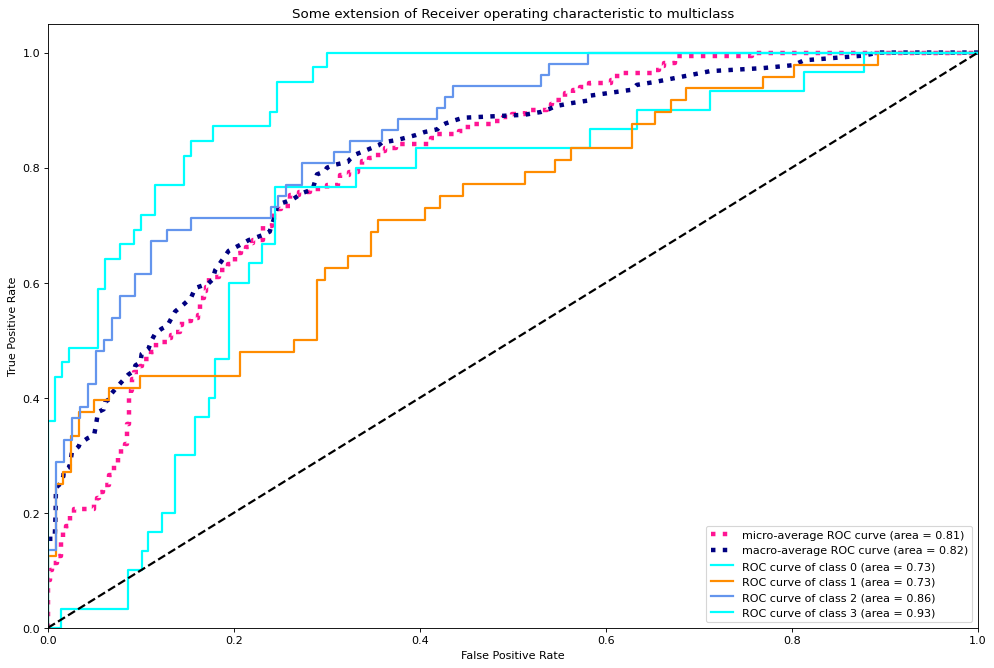

              precision    recall  f1-score   support

           0       0.34      0.77      0.47        30
           1       0.00      0.00      0.00        48
           2       0.73      0.62      0.67        52
           3       0.60      0.90      0.72        39

    accuracy                           0.53       169
   macro avg       0.42      0.57      0.47       169
weighted avg       0.42      0.53      0.46       169


Model name: Support Vector Machine, calibration algo: sigmoid


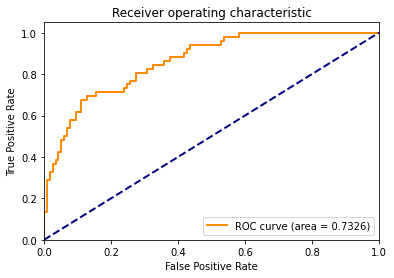

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


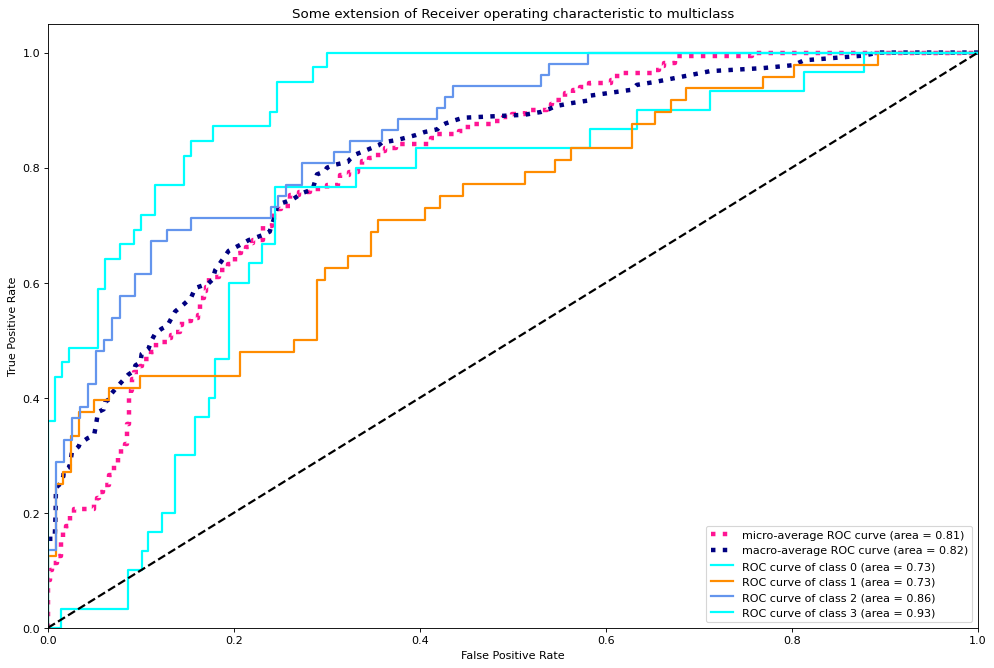

              precision    recall  f1-score   support

           0       0.29      0.33      0.31        30
           1       0.47      0.40      0.43        48
           2       0.70      0.44      0.54        52
           3       0.57      0.90      0.70        39

    accuracy                           0.51       169
   macro avg       0.51      0.52      0.50       169
weighted avg       0.53      0.51      0.51       169


Model name: Support Vector Machine, calibration algo: isotonic


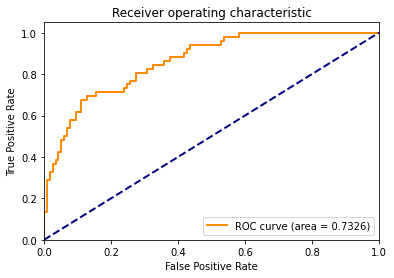

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


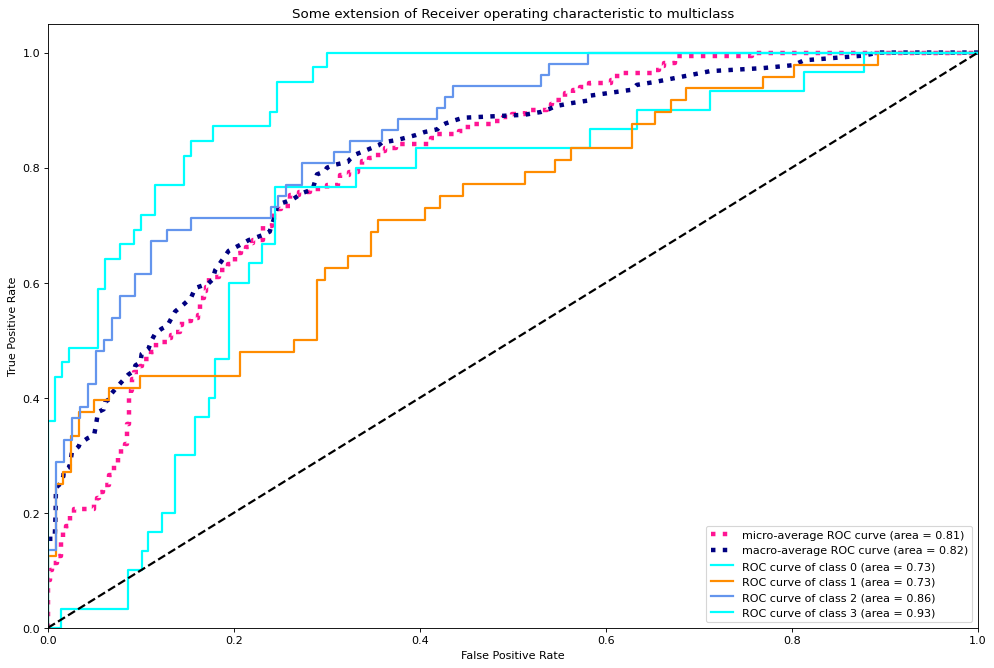

              precision    recall  f1-score   support

           0       0.22      0.43      0.29        30
           1       0.37      0.21      0.27        48
           2       0.84      0.50      0.63        52
           3       0.69      0.90      0.78        39

    accuracy                           0.50       169
   macro avg       0.53      0.51      0.49       169
weighted avg       0.56      0.50      0.50       169


Model name: Support Vector Machine, calibration algo: sigmoid cv


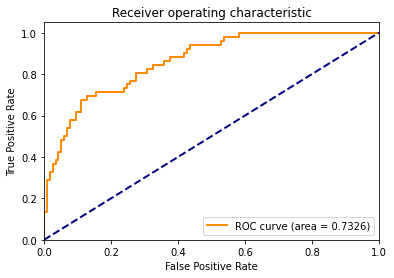

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


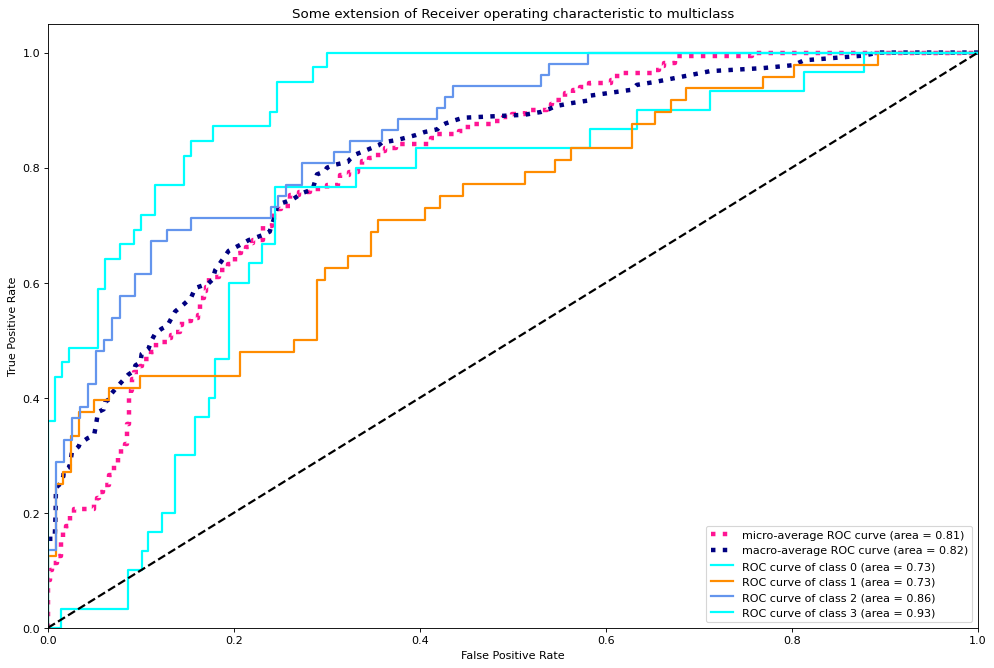

              precision    recall  f1-score   support

           0       0.30      0.40      0.34        30
           1       0.50      0.29      0.37        48
           2       0.69      0.56      0.62        52
           3       0.58      0.87      0.69        39

    accuracy                           0.53       169
   macro avg       0.52      0.53      0.51       169
weighted avg       0.54      0.53      0.52       169


Model name: Support Vector Machine, calibration algo: isotonic cv


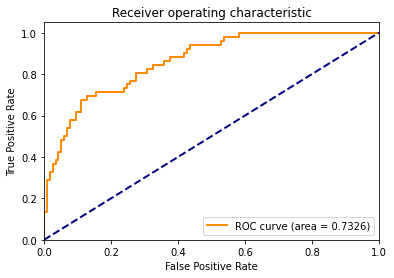

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


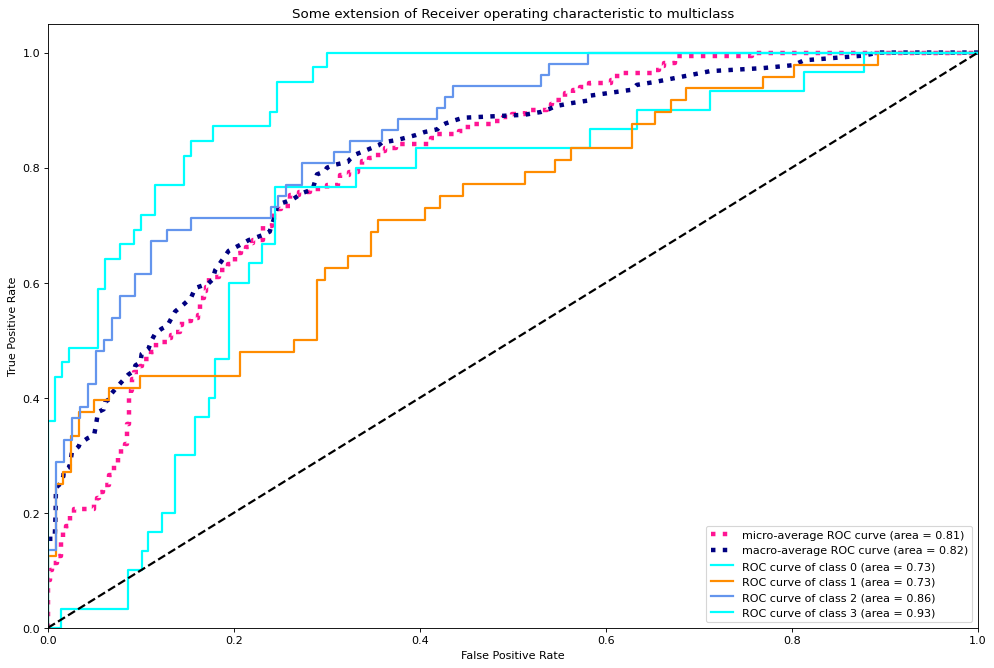

              precision    recall  f1-score   support

           0       0.25      0.37      0.30        30
           1       0.45      0.31      0.37        48
           2       0.70      0.54      0.61        52
           3       0.63      0.85      0.73        39

    accuracy                           0.51       169
   macro avg       0.51      0.52      0.50       169
weighted avg       0.54      0.51      0.51       169


Model name: Support Vector Machine, calibration algo: ivap


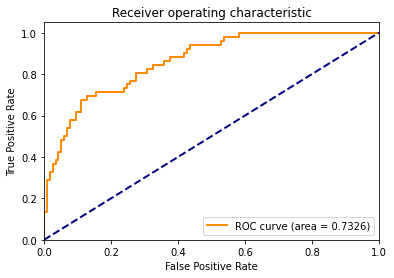

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


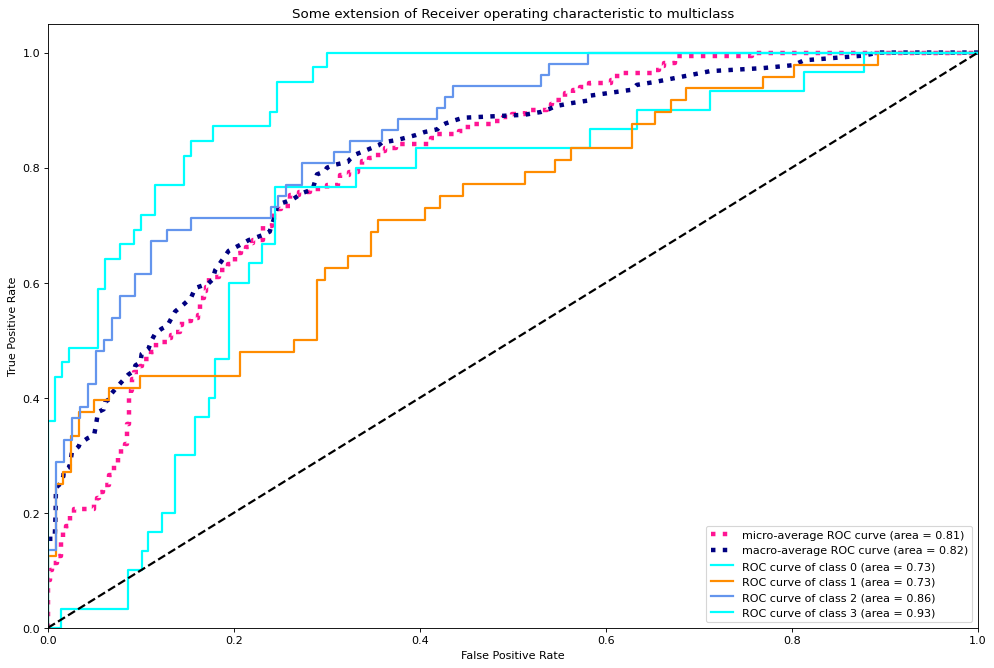

              precision    recall  f1-score   support

           0       0.29      0.43      0.35        30
           1       0.44      0.35      0.39        48
           2       0.88      0.58      0.70        52
           3       0.67      0.87      0.76        39

    accuracy                           0.56       169
   macro avg       0.57      0.56      0.55       169
weighted avg       0.60      0.56      0.56       169


Model name: Support Vector Machine, calibration algo: cvap


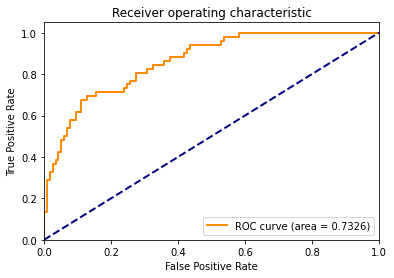

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


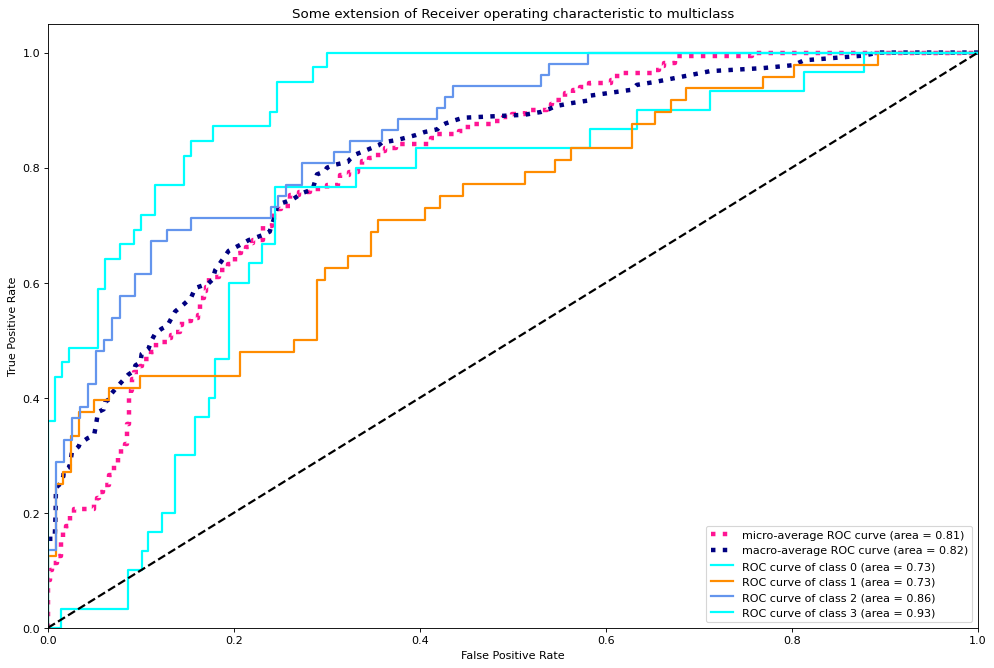

              precision    recall  f1-score   support

           0       0.25      0.47      0.33        30
           1       0.23      0.10      0.14        48
           2       0.82      0.60      0.69        52
           3       0.65      0.90      0.75        39

    accuracy                           0.50       169
   macro avg       0.49      0.52      0.48       169
weighted avg       0.51      0.50      0.48       169



In [68]:
clf_SVC = SVC(probability=True, random_state=42)


[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_SVC, 
                    model_name = 'Support Vector Machine')

In [69]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [70]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine        0.143695  0.156565  0.155171    0.147535   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine     0.142952  0.151094  0.143437  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

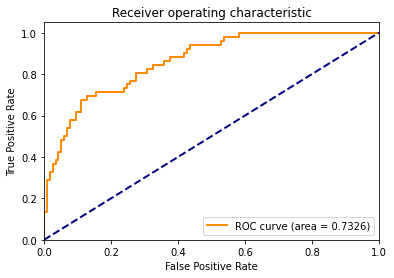

[[[ 95  44]
  [  7  23]]

 [[121   0]
  [ 48   0]]

 [[105  12]
  [ 20  32]]

 [[107  23]
  [  4  35]]]


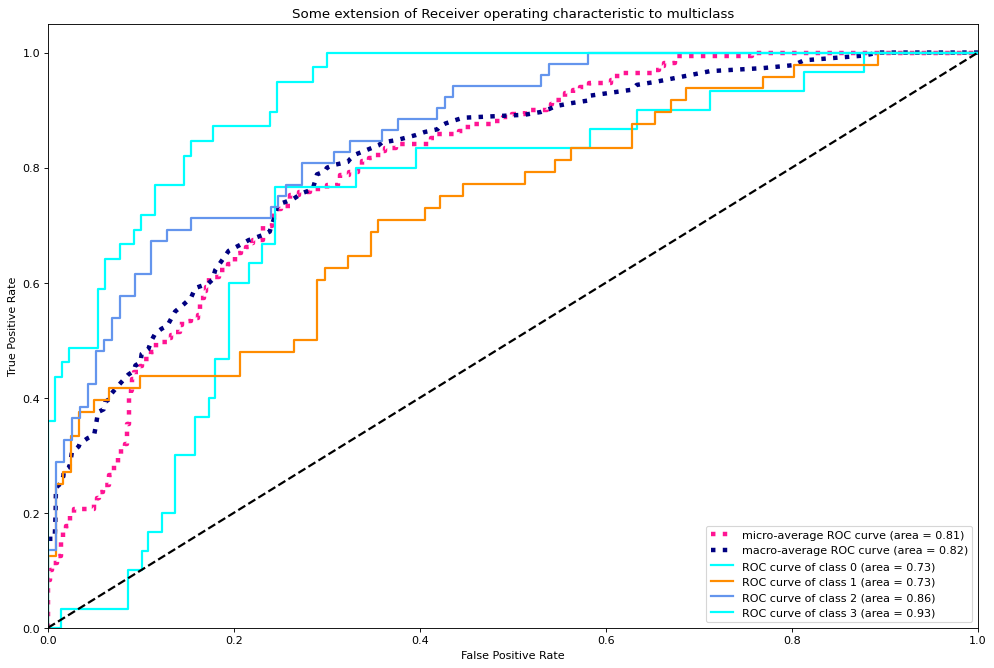

In [71]:
plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

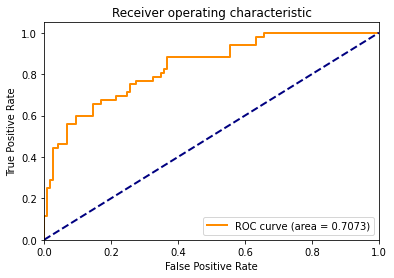

[[[114  25]
  [ 20  10]]

 [[100  21]
  [ 29  19]]

 [[107  10]
  [ 29  23]]

 [[104  26]
  [  4  35]]]


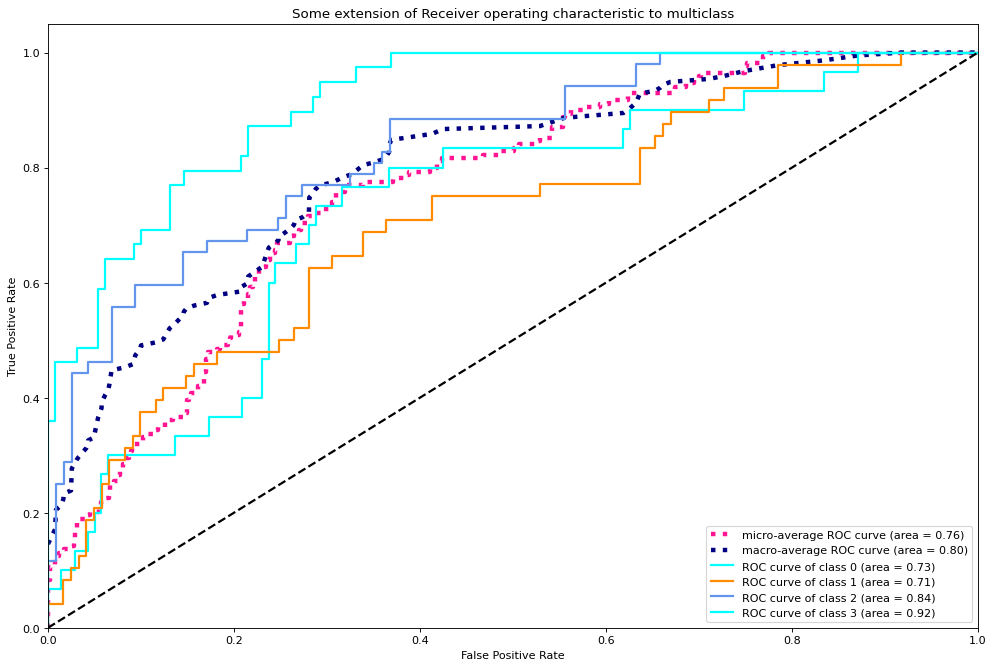

In [72]:
plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### Logistic Regression


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: logistic regression, calibration algo: no calibration


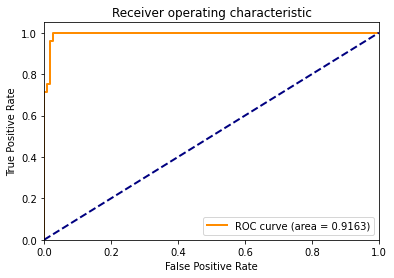

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


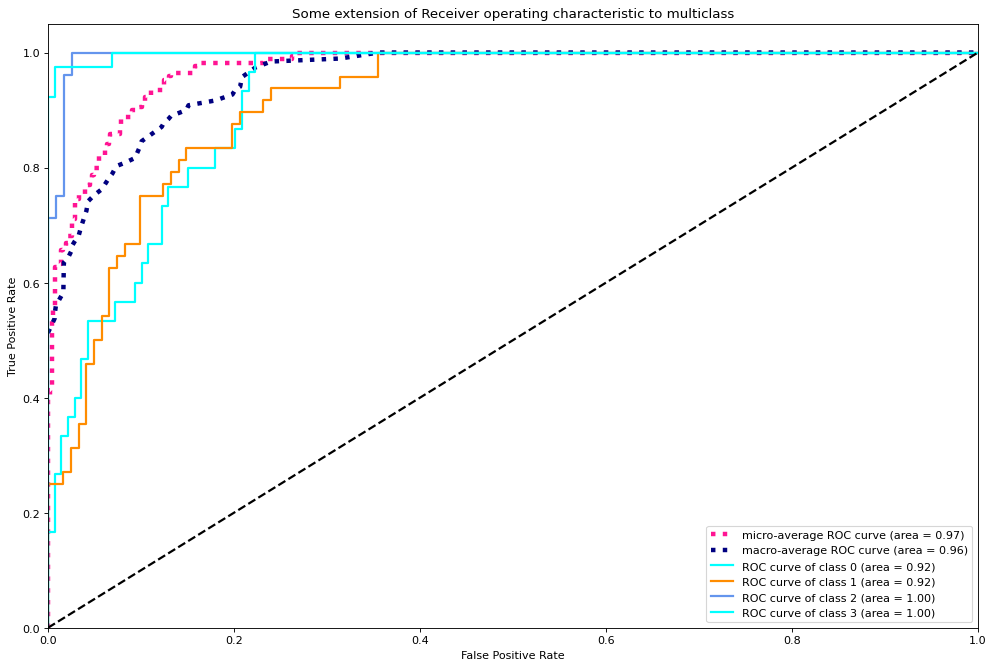

              precision    recall  f1-score   support

           0       0.58      0.70      0.64        30
           1       0.78      0.60      0.68        48
           2       0.93      1.00      0.96        52
           3       0.95      0.97      0.96        39

    accuracy                           0.83       169
   macro avg       0.81      0.82      0.81       169
weighted avg       0.83      0.83      0.83       169


Model name: logistic regression, calibration algo: sigmoid


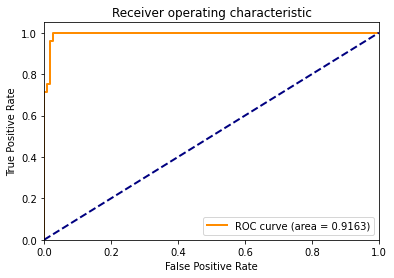

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


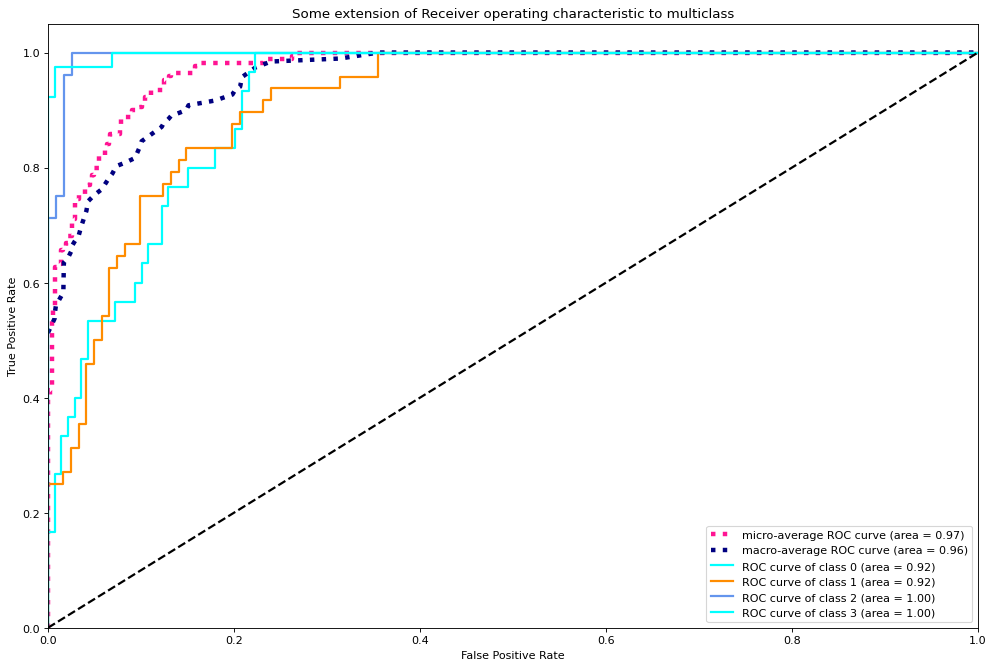

              precision    recall  f1-score   support

           0       0.58      0.83      0.68        30
           1       0.83      0.52      0.64        48
           2       0.93      1.00      0.96        52
           3       0.95      0.97      0.96        39

    accuracy                           0.83       169
   macro avg       0.82      0.83      0.81       169
weighted avg       0.84      0.83      0.82       169


Model name: logistic regression, calibration algo: isotonic


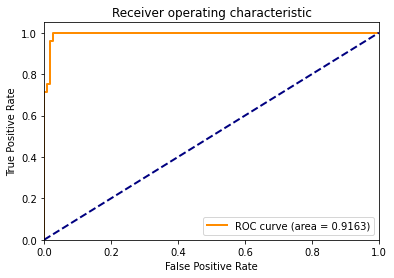

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


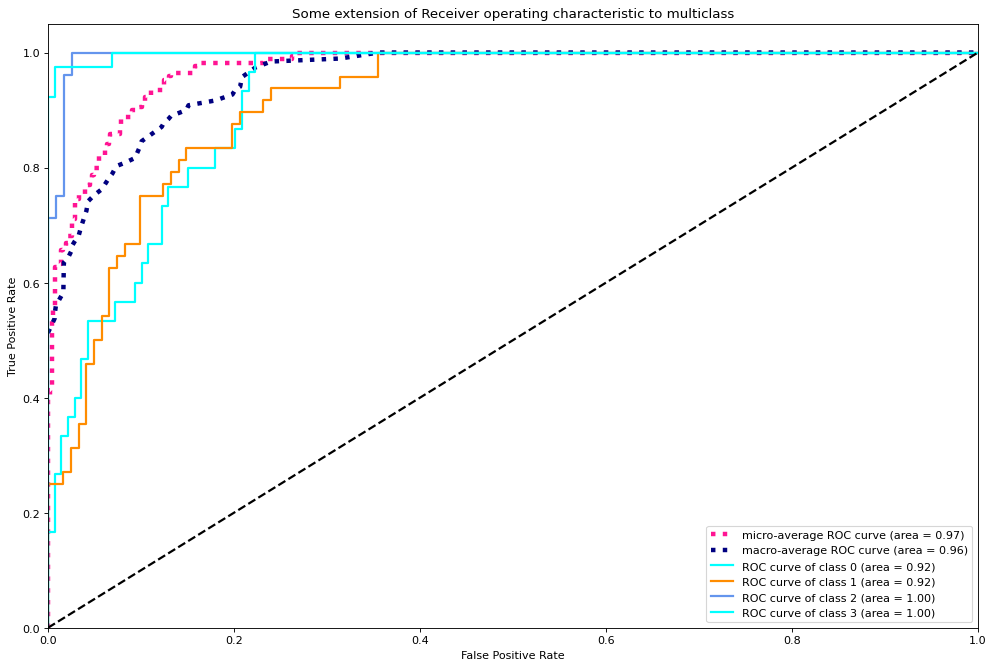

              precision    recall  f1-score   support

           0       0.54      0.87      0.67        30
           1       0.85      0.46      0.59        48
           2       0.93      0.98      0.95        52
           3       0.95      0.97      0.96        39

    accuracy                           0.81       169
   macro avg       0.82      0.82      0.79       169
weighted avg       0.84      0.81      0.80       169


Model name: logistic regression, calibration algo: sigmoid cv


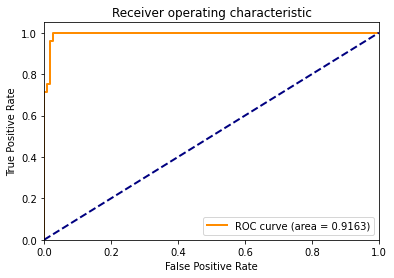

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


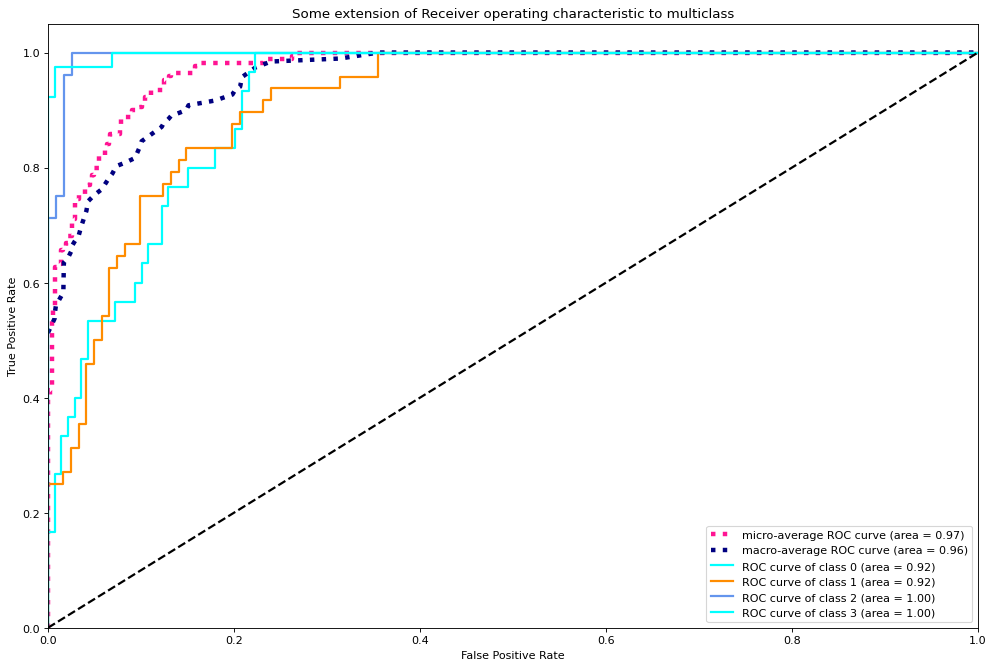

              precision    recall  f1-score   support

           0       0.57      0.70      0.63        30
           1       0.76      0.54      0.63        48
           2       0.91      1.00      0.95        52
           3       0.93      0.97      0.95        39

    accuracy                           0.81       169
   macro avg       0.79      0.80      0.79       169
weighted avg       0.81      0.81      0.80       169


Model name: logistic regression, calibration algo: isotonic cv


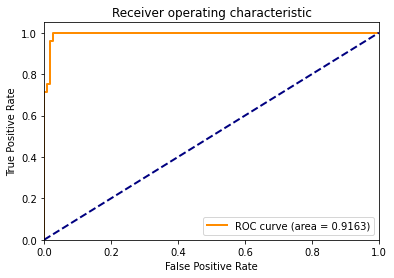

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


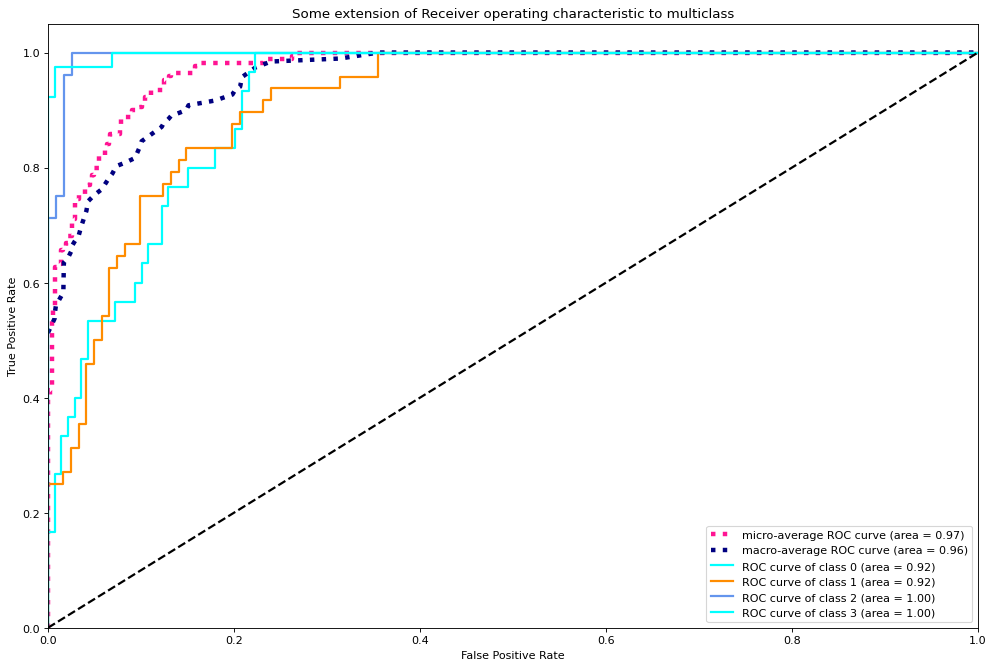

              precision    recall  f1-score   support

           0       0.53      0.77      0.63        30
           1       0.81      0.52      0.63        48
           2       0.95      1.00      0.97        52
           3       0.95      0.97      0.96        39

    accuracy                           0.82       169
   macro avg       0.81      0.82      0.80       169
weighted avg       0.83      0.82      0.81       169


Model name: logistic regression, calibration algo: ivap


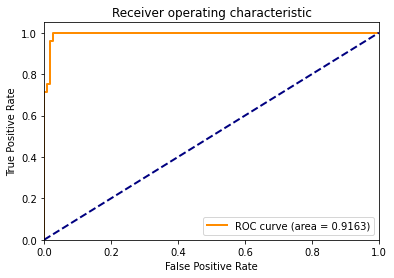

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


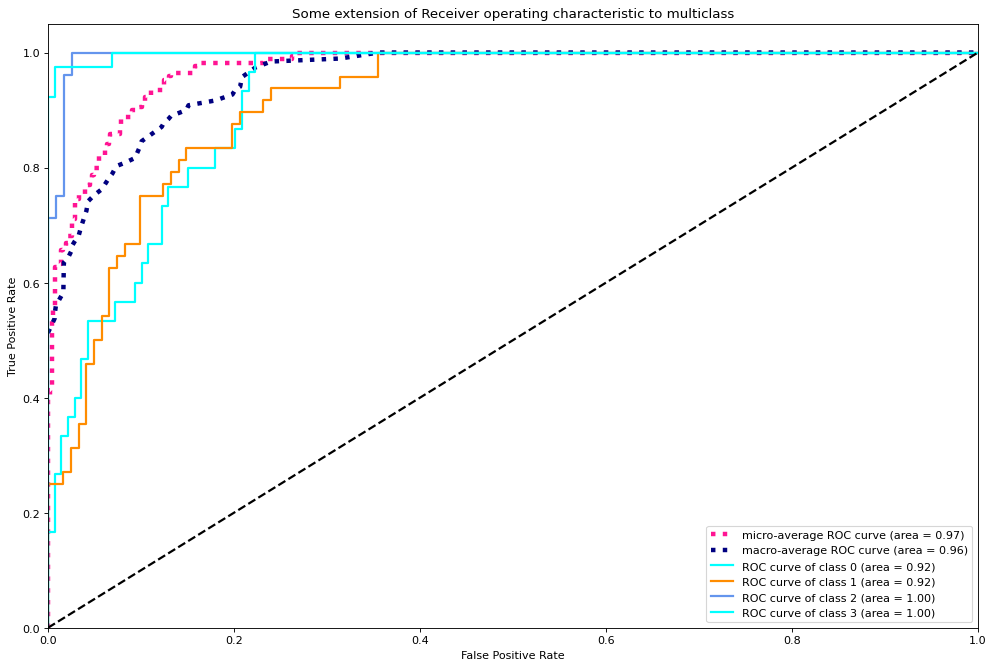

              precision    recall  f1-score   support

           0       0.52      0.77      0.62        30
           1       0.77      0.50      0.61        48
           2       0.94      0.94      0.94        52
           3       0.93      1.00      0.96        39

    accuracy                           0.80       169
   macro avg       0.79      0.80      0.78       169
weighted avg       0.82      0.80      0.80       169


Model name: logistic regression, calibration algo: cvap


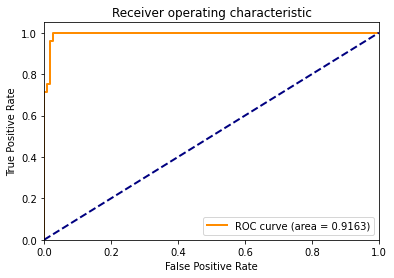

[[[124  15]
  [  9  21]]

 [[113   8]
  [ 19  29]]

 [[113   4]
  [  0  52]]

 [[128   2]
  [  1  38]]]


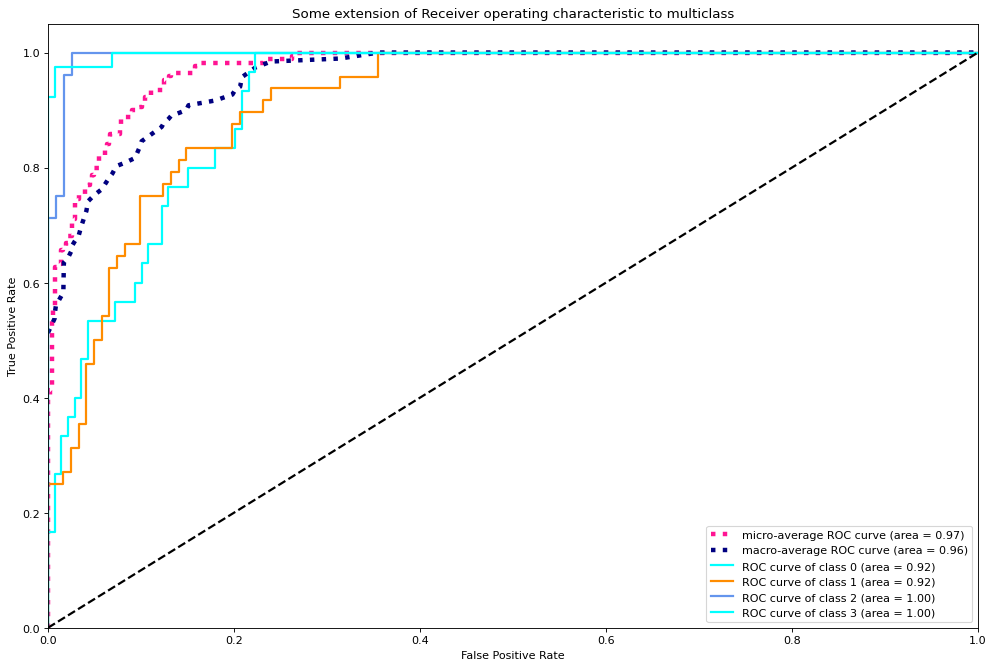

              precision    recall  f1-score   support

           0       0.53      0.70      0.60        30
           1       0.76      0.54      0.63        48
           2       0.94      0.98      0.96        52
           3       0.93      0.97      0.95        39

    accuracy                           0.80       169
   macro avg       0.79      0.80      0.79       169
weighted avg       0.81      0.80      0.80       169



In [73]:
# fit base model on the proper training dataset
clf_LR = LogisticRegression(solver = 'liblinear', random_state=42)

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_LR, 
                    model_name = 'logistic regression')

In [74]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression           0.183455  0.222439  0.695285    0.216654   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression        0.360456  0.232770  0.231629  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [75]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine        0.143695  0.156565  0.155171    0.147535   
logistic regression           0.058953  0.067401  0.061614    0.066145   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine     0.142952  0.151094  0.143437  
logistic regression        0.059098  0.068273  0.067803  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### Neural Network


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: neural network, calibration algo: no calibration


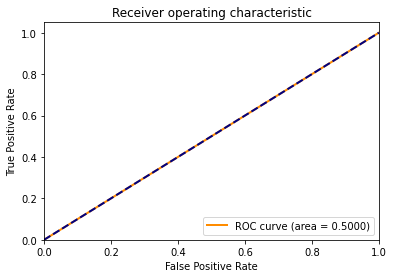

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


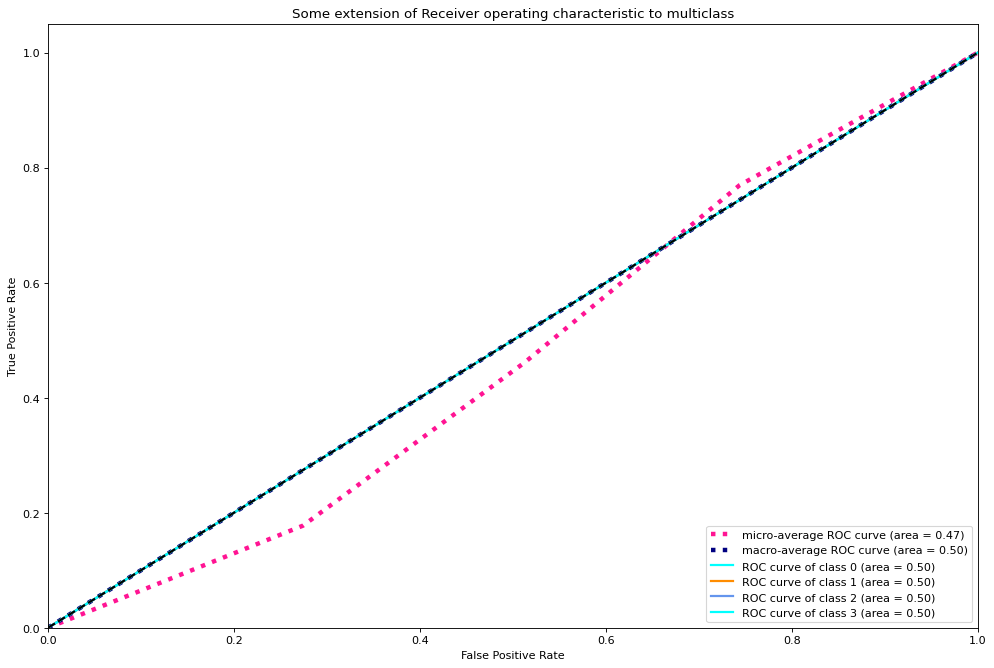

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169


Model name: neural network, calibration algo: sigmoid


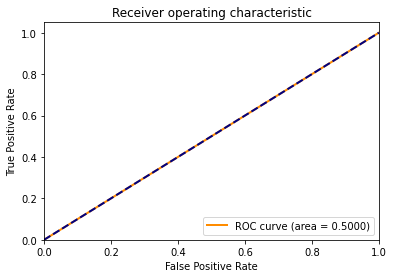

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


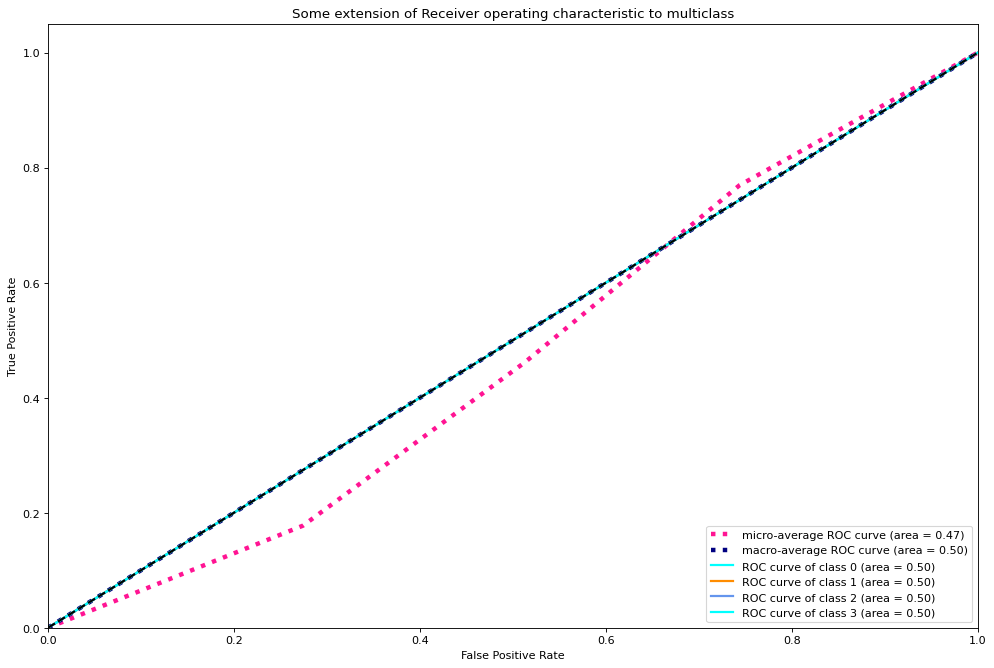

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169


Model name: neural network, calibration algo: isotonic


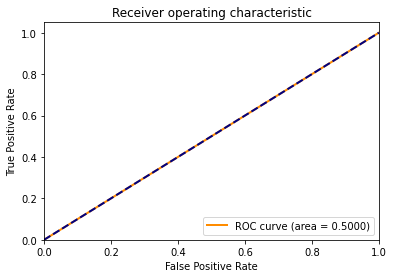

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


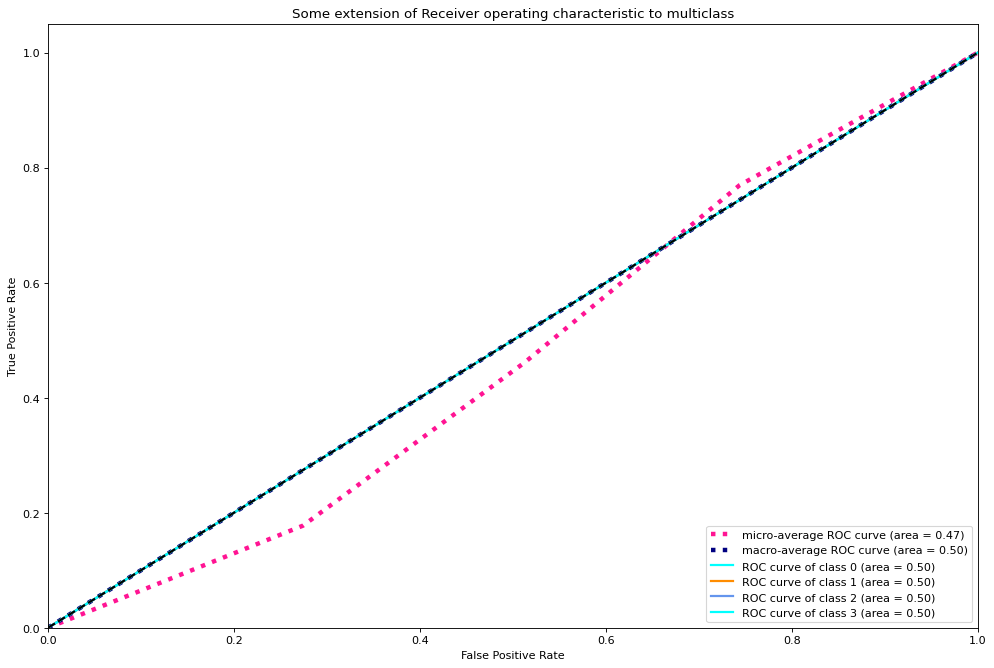

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169


Model name: neural network, calibration algo: sigmoid cv


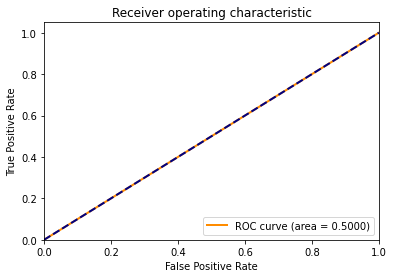

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


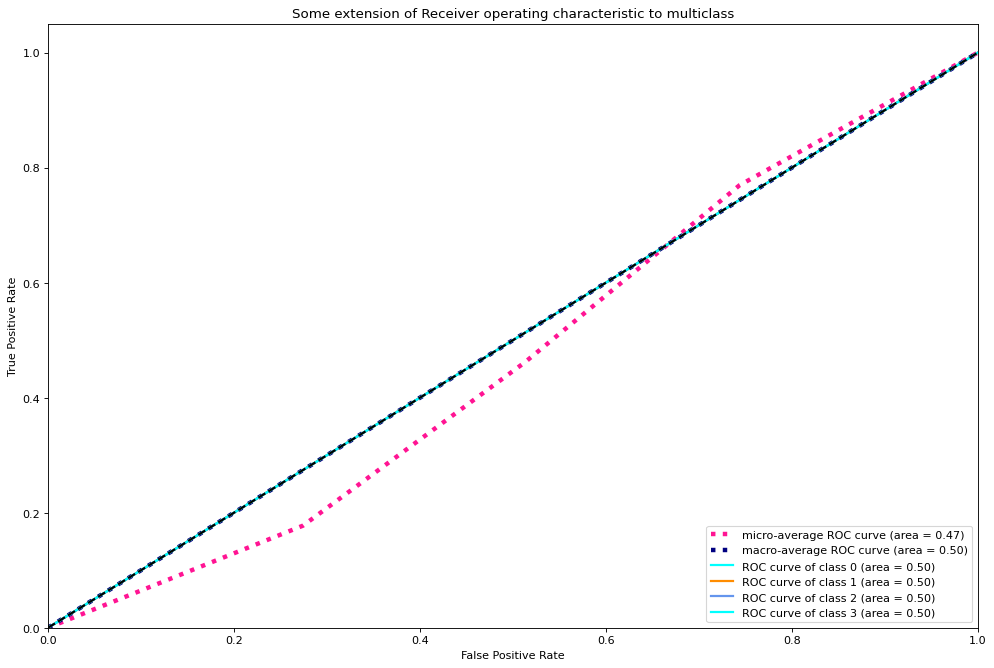

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169


Model name: neural network, calibration algo: isotonic cv


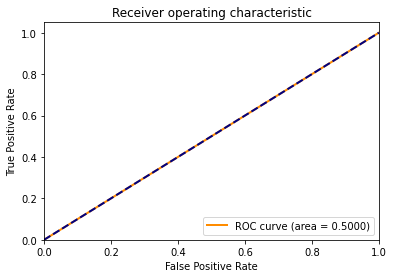

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


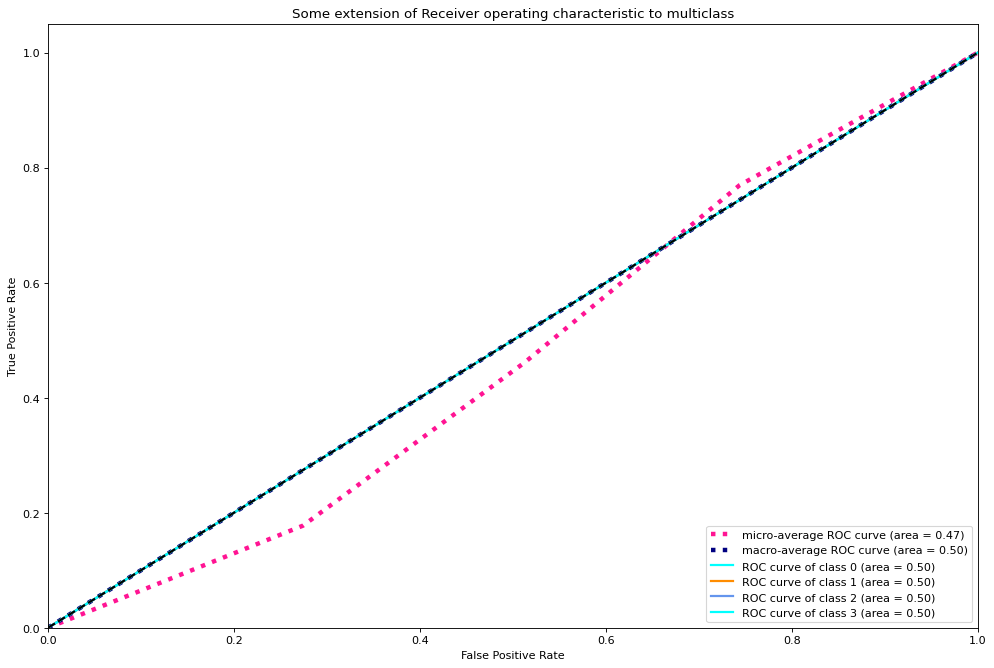

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169


Model name: neural network, calibration algo: ivap


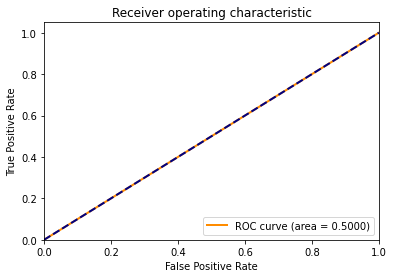

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


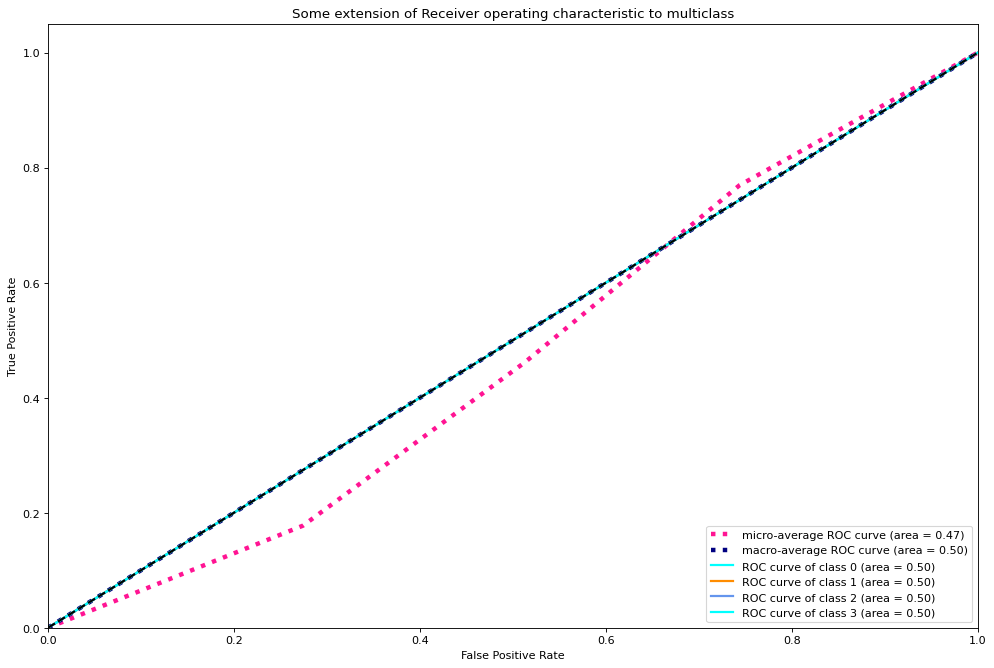

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169


Model name: neural network, calibration algo: cvap


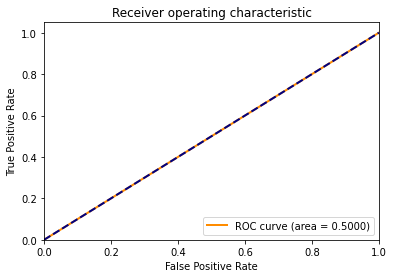

[[[  0 139]
  [  0  30]]

 [[121   0]
  [ 48   0]]

 [[117   0]
  [ 52   0]]

 [[130   0]
  [ 39   0]]]


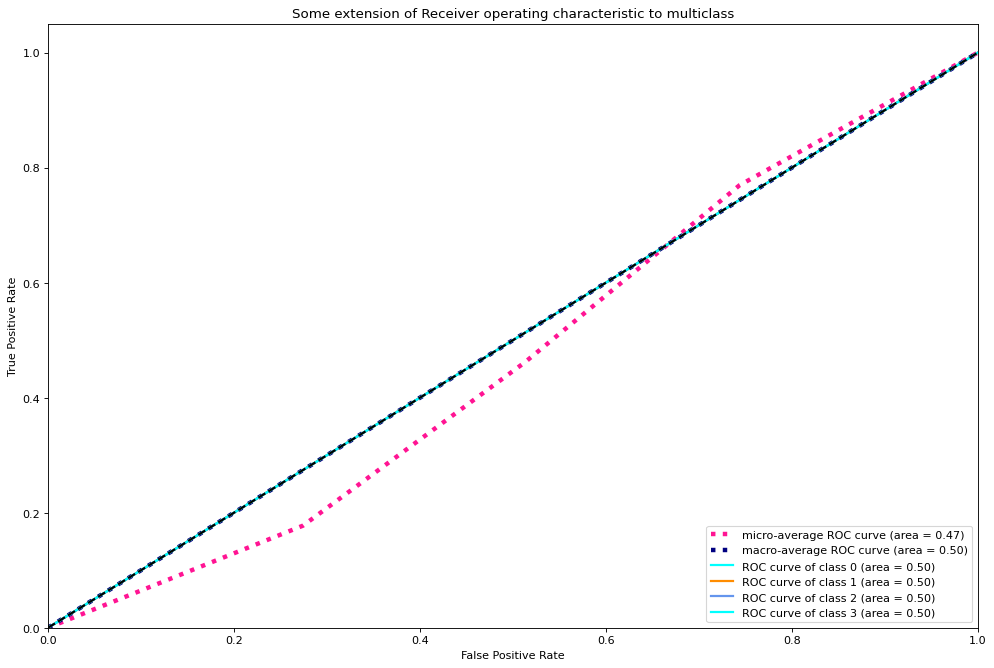

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        30
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39

    accuracy                           0.18       169
   macro avg       0.04      0.25      0.08       169
weighted avg       0.03      0.18      0.05       169



In [76]:
# fit base model on the proper training dataset
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_MLP, 
                    model_name = 'neural network')

In [77]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression           0.183455  0.222439  0.695285    0.216654   
neural network                0.564518  0.579015  0.579074    0.564507   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression        0.360456  0.232770  0.231629  
neural network             0.564515  0.569252  0.563419  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [78]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine        0.143695  0.156565  0.155171    0.147535   
logistic regression           0.058953  0.067401  0.061614    0.066145   
neural network                0.188338  0.193652  0.193673    0.188334   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine     0.142952  0.151094  0.143437  
logistic regression        0.059098  0.068273  0.067803  
neural network             0.188337  0.190084  0.187912  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### Random Forest


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: Random Forest, calibration algo: no calibration


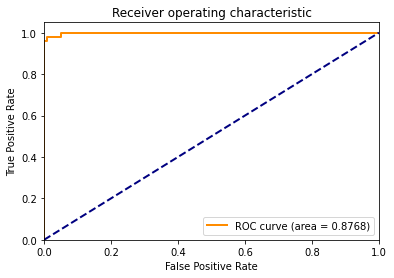

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


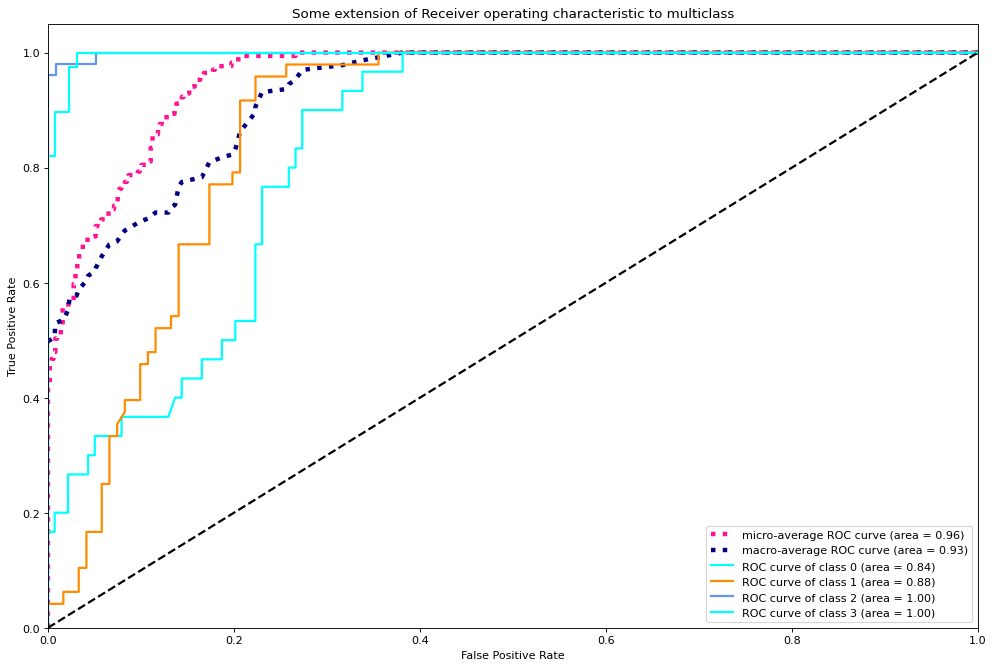

              precision    recall  f1-score   support

           0       0.41      0.40      0.41        30
           1       0.62      0.60      0.61        48
           2       1.00      0.96      0.98        52
           3       0.88      0.97      0.93        39

    accuracy                           0.76       169
   macro avg       0.73      0.74      0.73       169
weighted avg       0.76      0.76      0.76       169


Model name: Random Forest, calibration algo: sigmoid


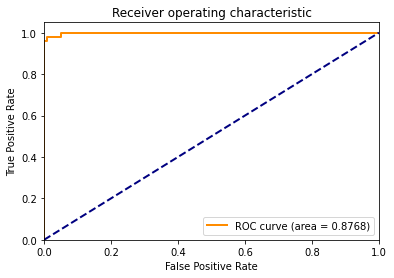

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


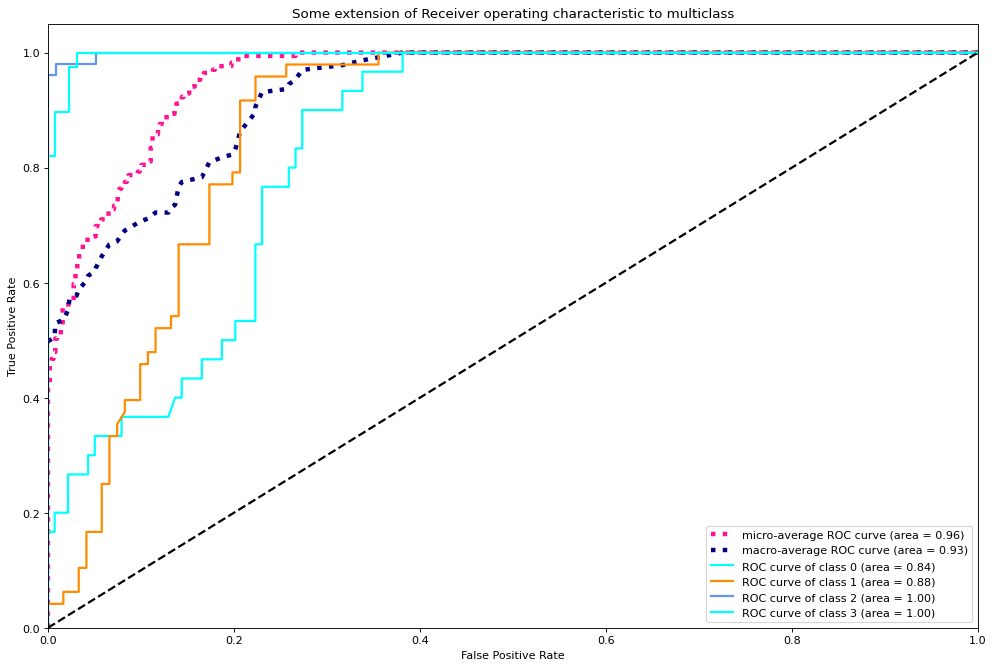

              precision    recall  f1-score   support

           0       0.39      0.47      0.42        30
           1       0.59      0.54      0.57        48
           2       0.96      0.98      0.97        52
           3       0.94      0.87      0.91        39

    accuracy                           0.74       169
   macro avg       0.72      0.72      0.72       169
weighted avg       0.75      0.74      0.74       169


Model name: Random Forest, calibration algo: isotonic


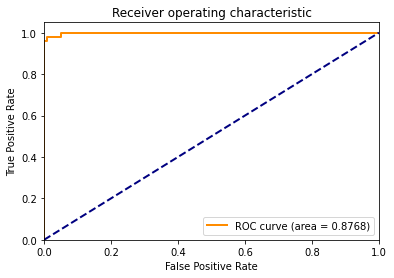

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


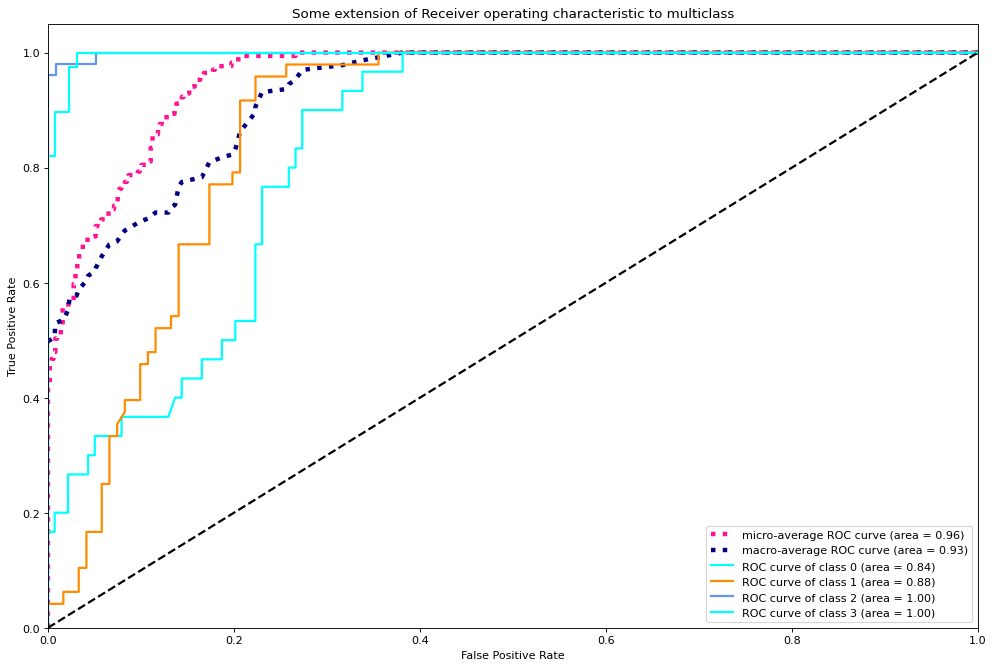

              precision    recall  f1-score   support

           0       0.45      0.57      0.50        30
           1       0.62      0.52      0.57        48
           2       0.96      0.98      0.97        52
           3       0.92      0.90      0.91        39

    accuracy                           0.76       169
   macro avg       0.74      0.74      0.74       169
weighted avg       0.77      0.76      0.76       169


Model name: Random Forest, calibration algo: sigmoid cv


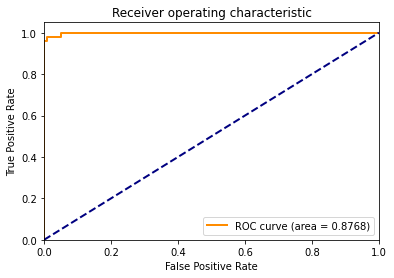

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


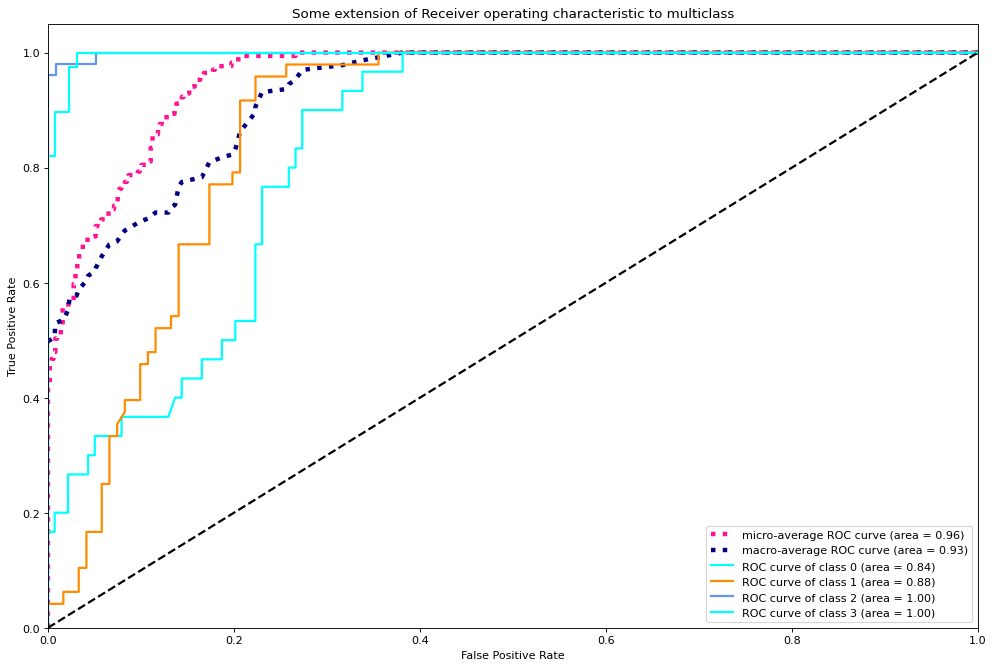

              precision    recall  f1-score   support

           0       0.41      0.43      0.42        30
           1       0.60      0.56      0.58        48
           2       1.00      0.96      0.98        52
           3       0.90      0.97      0.94        39

    accuracy                           0.76       169
   macro avg       0.73      0.73      0.73       169
weighted avg       0.76      0.76      0.76       169


Model name: Random Forest, calibration algo: isotonic cv


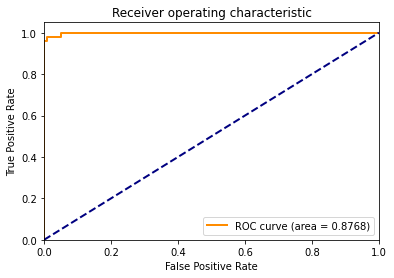

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


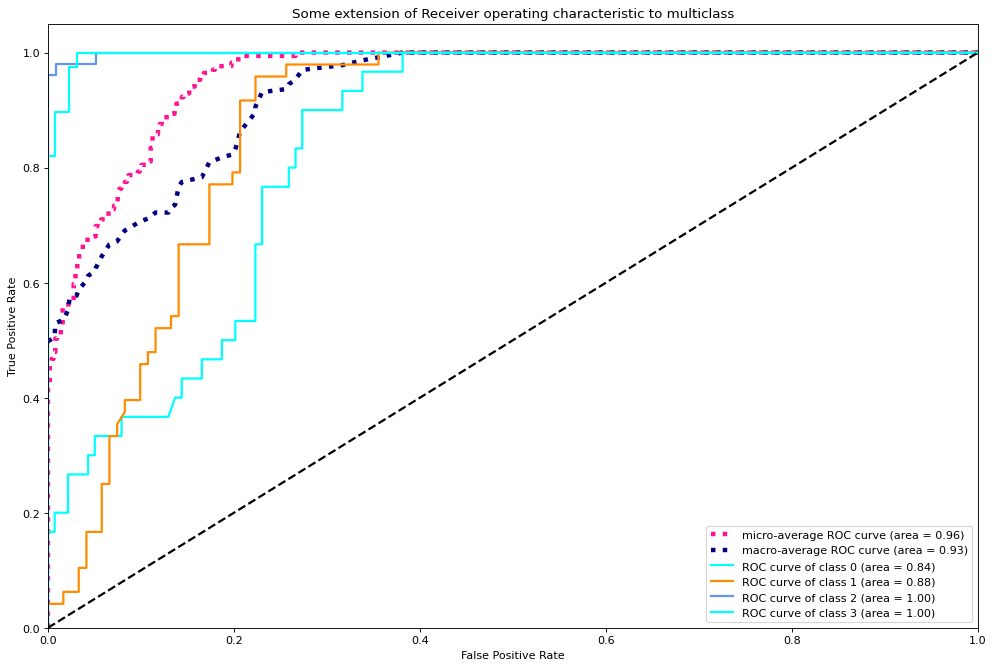

              precision    recall  f1-score   support

           0       0.44      0.60      0.51        30
           1       0.65      0.50      0.56        48
           2       1.00      0.96      0.98        52
           3       0.93      0.97      0.95        39

    accuracy                           0.77       169
   macro avg       0.75      0.76      0.75       169
weighted avg       0.78      0.77      0.77       169


Model name: Random Forest, calibration algo: ivap


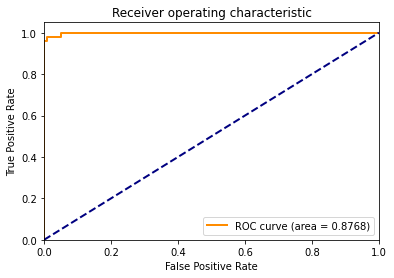

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


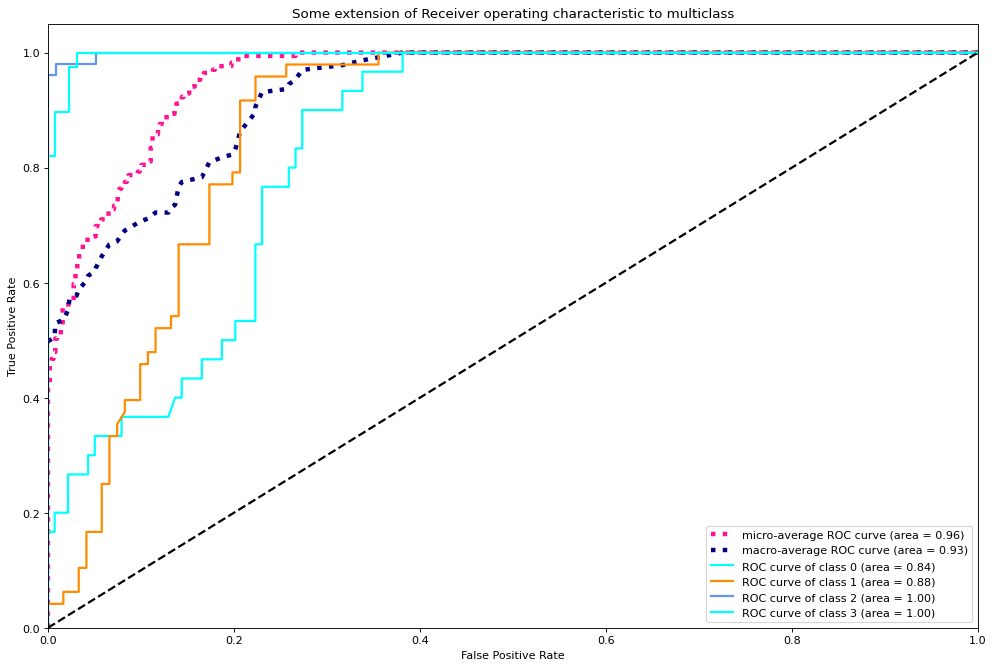

              precision    recall  f1-score   support

           0       0.42      0.57      0.49        30
           1       0.62      0.50      0.55        48
           2       0.96      0.98      0.97        52
           3       0.92      0.87      0.89        39

    accuracy                           0.75       169
   macro avg       0.73      0.73      0.73       169
weighted avg       0.76      0.75      0.75       169


Model name: Random Forest, calibration algo: cvap


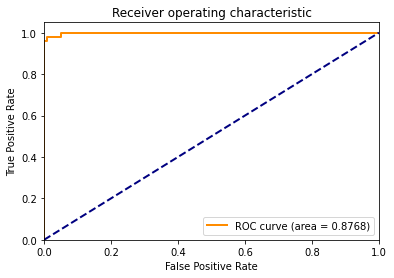

[[[122  17]
  [ 18  12]]

 [[103  18]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[125   5]
  [  1  38]]]


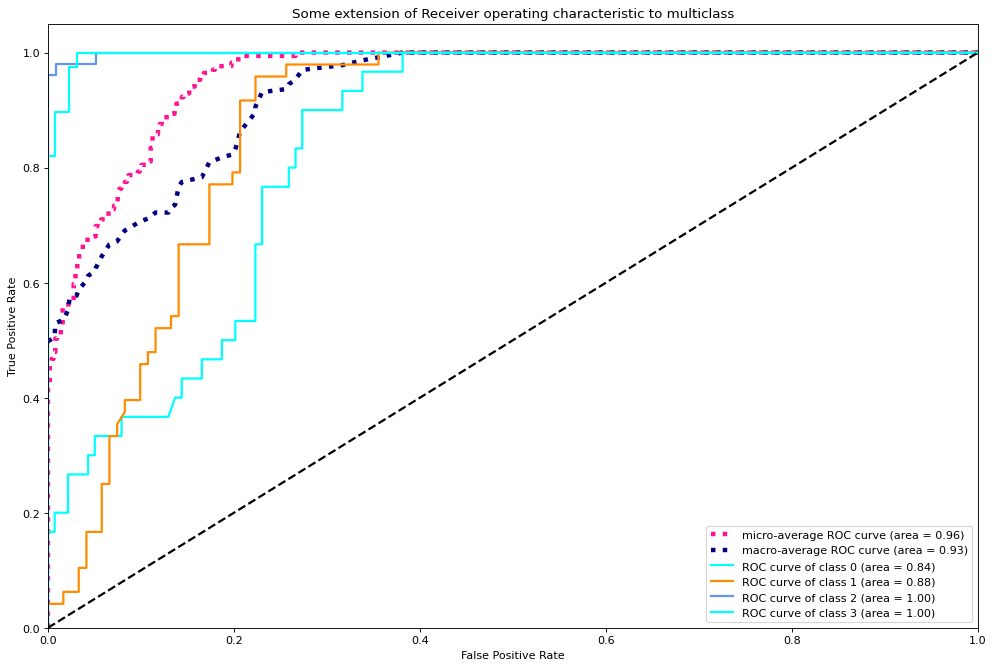

              precision    recall  f1-score   support

           0       0.39      0.47      0.42        30
           1       0.60      0.52      0.56        48
           2       1.00      0.96      0.98        52
           3       0.93      0.97      0.95        39

    accuracy                           0.75       169
   macro avg       0.73      0.73      0.73       169
weighted avg       0.76      0.75      0.75       169



In [79]:
clf_RF = RandomForestClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_RF, 
                    model_name = 'Random Forest')

In [80]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression           0.183455  0.222439  0.695285    0.216654   
neural network                0.564518  0.579015  0.579074    0.564507   
Random Forest                 0.229339  0.224886  0.625612    0.219774   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression        0.360456  0.232770  0.231629  
neural network             0.564515  0.569252  0.563419  
Random Forest              0.191676  0.253022  0.247436  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [81]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine        0.143695  0.156565  0.155171    0.147535   
logistic regression           0.058953  0.067401  0.061614    0.066145   
neural network                0.188338  0.193652  0.193673    0.188334   
Random Forest                 0.073661  0.070480  0.070258    0.068731   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine     0.142952  0.151094  0.143437  
logistic regression        0.059098  0.068273  0.067803  
neural network             0.188337  0.190084  0.187912  
Random Forest              0.065793  0.075516  0.073931  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### LightGBM 


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: LightGBM, calibration algo: no calibration


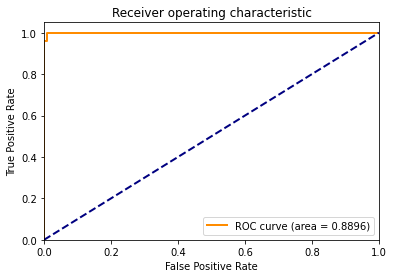

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


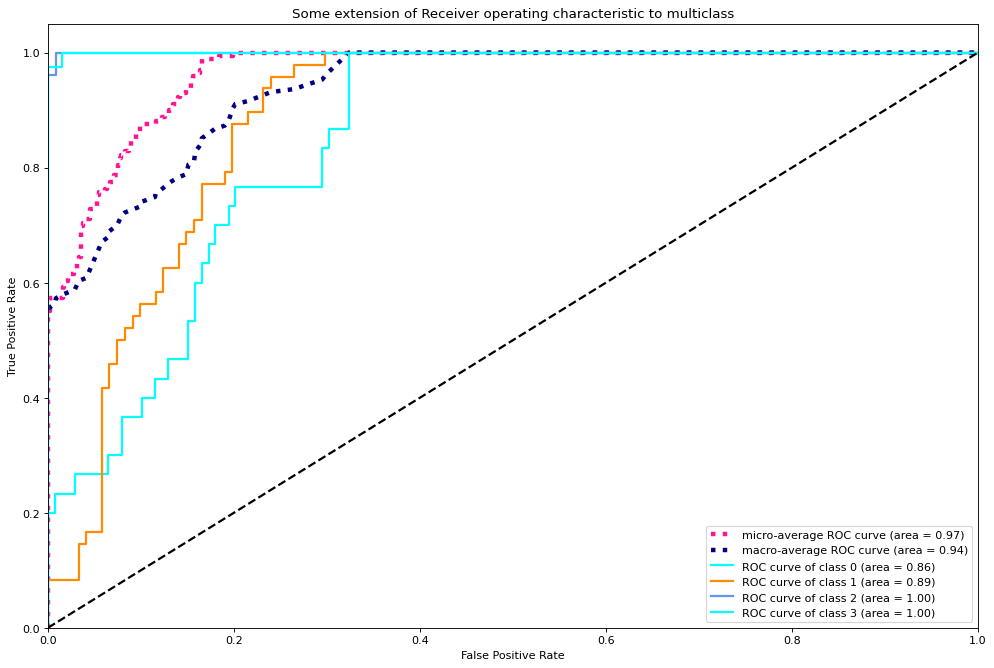

              precision    recall  f1-score   support

           0       0.43      0.53      0.48        30
           1       0.66      0.60      0.63        48
           2       1.00      0.96      0.98        52
           3       1.00      0.97      0.99        39

    accuracy                           0.79       169
   macro avg       0.77      0.77      0.77       169
weighted avg       0.80      0.79      0.79       169


Model name: LightGBM, calibration algo: sigmoid


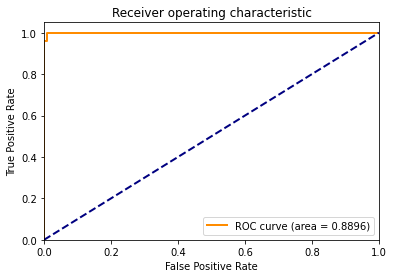

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


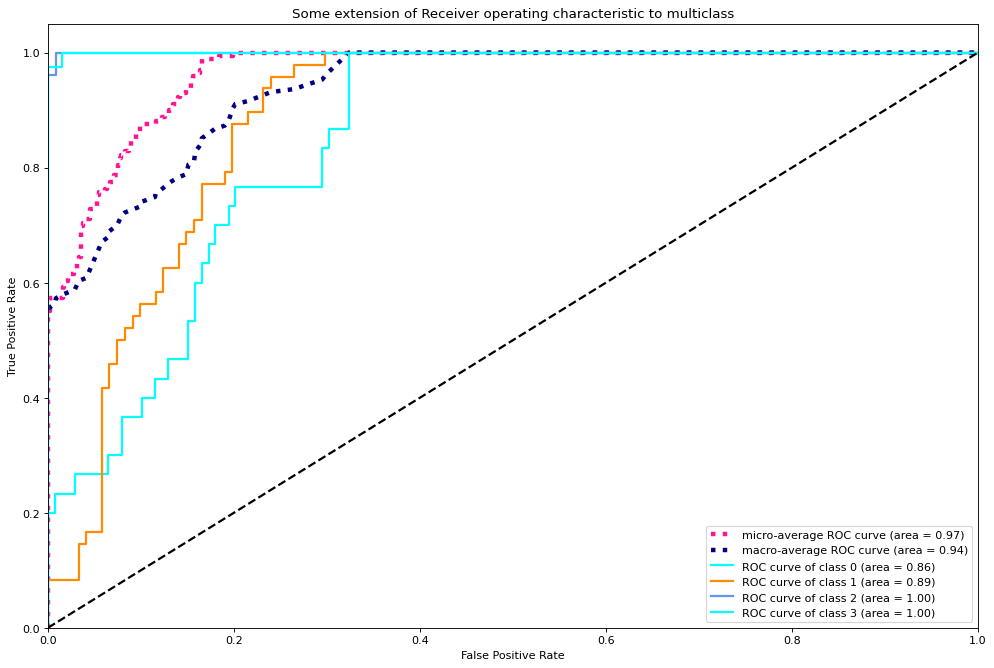

              precision    recall  f1-score   support

           0       0.35      0.50      0.41        30
           1       0.57      0.42      0.48        48
           2       0.96      0.96      0.96        52
           3       0.95      0.95      0.95        39

    accuracy                           0.72       169
   macro avg       0.71      0.71      0.70       169
weighted avg       0.74      0.72      0.72       169


Model name: LightGBM, calibration algo: isotonic


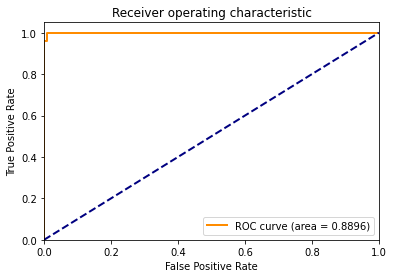

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


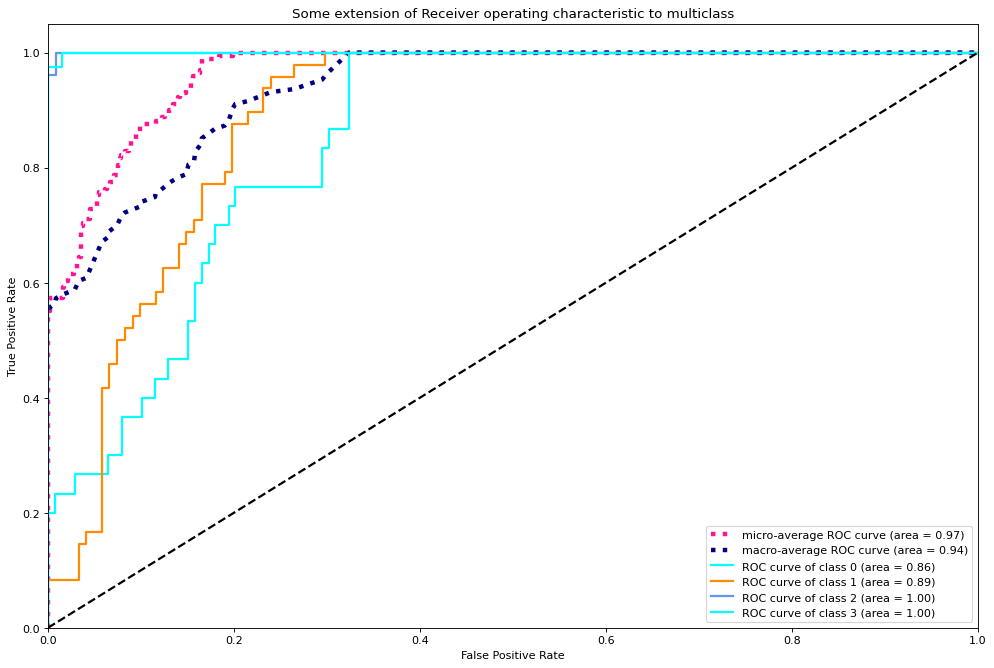

              precision    recall  f1-score   support

           0       0.40      0.90      0.56        30
           1       0.69      0.19      0.30        48
           2       0.94      0.98      0.96        52
           3       1.00      0.90      0.95        39

    accuracy                           0.72       169
   macro avg       0.76      0.74      0.69       169
weighted avg       0.79      0.72      0.70       169


Model name: LightGBM, calibration algo: sigmoid cv


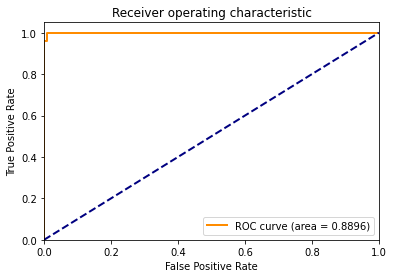

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


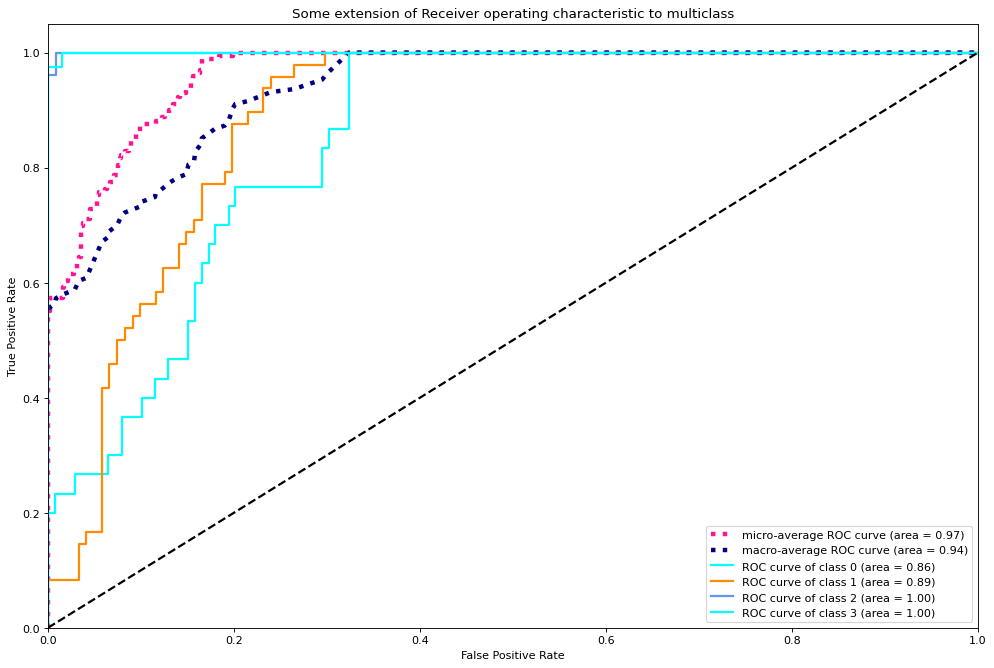

              precision    recall  f1-score   support

           0       0.40      0.57      0.47        30
           1       0.66      0.52      0.58        48
           2       1.00      0.96      0.98        52
           3       0.97      0.97      0.97        39

    accuracy                           0.77       169
   macro avg       0.76      0.76      0.75       169
weighted avg       0.79      0.77      0.78       169


Model name: LightGBM, calibration algo: isotonic cv


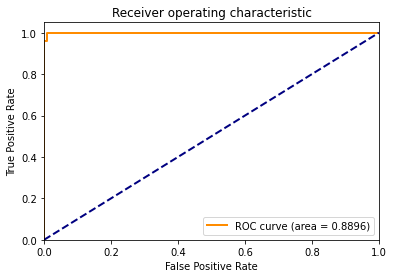

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


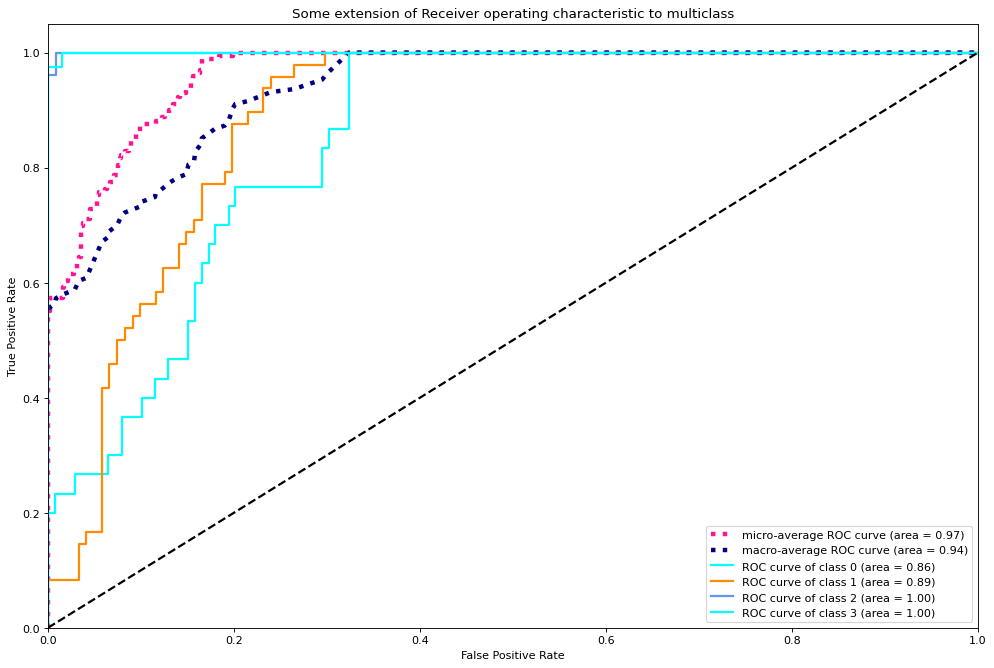

              precision    recall  f1-score   support

           0       0.39      0.60      0.47        30
           1       0.65      0.46      0.54        48
           2       1.00      0.96      0.98        52
           3       0.97      0.97      0.97        39

    accuracy                           0.76       169
   macro avg       0.75      0.75      0.74       169
weighted avg       0.79      0.76      0.76       169


Model name: LightGBM, calibration algo: ivap


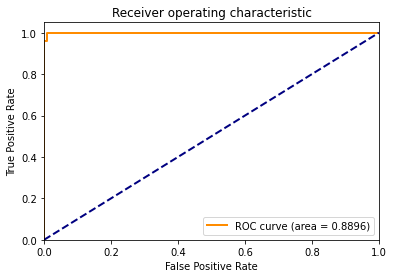

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


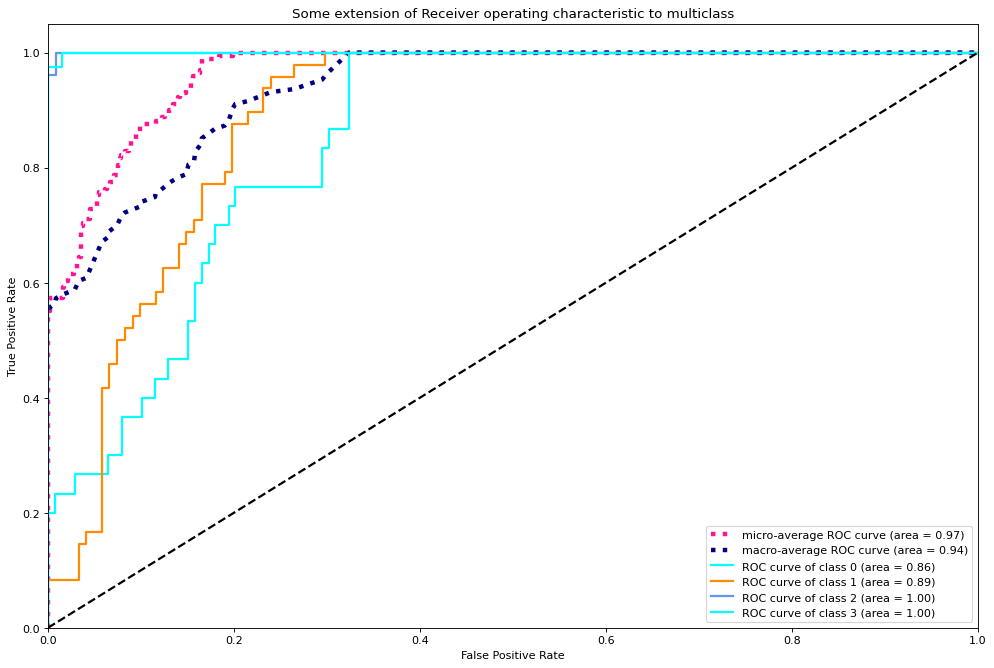

              precision    recall  f1-score   support

           0       0.47      0.83      0.60        30
           1       0.77      0.42      0.54        48
           2       0.96      0.98      0.97        52
           3       0.97      0.92      0.95        39

    accuracy                           0.78       169
   macro avg       0.79      0.79      0.77       169
weighted avg       0.82      0.78      0.78       169


Model name: LightGBM, calibration algo: cvap


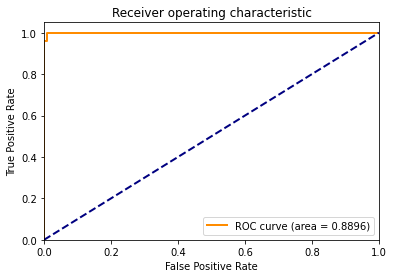

[[[118  21]
  [ 14  16]]

 [[106  15]
  [ 19  29]]

 [[117   0]
  [  2  50]]

 [[130   0]
  [  1  38]]]


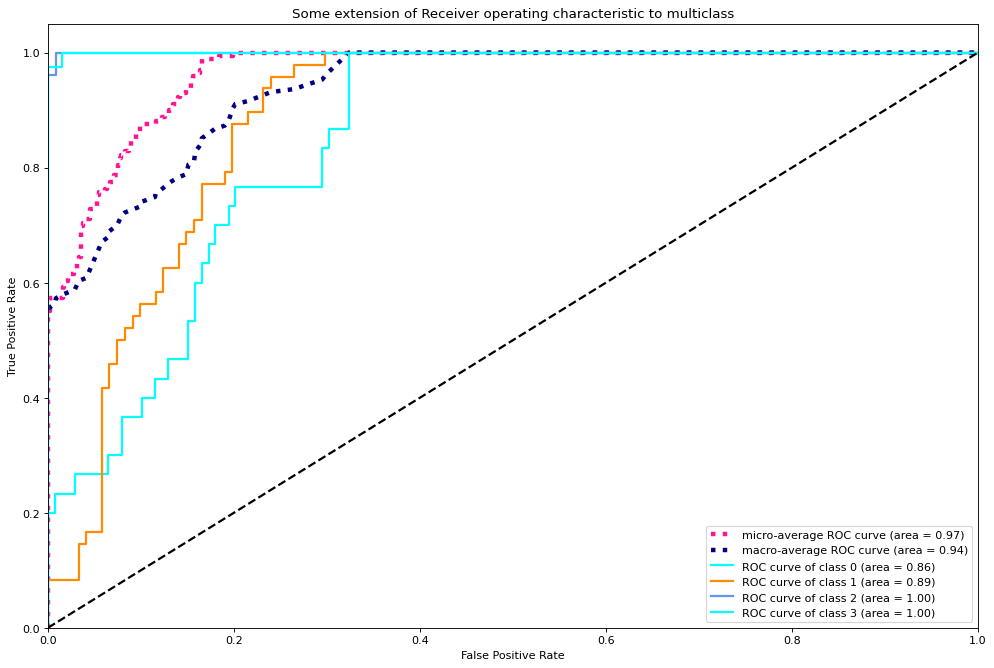

              precision    recall  f1-score   support

           0       0.43      0.67      0.52        30
           1       0.65      0.46      0.54        48
           2       1.00      0.96      0.98        52
           3       0.97      0.95      0.96        39

    accuracy                           0.76       169
   macro avg       0.76      0.76      0.75       169
weighted avg       0.79      0.76      0.77       169



In [82]:
clf_LGBMC = LGBMClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_LGBMC, 
                    model_name = 'LightGBM')



### XGBoost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: XGBoost, calibration algo: no calibration


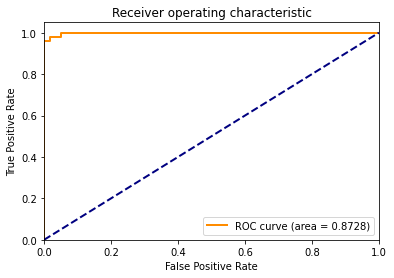

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


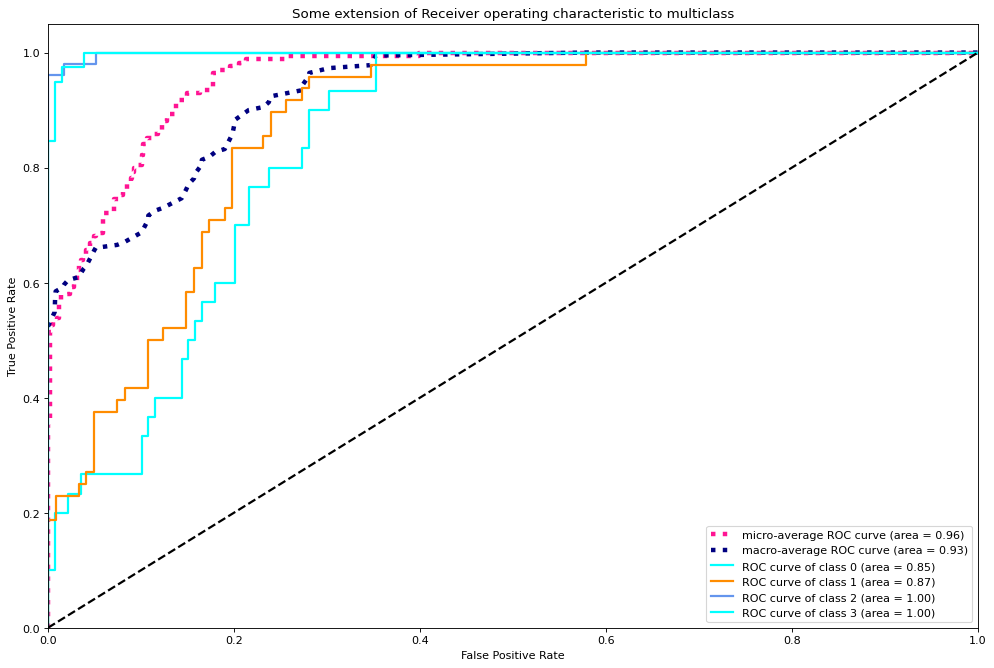

              precision    recall  f1-score   support

           0       0.38      0.47      0.42        30
           1       0.60      0.52      0.56        48
           2       1.00      0.96      0.98        52
           3       0.93      0.95      0.94        39

    accuracy                           0.75       169
   macro avg       0.72      0.72      0.72       169
weighted avg       0.76      0.75      0.75       169


Model name: XGBoost, calibration algo: sigmoid


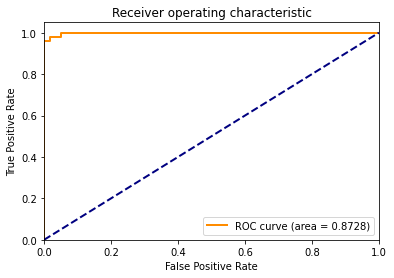

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


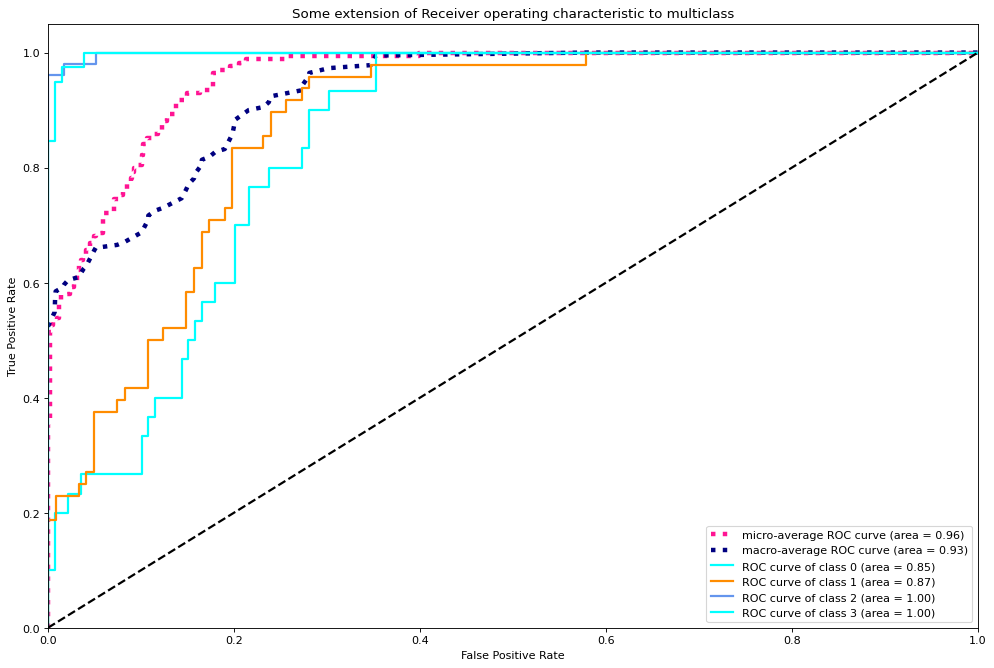

              precision    recall  f1-score   support

           0       0.42      0.50      0.45        30
           1       0.59      0.54      0.57        48
           2       0.96      0.96      0.96        52
           3       0.95      0.90      0.92        39

    accuracy                           0.75       169
   macro avg       0.73      0.73      0.73       169
weighted avg       0.76      0.75      0.75       169


Model name: XGBoost, calibration algo: isotonic


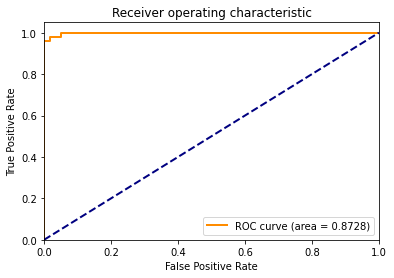

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


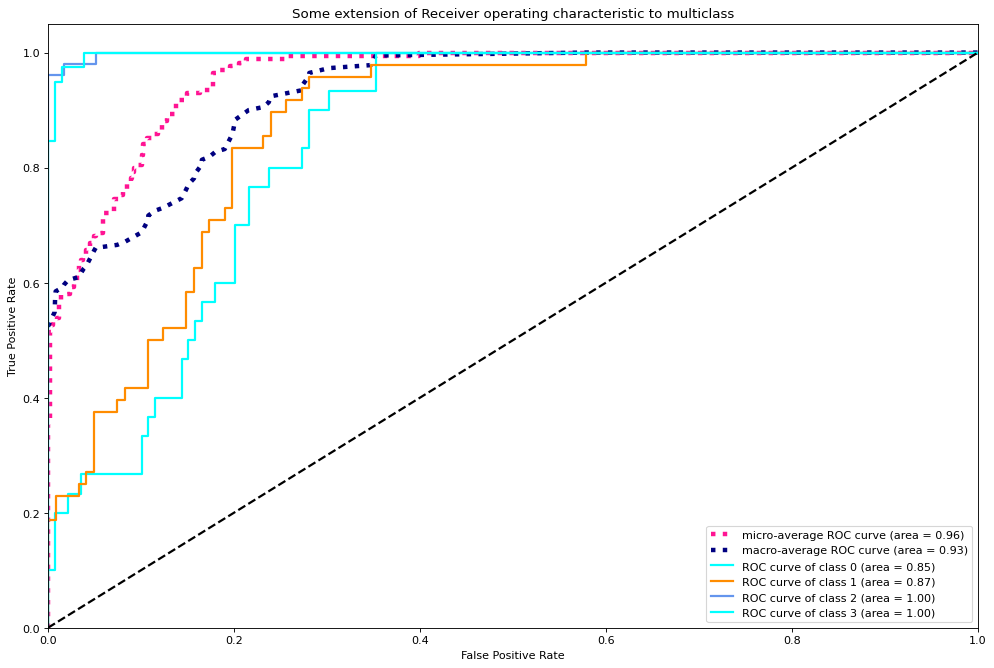

              precision    recall  f1-score   support

           0       0.44      0.53      0.48        30
           1       0.62      0.54      0.58        48
           2       0.96      1.00      0.98        52
           3       0.95      0.90      0.92        39

    accuracy                           0.76       169
   macro avg       0.74      0.74      0.74       169
weighted avg       0.77      0.76      0.76       169


Model name: XGBoost, calibration algo: sigmoid cv


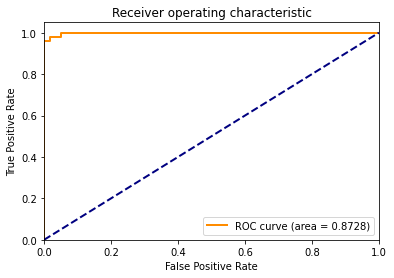

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


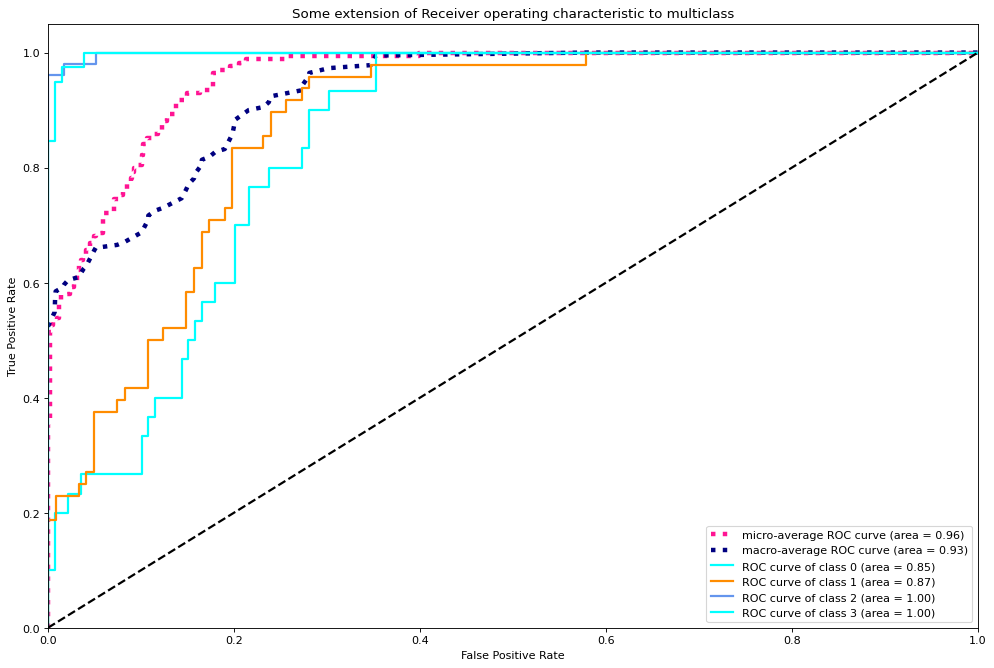

              precision    recall  f1-score   support

           0       0.41      0.50      0.45        30
           1       0.63      0.54      0.58        48
           2       1.00      0.96      0.98        52
           3       0.93      0.97      0.95        39

    accuracy                           0.76       169
   macro avg       0.74      0.74      0.74       169
weighted avg       0.77      0.76      0.77       169


Model name: XGBoost, calibration algo: isotonic cv


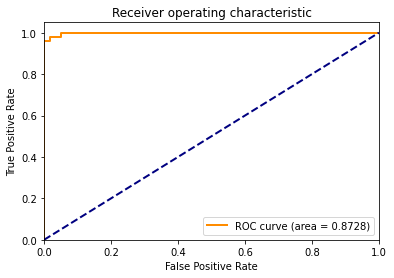

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


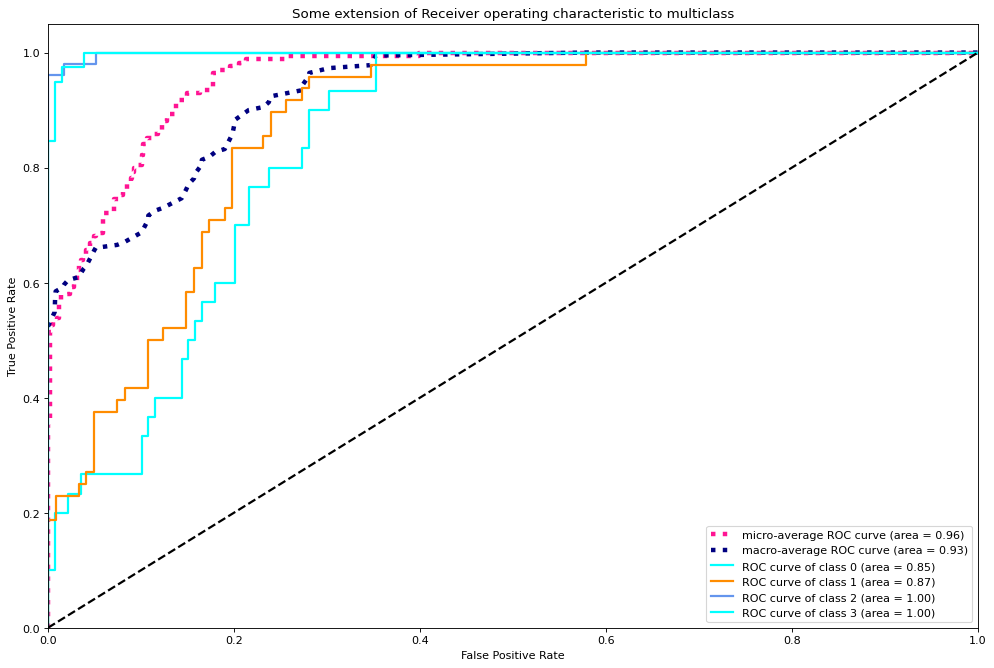

              precision    recall  f1-score   support

           0       0.37      0.53      0.44        30
           1       0.58      0.44      0.50        48
           2       1.00      0.96      0.98        52
           3       0.93      0.95      0.94        39

    accuracy                           0.73       169
   macro avg       0.72      0.72      0.71       169
weighted avg       0.75      0.73      0.74       169


Model name: XGBoost, calibration algo: ivap


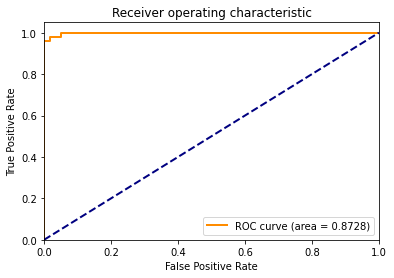

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


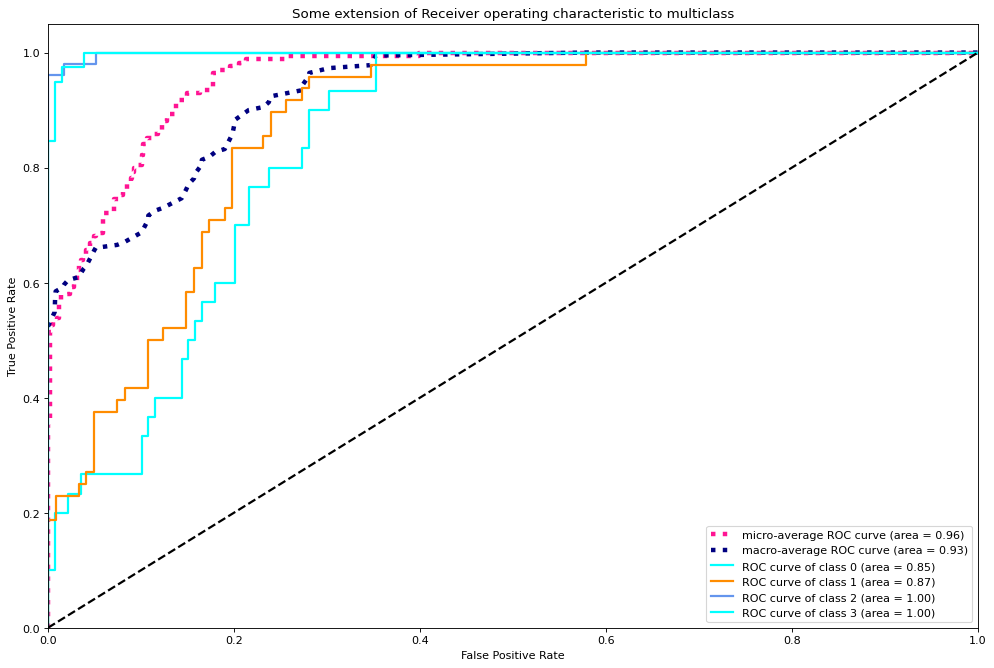

              precision    recall  f1-score   support

           0       0.44      0.50      0.47        30
           1       0.61      0.56      0.59        48
           2       0.95      1.00      0.97        52
           3       0.94      0.87      0.91        39

    accuracy                           0.76       169
   macro avg       0.74      0.73      0.73       169
weighted avg       0.76      0.76      0.76       169


Model name: XGBoost, calibration algo: cvap


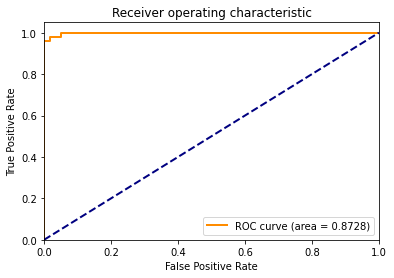

[[[116  23]
  [ 16  14]]

 [[104  17]
  [ 23  25]]

 [[117   0]
  [  2  50]]

 [[127   3]
  [  2  37]]]


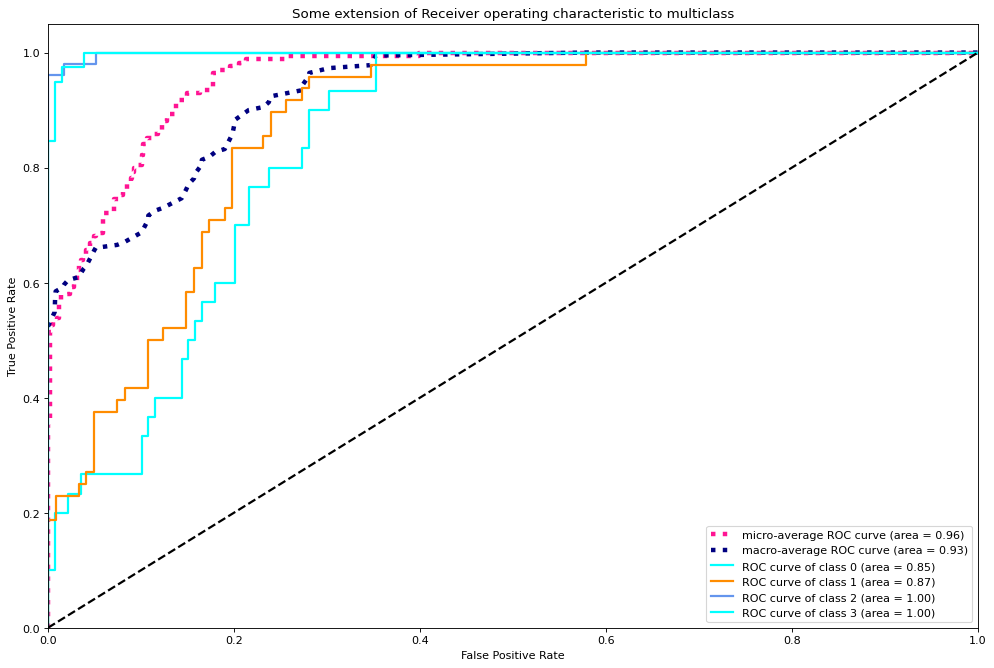

              precision    recall  f1-score   support

           0       0.42      0.63      0.51        30
           1       0.65      0.46      0.54        48
           2       1.00      0.96      0.98        52
           3       0.93      0.95      0.94        39

    accuracy                           0.76       169
   macro avg       0.75      0.75      0.74       169
weighted avg       0.78      0.76      0.76       169



In [83]:
clf_XGBC = XGBClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_XGBC, 
                    model_name = 'XGBoost')

In [84]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression           0.183455  0.222439  0.695285    0.216654   
neural network                0.564518  0.579015  0.579074    0.564507   
Random Forest                 0.229339  0.224886  0.625612    0.219774   
LightGBM                      0.214250  0.231884  0.531924    0.222393   
XGBoost                       0.267242  0.236733  0.439361    0.226911   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression        0.360456  0.232770  0.231629  
neural network             0.564515  0.569252  0.563419  
Random Forest              0.191676  0.253022  0.247436  
LightGBM                   0.193578  0.245092  0.245520  
XGBoost                    0.291584  0.252751  0.248981  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [85]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine        0.143695  0.156565  0.155171    0.147535   
logistic regression           0.058953  0.067401  0.061614    0.066145   
neural network                0.188338  0.193652  0.193673    0.188334   
Random Forest                 0.073661  0.070480  0.070258    0.068731   
LightGBM                      0.072667  0.072904  0.071206    0.068478   
XGBoost                       0.085598  0.075334  0.071919    0.070066   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine     0.142952  0.151094  0.143437  
logistic regression        0.059098  0.068273  0.067803  
neural network             0.188337  0.190084  0.187912  
Random Forest              0.065793  0.075516  0.073931  
LightGBM                   0.066199  0.073848  0.073982  
XGBoost                    0.068151  0.076232  0.075262  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### CatBoost

Streaming output truncated to the last 5000 lines.
58:	learn: 0.2037226	total: 91.4ms	remaining: 63.5ms
59:	learn: 0.2013570	total: 92.8ms	remaining: 61.9ms
60:	learn: 0.1987368	total: 94.2ms	remaining: 60.2ms
61:	learn: 0.1956917	total: 95.6ms	remaining: 58.6ms
62:	learn: 0.1934263	total: 97ms	remaining: 57ms
63:	learn: 0.1913414	total: 98.4ms	remaining: 55.4ms
64:	learn: 0.1891059	total: 100ms	remaining: 53.8ms
65:	learn: 0.1864019	total: 101ms	remaining: 52.2ms
66:	learn: 0.1841268	total: 103ms	remaining: 50.7ms
67:	learn: 0.1817284	total: 104ms	remaining: 49.1ms
68:	learn: 0.1794849	total: 106ms	remaining: 47.5ms
69:	learn: 0.1772881	total: 107ms	remaining: 45.9ms
70:	learn: 0.1752365	total: 111ms	remaining: 45.3ms
71:	learn: 0.1728937	total: 113ms	remaining: 43.9ms
72:	learn: 0.1712131	total: 116ms	remaining: 43.1ms
73:	learn: 0.1697339	total: 118ms	remaining: 41.4ms
74:	learn: 0.1675573	total: 119ms	remaining: 39.7ms
75:	learn: 0.1655579	total: 121ms	remaining: 38.1ms
76:	learn: 

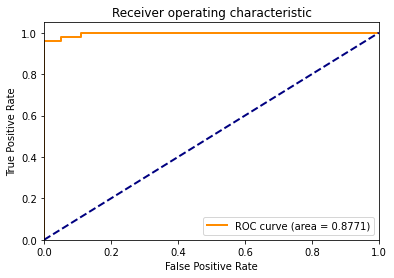

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


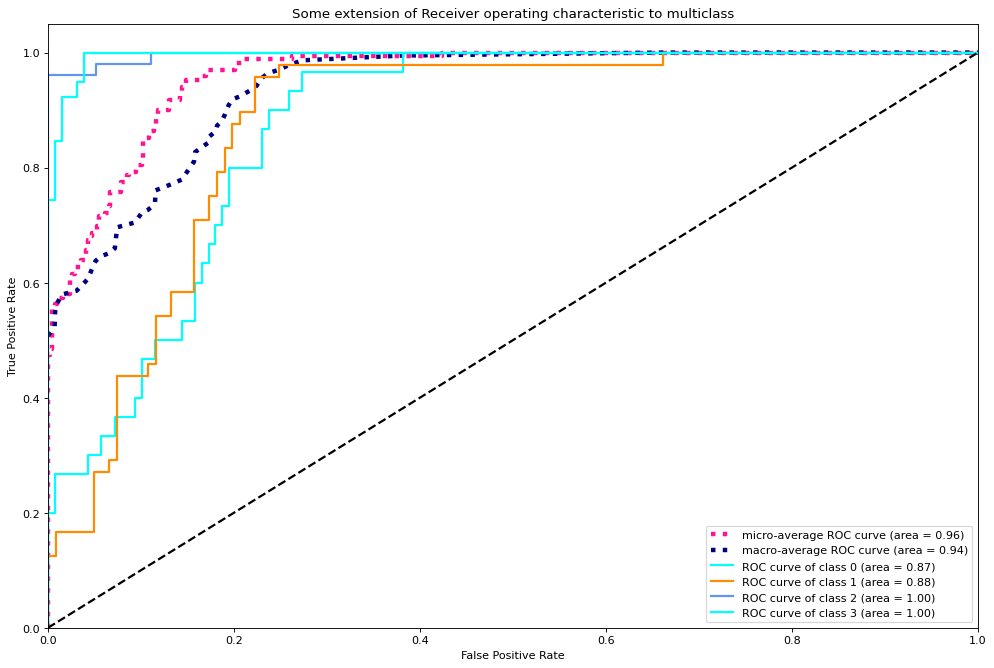

              precision    recall  f1-score   support

           0       0.43      0.50      0.46        30
           1       0.61      0.48      0.53        48
           2       0.98      0.96      0.97        52
           3       0.84      0.97      0.90        39

    accuracy                           0.75       169
   macro avg       0.71      0.73      0.72       169
weighted avg       0.74      0.75      0.74       169


Model name: CatBoost, calibration algo: sigmoid


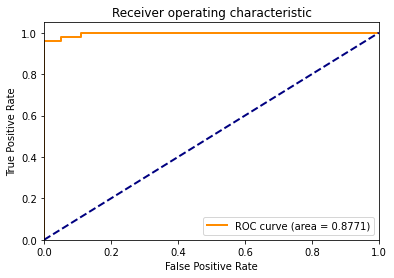

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


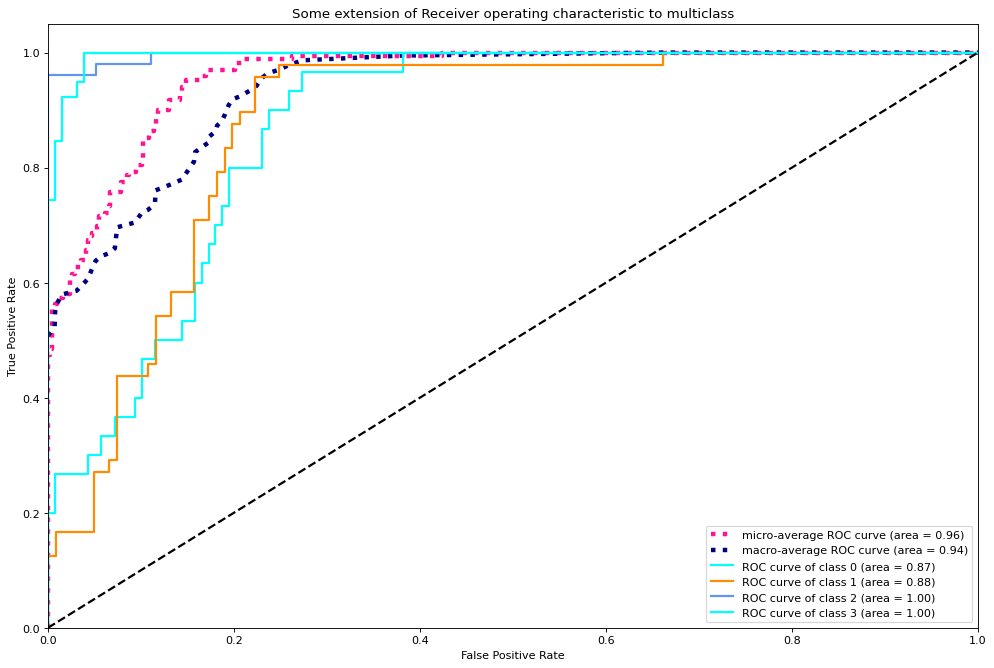

              precision    recall  f1-score   support

           0       0.41      0.47      0.44        30
           1       0.61      0.56      0.59        48
           2       0.96      0.96      0.96        52
           3       0.92      0.92      0.92        39

    accuracy                           0.75       169
   macro avg       0.73      0.73      0.73       169
weighted avg       0.76      0.75      0.75       169


Model name: CatBoost, calibration algo: isotonic


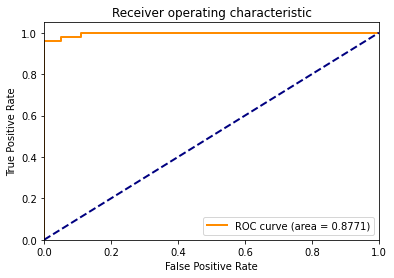

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


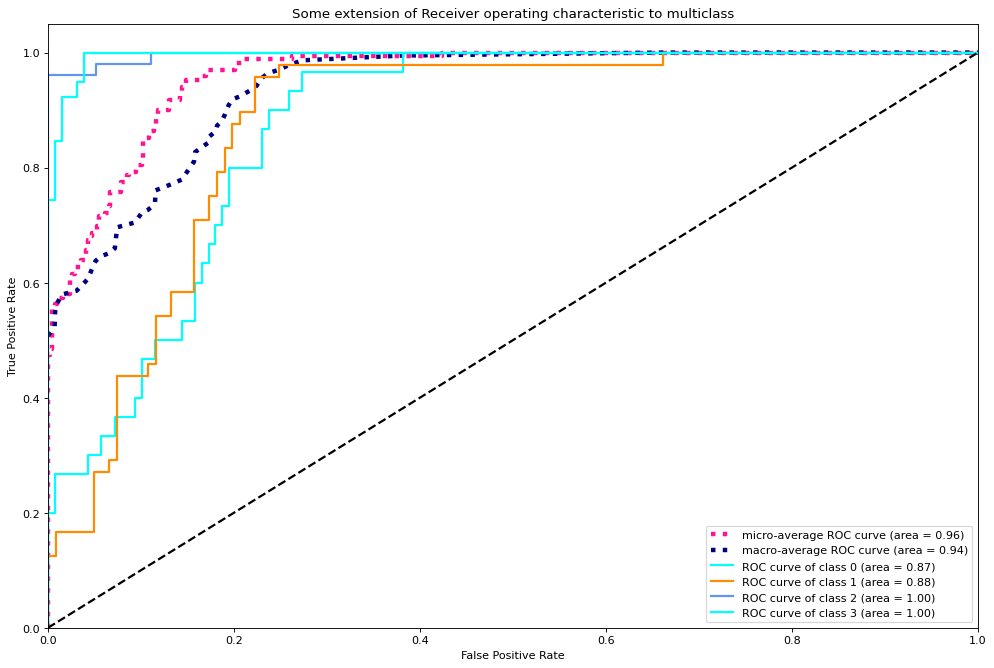

              precision    recall  f1-score   support

           0       0.37      0.33      0.35        30
           1       0.60      0.65      0.62        48
           2       0.98      0.96      0.97        52
           3       0.90      0.90      0.90        39

    accuracy                           0.75       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.74      0.75      0.74       169


Model name: CatBoost, calibration algo: sigmoid cv


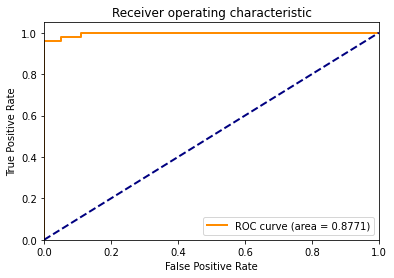

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


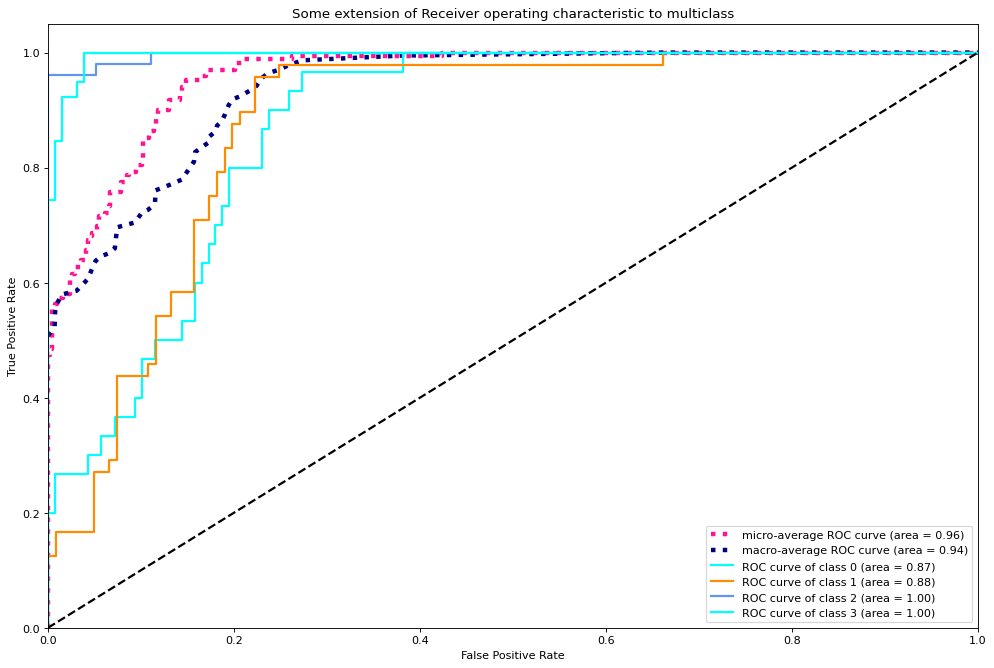

              precision    recall  f1-score   support

           0       0.44      0.50      0.47        30
           1       0.63      0.56      0.59        48
           2       0.98      0.96      0.97        52
           3       0.90      0.95      0.92        39

    accuracy                           0.76       169
   macro avg       0.74      0.74      0.74       169
weighted avg       0.77      0.76      0.76       169


Model name: CatBoost, calibration algo: isotonic cv


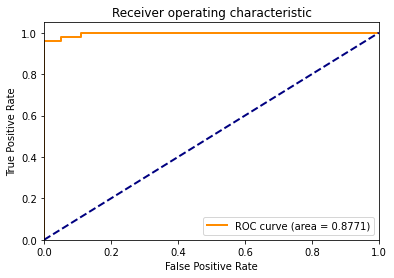

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


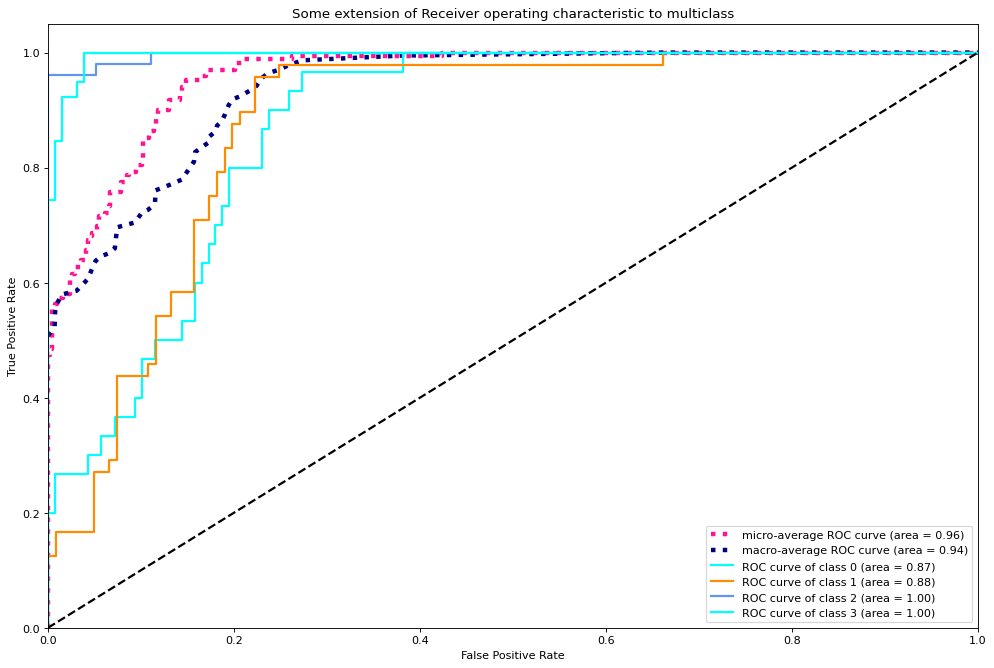

              precision    recall  f1-score   support

           0       0.44      0.50      0.47        30
           1       0.63      0.56      0.59        48
           2       0.98      0.96      0.97        52
           3       0.90      0.95      0.92        39

    accuracy                           0.76       169
   macro avg       0.74      0.74      0.74       169
weighted avg       0.77      0.76      0.76       169


Model name: CatBoost, calibration algo: ivap


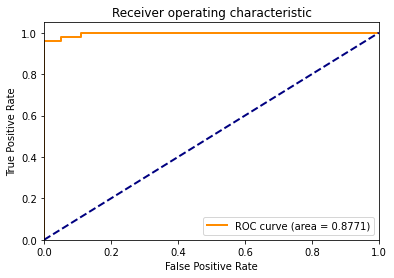

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


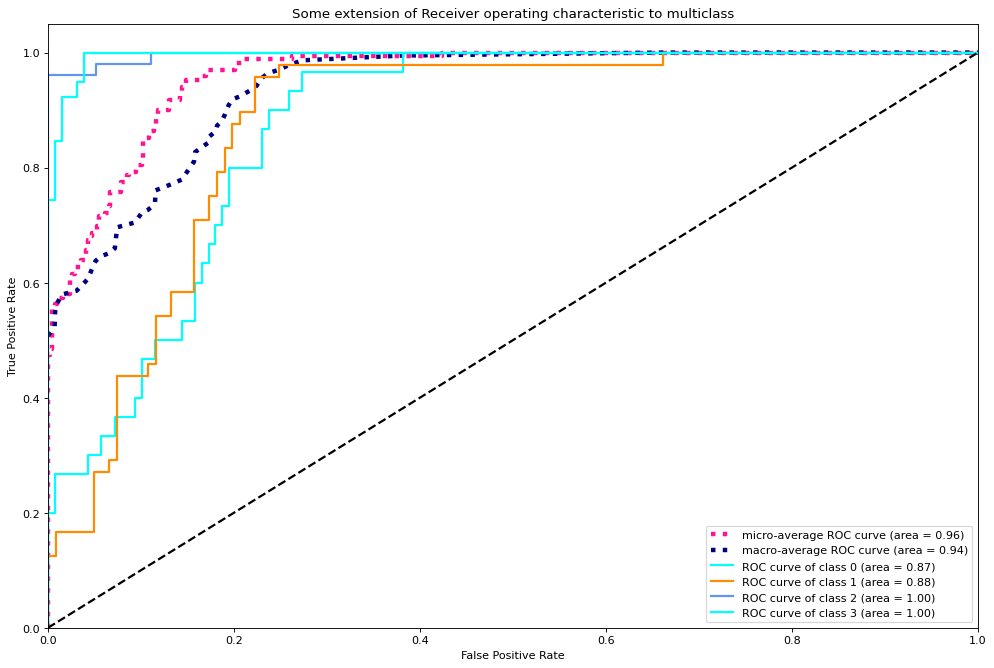

              precision    recall  f1-score   support

           0       0.38      0.33      0.36        30
           1       0.60      0.65      0.62        48
           2       0.96      0.96      0.96        52
           3       0.90      0.90      0.90        39

    accuracy                           0.75       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.74      0.75      0.74       169


Model name: CatBoost, calibration algo: cvap


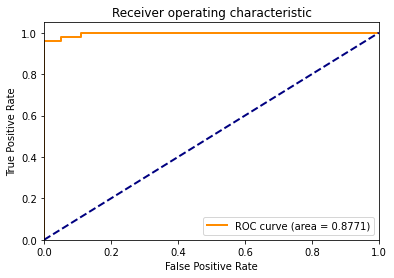

[[[119  20]
  [ 15  15]]

 [[106  15]
  [ 25  23]]

 [[116   1]
  [  2  50]]

 [[123   7]
  [  1  38]]]


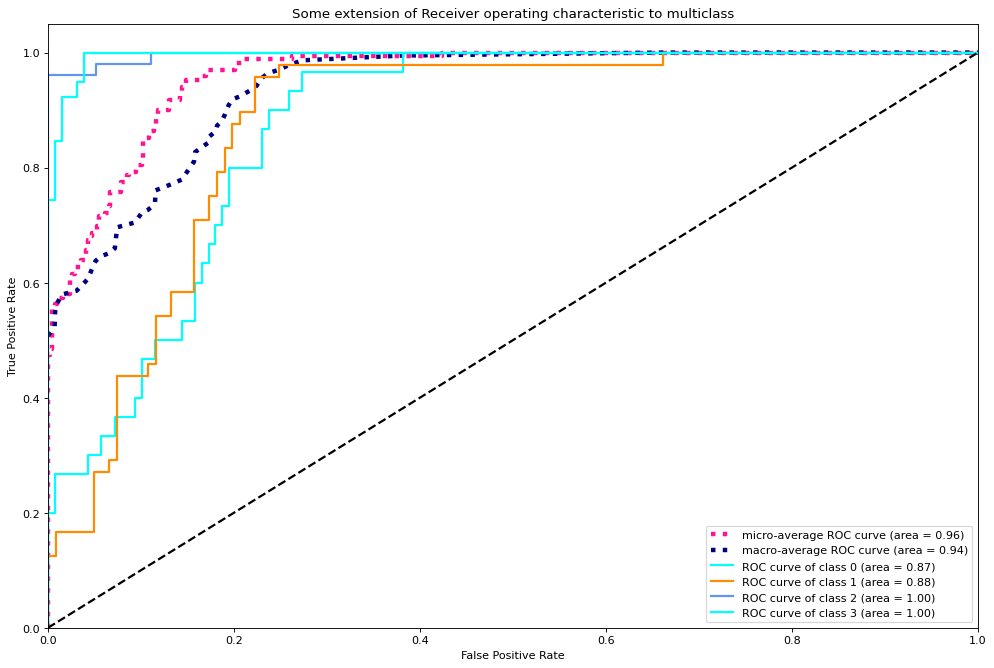

              precision    recall  f1-score   support

           0       0.45      0.60      0.51        30
           1       0.64      0.52      0.57        48
           2       1.00      0.94      0.97        52
           3       0.90      0.95      0.92        39

    accuracy                           0.76       169
   macro avg       0.75      0.75      0.75       169
weighted avg       0.78      0.76      0.77       169



In [86]:
clf_CBC = CatBoostClassifier(iterations=100, random_state=42)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_CBC, 
                    model_name = 'CatBoost')

In [87]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression           0.183455  0.222439  0.695285    0.216654   
neural network                0.564518  0.579015  0.579074    0.564507   
Random Forest                 0.229339  0.224886  0.625612    0.219774   
LightGBM                      0.214250  0.231884  0.531924    0.222393   
XGBoost                       0.267242  0.236733  0.439361    0.226911   
CatBoost                      0.250542  0.231614  0.538392    0.227885   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression        0.360456  0.232770  0.231629  
neural network             0.564515  0.569252  0.563419  
Random Forest              0.191676  0.253022  0.247436  
LightGBM                   0.193578  0.245092  0.245520  
XGBoost                    0.291584  0.252751  0.248981  
CatBoost                   0.244668  0.255023  0.251692  
Ada Boost                       NaN       NaN       NaN

### Ada Boost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:3
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2

Model name: Ada Boost, calibration algo: no calibration


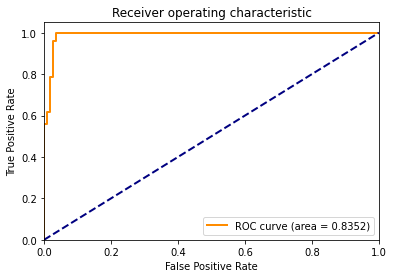

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


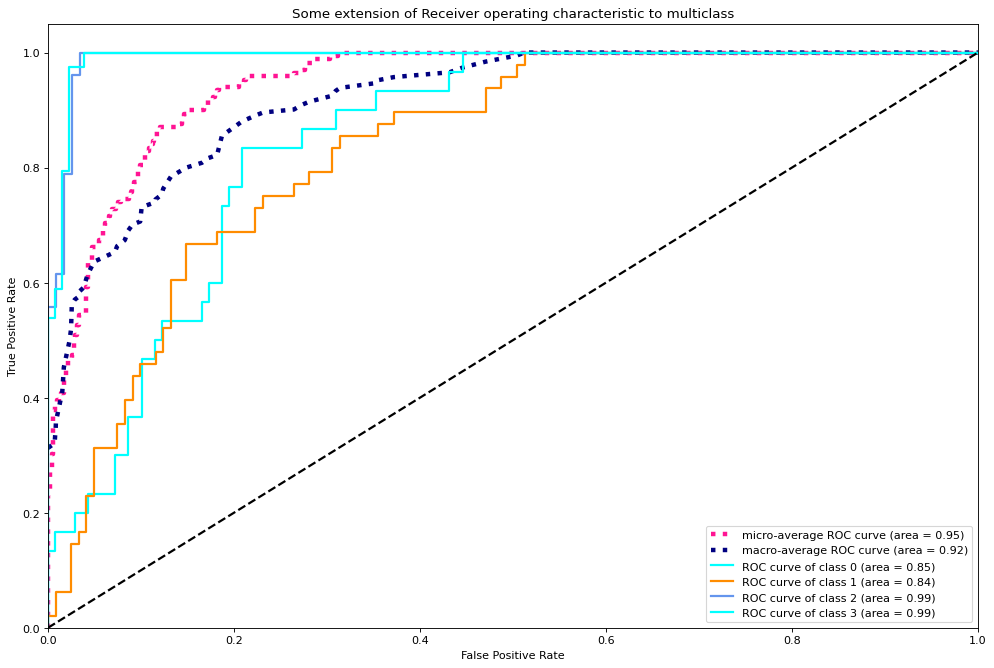

              precision    recall  f1-score   support

           0       0.43      0.63      0.51        30
           1       0.64      0.33      0.44        48
           2       0.93      1.00      0.96        52
           3       0.89      1.00      0.94        39

    accuracy                           0.75       169
   macro avg       0.72      0.74      0.71       169
weighted avg       0.75      0.75      0.73       169


Model name: Ada Boost, calibration algo: sigmoid


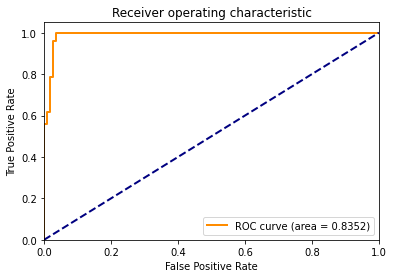

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


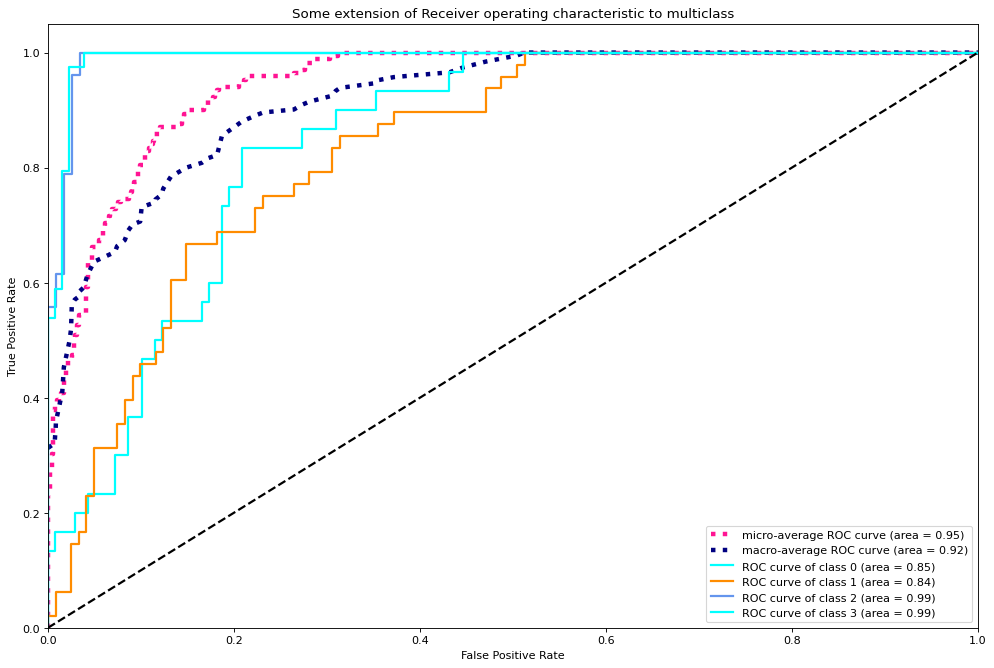

              precision    recall  f1-score   support

           0       0.45      0.30      0.36        30
           1       0.60      0.71      0.65        48
           2       0.95      1.00      0.97        52
           3       0.97      0.92      0.95        39

    accuracy                           0.78       169
   macro avg       0.74      0.73      0.73       169
weighted avg       0.76      0.78      0.77       169


Model name: Ada Boost, calibration algo: isotonic


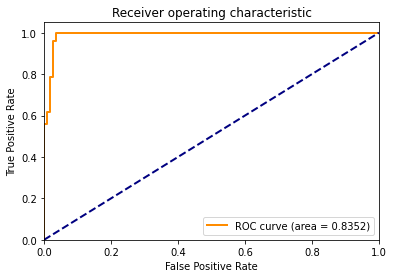

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


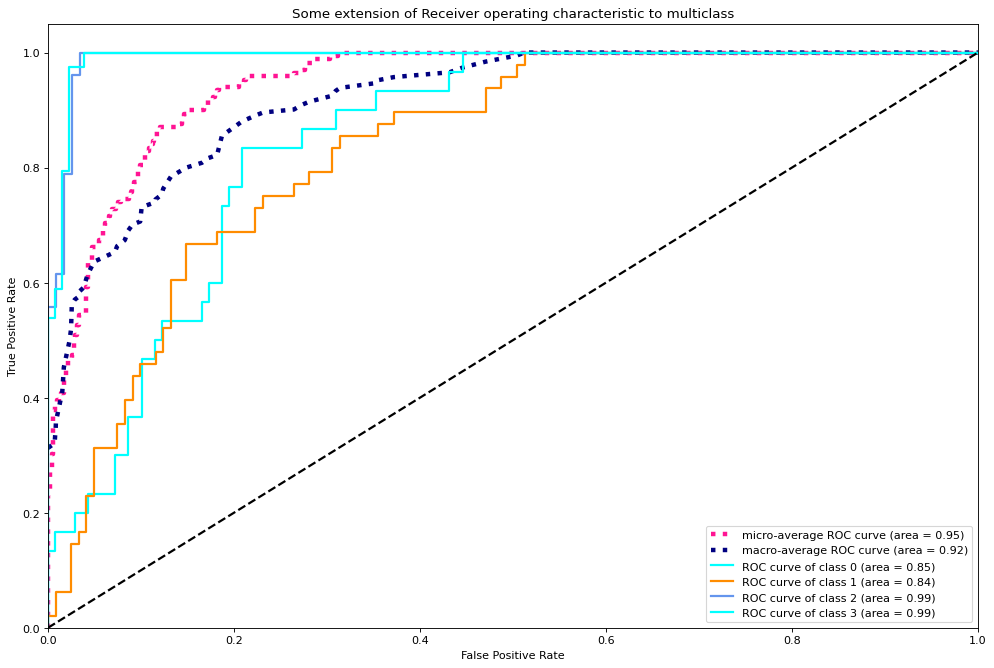

              precision    recall  f1-score   support

           0       0.45      0.80      0.58        30
           1       0.73      0.40      0.51        48
           2       0.95      1.00      0.97        52
           3       1.00      0.90      0.95        39

    accuracy                           0.77       169
   macro avg       0.78      0.77      0.75       169
weighted avg       0.81      0.77      0.77       169


Model name: Ada Boost, calibration algo: sigmoid cv


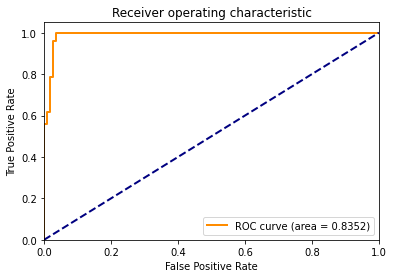

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


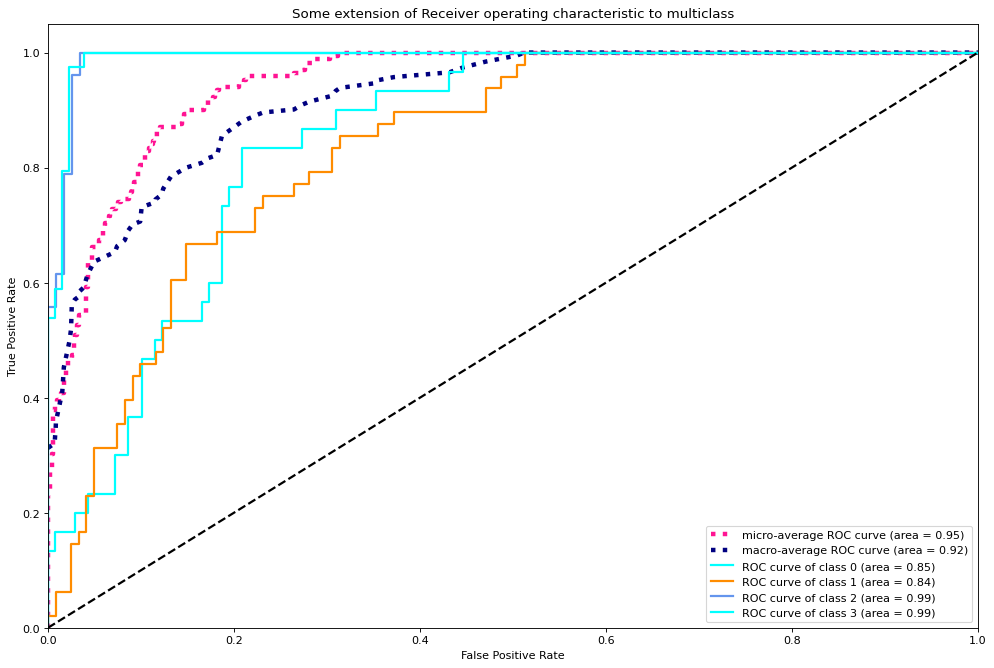

              precision    recall  f1-score   support

           0       0.42      0.47      0.44        30
           1       0.62      0.52      0.57        48
           2       0.96      1.00      0.98        52
           3       0.93      1.00      0.96        39

    accuracy                           0.77       169
   macro avg       0.74      0.75      0.74       169
weighted avg       0.76      0.77      0.76       169


Model name: Ada Boost, calibration algo: isotonic cv


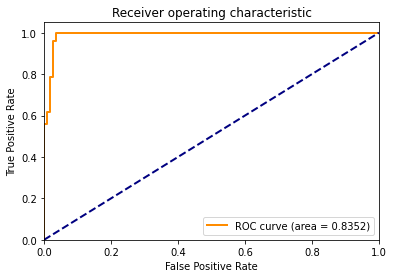

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


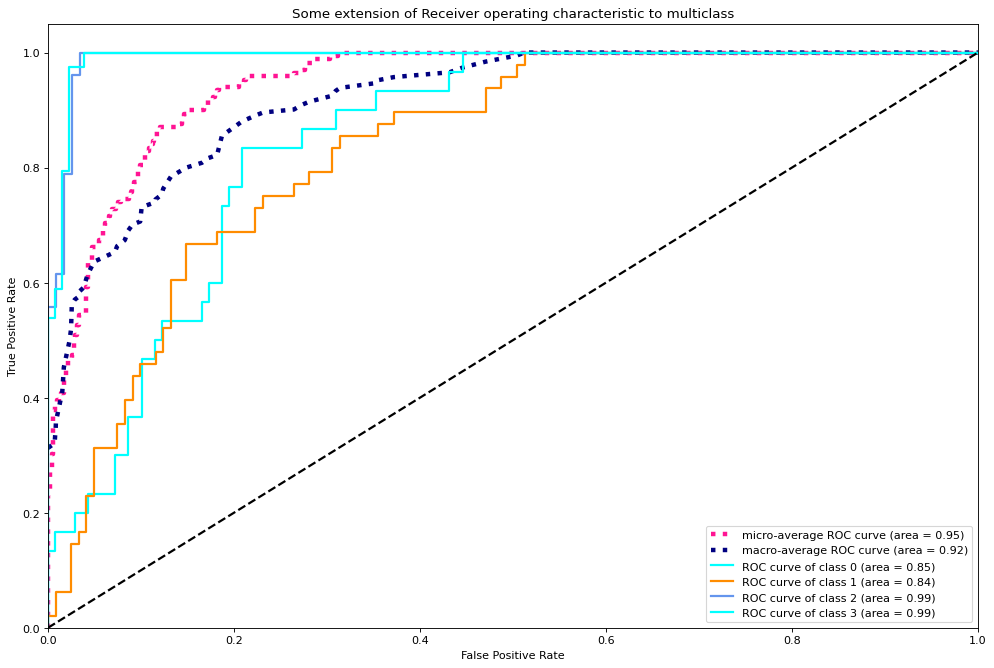

              precision    recall  f1-score   support

           0       0.47      0.50      0.48        30
           1       0.60      0.56      0.58        48
           2       0.96      0.94      0.95        52
           3       0.95      1.00      0.97        39

    accuracy                           0.77       169
   macro avg       0.75      0.75      0.75       169
weighted avg       0.77      0.77      0.77       169


Model name: Ada Boost, calibration algo: ivap


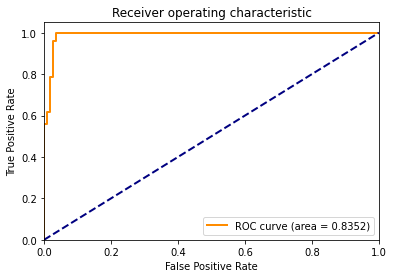

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


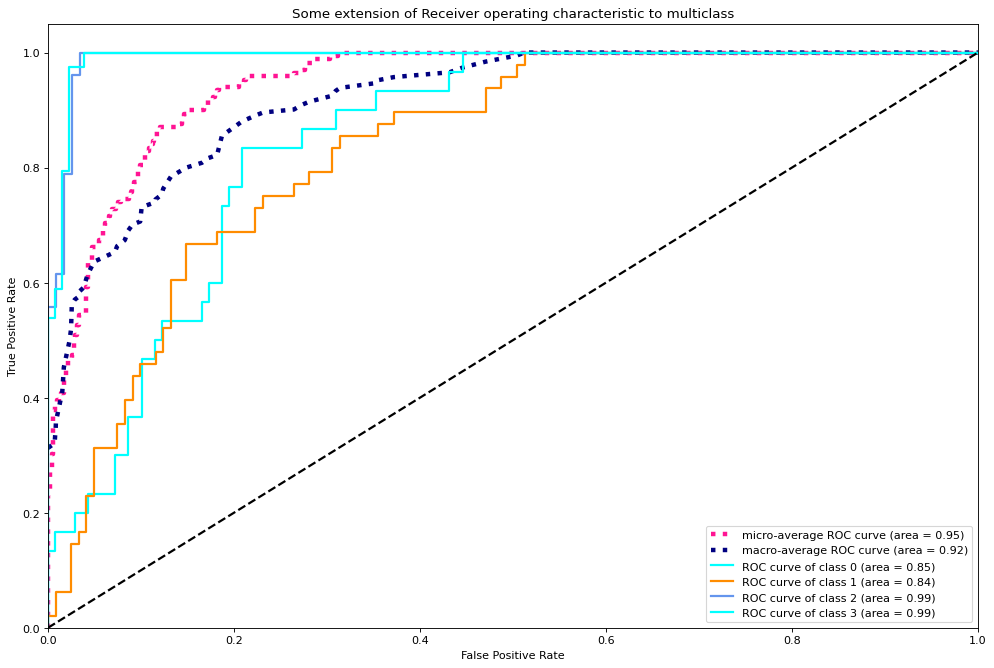

              precision    recall  f1-score   support

           0       0.45      0.67      0.54        30
           1       0.68      0.48      0.56        48
           2       0.93      1.00      0.96        52
           3       1.00      0.90      0.95        39

    accuracy                           0.77       169
   macro avg       0.76      0.76      0.75       169
weighted avg       0.79      0.77      0.77       169


Model name: Ada Boost, calibration algo: cvap


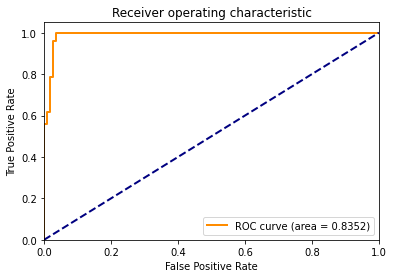

[[[114  25]
  [ 11  19]]

 [[112   9]
  [ 32  16]]

 [[113   4]
  [  0  52]]

 [[125   5]
  [  0  39]]]


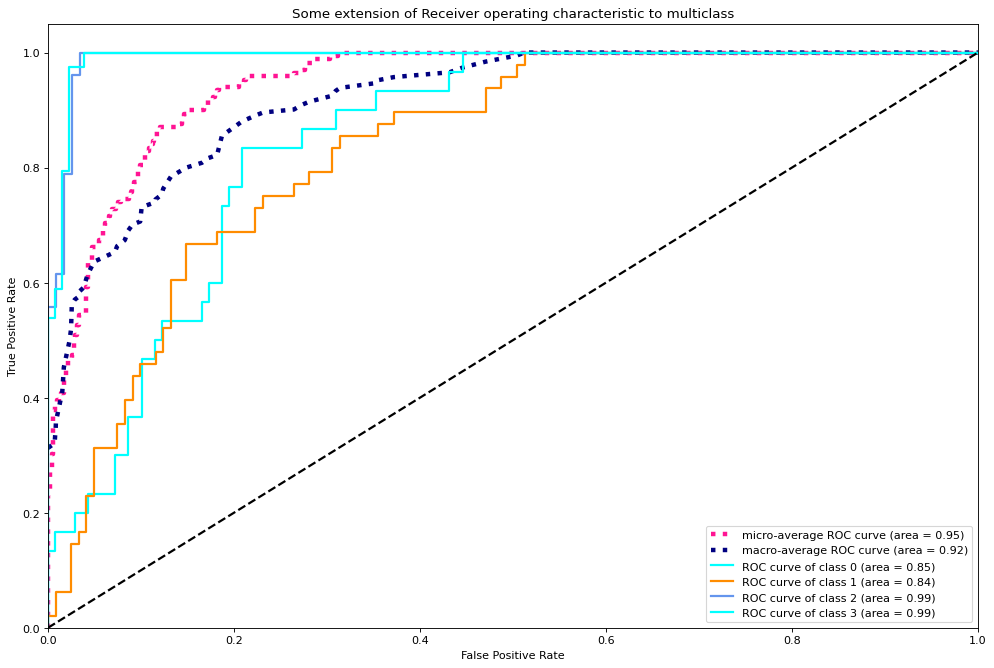

              precision    recall  f1-score   support

           0       0.48      0.37      0.42        30
           1       0.59      0.67      0.63        48
           2       0.96      0.96      0.96        52
           3       0.95      0.97      0.96        39

    accuracy                           0.78       169
   macro avg       0.75      0.74      0.74       169
weighted avg       0.77      0.78      0.77       169



In [88]:
clf_AdaBoost = AdaBoostClassifier()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_AdaBoost, 
                    model_name = 'Ada Boost')

In [89]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.112965  0.494909  0.774207    0.480921   
KNN                           0.700776  0.369499  0.810186    0.343335   
Support Vector Machine        0.435043  0.470686  0.872198    0.447430   
logistic regression           0.183455  0.222439  0.695285    0.216654   
neural network                0.564518  0.579015  0.579074    0.564507   
Random Forest                 0.229339  0.224886  0.625612    0.219774   
LightGBM                      0.214250  0.231884  0.531924    0.222393   
XGBoost                       0.267242  0.236733  0.439361    0.226911   
CatBoost                      0.250542  0.231614  0.538392    0.227885   
Ada Boost                     0.454706  0.243857  0.203427    0.233937   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.583844  0.473755  0.446528  
KNN                        0.371447  0.438224  0.405149  
Support Vector Machine     0.428001  0.455249  0.437035  
logistic regression        0.360456  0.232770  0.231629  
neural network             0.564515  0.569252  0.563419  
Random Forest              0.191676  0.253022  0.247436  
LightGBM                   0.193578  0.245092  0.245520  
XGBoost                    0.291584  0.252751  0.248981  
CatBoost                   0.244668  0.255023  0.251692  
Ada Boost                  0.200339  0.257908  0.248091

In [90]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.213723  0.162903  0.162791    0.159565   
KNN                           0.113495  0.116214  0.116015    0.109012   
Support Vector Machine        0.143695  0.156565  0.155171    0.147535   
logistic regression           0.058953  0.067401  0.061614    0.066145   
neural network                0.188338  0.193652  0.193673    0.188334   
Random Forest                 0.073661  0.070480  0.070258    0.068731   
LightGBM                      0.072667  0.072904  0.071206    0.068478   
XGBoost                       0.085598  0.075334  0.071919    0.070066   
CatBoost                      0.074597  0.072340  0.072680    0.070224   
Ada Boost                     0.146511  0.075954  0.066770    0.070527   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.147277  0.156605  0.145749  
KNN                        0.105862  0.141441  0.127974  
Support Vector Machine     0.142952  0.151094  0.143437  
logistic regression        0.059098  0.068273  0.067803  
neural network             0.188337  0.190084  0.187912  
Random Forest              0.065793  0.075516  0.073931  
LightGBM                   0.066199  0.073848  0.073982  
XGBoost                    0.068151  0.076232  0.075262  
CatBoost                   0.066980  0.076997  0.075171  
Ada Boost                  0.065439  0.076926  0.072946

In [91]:
log_loss_df.to_csv('vehicle_log_loss.csv')
brier_loss_df.to_csv('vehicle_brier_loss.csv')